# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

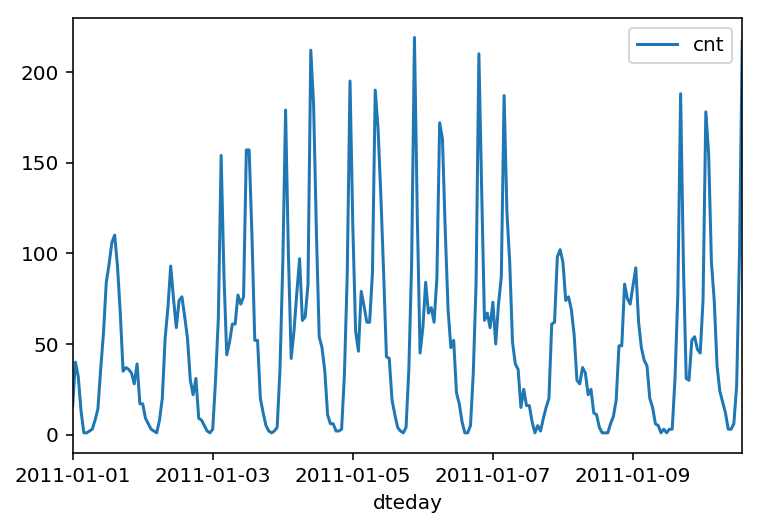

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]


## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [27]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####

        self.activation_function = lambda x : 1/(1+np.exp(-x))  # Replace 0 with your sigmoid calculation.
    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
            Arguments
            ---------
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        '''
        n_records = features.shape[0] # not sure what this means?
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):# X will be used for features andy for targates 
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs)# signals from hidden layer
            
            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            output_error_term = error# f(x)=x so f'(x) = 1 thus error * f'(x) = err0r
             
            # TODO: Calculate the hidden layer's contribution to the error
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            hidden_error = np.dot(self.weights_hidden_to_output, output_error_term)
            hidden_error_term = hidden_error * hidden_outputs * (1.0 - hidden_outputs)
            

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:,None]
            
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:,None]
            
            

        # TODO: Update the weights - Replace these values with your calculations.
        # update input-to-hidden weights with gradient descent step
        # update hidden-to-output weights with gradient descent step

        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records  # 1st 
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records #2nd
        
        print('hidden to output weights')
        print(self.weights_hidden_to_output)
        print('input to hidden')
        print(self.weights_input_to_hidden)
    def run(self, features):
        ''' Run a forward pass through the network with input features 
            Arguments
            ---------
            features: 1D array of feature values
        '''

        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)# signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer
        
        
        return final_outputs

In [28]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [29]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

hidden to output weights
[[ 0.37275328]
 [-0.03172939]]
input to hidden
[[ 0.10562014 -0.20185996]
 [ 0.39775194  0.50074398]
 [-0.29887597  0.19962801]]



----------------------------------------------------------------------
Ran 5 tests in 0.016s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [33]:
import sys

### Set the hyperparameters here ###
iterations = 700
learning_rate = 3
hidden_nodes = 2
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

hidden to output weights
[[-0.93258103]
 [ 0.38453354]]
input to hidden
[[ -9.33737749e-02   1.85944783e-01]
 [ -1.87133434e-01   2.76789499e-02]
 [ -2.67859168e-01   3.63192430e-01]
 [ -1.76822549e-01  -2.02938018e-01]
 [  1.60594556e-02   1.31022704e-01]
 [ -7.17702645e-02  -1.29241596e-01]
 [ -7.62238816e-02  -1.69630148e-01]
 [ -9.15240199e-02  -1.60629408e-01]
 [  1.28227864e-01   9.78536204e-02]
 [ -1.60689430e-02  -2.66012851e-01]
 [  4.99527392e-02  -2.80096868e-02]
 [ -2.31609000e-01  -1.53422172e-02]
 [  1.28122318e-02  -3.97590086e-02]
 [ -1.19821221e-01   2.77845448e-02]
 [  1.07321265e-01  -7.43973239e-02]
 [  1.69457393e-01   2.66173487e-02]
 [  1.15729602e-01  -2.09503200e-01]
 [ -4.78713389e-02  -5.06848965e-02]
 [ -4.95718006e-02  -1.73883538e-01]
 [  6.68547472e-02   5.70147643e-02]
 [ -1.52523046e-01  -2.68193741e-01]
 [ -3.26965715e-01  -1.49779424e-01]
 [  4.21544092e-02   1.59343041e-02]
 [  1.25897977e-01  -1.12250242e-01]
 [ -1.74865809e-01  -6.17866152e-03]
 [ 

Progress: 0.6% ... Training loss: 0.686 ... Validation loss: 1.268hidden to output weights
[[-0.98696494]
 [ 1.19506571]]
input to hidden
[[-0.31020676  0.32583867]
 [-0.19859986  0.03057524]
 [-0.72923026  0.72536772]
 [ 0.33951016 -0.62334335]
 [-0.05697391  0.19005252]
 [ 0.04740382 -0.23156869]
 [-0.20731365 -0.12324561]
 [-0.12106327 -0.17017643]
 [ 0.0378681   0.13697396]
 [-0.18402762 -0.21492078]
 [ 0.01588737 -0.04492244]
 [-0.16139965 -0.07589076]
 [ 0.01281223 -0.03975901]
 [-0.03985044 -0.04309038]
 [ 0.11787474 -0.07052083]
 [ 0.19785347 -0.01893084]
 [ 0.10649811 -0.22244299]
 [-0.12860802  0.00615614]
 [-0.10172629 -0.15258595]
 [ 0.08467125  0.02112125]
 [-0.22911867 -0.19960408]
 [-0.3138682  -0.18750074]
 [ 0.02680838  0.03154183]
 [ 0.11425018 -0.11653244]
 [-0.21080275  0.00849974]
 [ 0.20349084 -0.2578581 ]
 [ 0.02523997 -0.29643345]
 [-0.07145331 -0.07331325]
 [-0.19380312 -0.1458962 ]
 [ 0.19149895 -0.45283155]
 [ 0.15607288 -0.03101284]
 [-0.1729487  -0.25621939

 [  9.62992874e-03  -1.12966440e-01]]
Progress: 1.3% ... Training loss: 0.585 ... Validation loss: 0.970hidden to output weights
[[-1.43902898]
 [ 1.37250742]]
input to hidden
[[-0.374382    0.39961393]
 [-0.15116077 -0.01135601]
 [-0.66187823  0.67318452]
 [ 0.34628371 -0.62406077]
 [-0.07190886  0.20887779]
 [ 0.05270828 -0.26481005]
 [-0.06422175 -0.26449152]
 [ 0.03498716 -0.30680678]
 [ 0.01349882  0.17071265]
 [ 0.0592955  -0.45361798]
 [ 0.01094511 -0.04286116]
 [-0.11970301 -0.11663379]
 [ 0.01281223 -0.03975901]
 [-0.00099395 -0.09597518]
 [ 0.12269471 -0.07691383]
 [ 0.11214035  0.04847792]
 [ 0.15694154 -0.27477192]
 [-0.04066285 -0.0679855 ]
 [-0.05329862 -0.20480005]
 [ 0.21560954 -0.16223589]
 [-0.20579349 -0.19745207]
 [-0.31798519 -0.13380285]
 [-0.0078475   0.06847751]
 [ 0.10741356 -0.1094413 ]
 [-0.18415882 -0.01484508]
 [ 0.26094923 -0.31525768]
 [ 0.08105624 -0.35419585]
 [ 0.08699034 -0.23857036]
 [-0.0818869  -0.27188336]
 [ 0.3045598  -0.56496145]
 [ 0.26491311 

Progress: 2.0% ... Training loss: 0.534 ... Validation loss: 0.804hidden to output weights
[[-1.46289198]
 [ 1.72139564]]
input to hidden
[[-0.43167224  0.48168201]
 [-0.16179555  0.00127581]
 [-0.57699033  0.6179381 ]
 [ 0.36780586 -0.6499834 ]
 [ 0.15690019  0.00944549]
 [ 0.06946585 -0.30411482]
 [-0.12558778 -0.1997239 ]
 [ 0.15751753 -0.41540912]
 [-0.07385628  0.25833785]
 [-0.03777662 -0.34602373]
 [ 0.03191942 -0.09079079]
 [-0.05303838 -0.17181269]
 [ 0.01281223 -0.03975901]
 [-0.01564462 -0.09339509]
 [ 0.13555916 -0.10218104]
 [ 0.10007804  0.06738288]
 [ 0.12627157 -0.24169986]
 [-0.05511321 -0.06394121]
 [ 0.01823898 -0.27919452]
 [ 0.27023914 -0.23907631]
 [-0.14066569 -0.23790349]
 [-0.38345819 -0.05017576]
 [-0.04794206  0.11418217]
 [ 0.06917479 -0.07438377]
 [-0.1821118  -0.01639653]
 [ 0.32646284 -0.38838719]
 [ 0.16442676 -0.437273  ]
 [ 0.19785858 -0.35412206]
 [ 0.02874269 -0.38031139]
 [ 0.40933162 -0.65422583]
 [ 0.34190386 -0.20644329]
 [-0.06503398 -0.37497764

Progress: 2.7% ... Training loss: 0.687 ... Validation loss: 1.053hidden to output weights
[[-1.25496722]
 [ 1.98305484]]
input to hidden
[[-0.63888639  0.55057625]
 [-0.1265867  -0.0452263 ]
 [-0.68637984  0.69671988]
 [ 0.22475406 -0.55389898]
 [ 0.09579568  0.11772913]
 [ 0.09626586 -0.42257955]
 [-0.3139127  -0.09976896]
 [ 0.1150132  -0.45508647]
 [-0.10785957  0.28030796]
 [-0.23445008 -0.32166664]
 [-0.02737907 -0.1015706 ]
 [-0.03509898 -0.221607  ]
 [ 0.01281223 -0.03975901]
 [-0.00988661 -0.14557503]
 [ 0.13311318 -0.12606917]
 [ 0.07768738  0.07459388]
 [ 0.08124397 -0.21244732]
 [-0.16953116 -0.00288764]
 [ 0.0590899  -0.39149792]
 [ 0.2472422  -0.23763322]
 [-0.11274894 -0.30295272]
 [-0.46793871  0.06971049]
 [-0.01217842  0.06316047]
 [ 0.04404297 -0.05476713]
 [-0.21354221  0.01336577]
 [ 0.41932693 -0.51535653]
 [ 0.21359875 -0.50039108]
 [ 0.33712862 -0.50535744]
 [ 0.14283774 -0.51788504]
 [ 0.49179717 -0.75372255]
 [ 0.39440016 -0.25853069]
 [-0.00887213 -0.45124543

Progress: 3.4% ... Training loss: 0.514 ... Validation loss: 0.782hidden to output weights
[[-1.46089539]
 [ 1.57656955]]
input to hidden
[[-0.84537337  0.47730381]
 [-0.07856332 -0.09471652]
 [-0.73781636  0.55691203]
 [ 0.29445325 -0.35330513]
 [ 0.00871999 -0.08237163]
 [ 0.01442484 -0.51400603]
 [-0.26694796 -0.29746186]
 [ 0.11363178 -0.69118178]
 [-0.12017482  0.22358945]
 [-0.28114532 -0.67895977]
 [-0.09676532 -0.21209831]
 [ 0.03240958 -0.33571936]
 [ 0.01281223 -0.03975901]
 [ 0.00374437 -0.21260559]
 [ 0.11397296 -0.14221393]
 [ 0.00754055  0.05254926]
 [ 0.08904617 -0.27768491]
 [-0.16232296 -0.07069734]
 [ 0.06415728 -0.49176489]
 [ 0.29548745 -0.3990127 ]
 [-0.13927038 -0.32923239]
 [-0.4462245   0.04867172]
 [-0.02063397  0.03768312]
 [ 0.04422391 -0.0723036 ]
 [-0.24170028  0.02167848]
 [ 0.4504892  -0.54924421]
 [ 0.27722829 -0.59933652]
 [ 0.40109035 -0.55224318]
 [ 0.26450584 -0.6449705 ]
 [ 0.57198504 -0.84849666]
 [ 0.51433269 -0.41744431]
 [ 0.05862497 -0.53198746

Progress: 4.1% ... Training loss: 0.438 ... Validation loss: 0.687hidden to output weights
[[-1.50449092]
 [ 1.99072394]]
input to hidden
[[-0.68342792  0.51395571]
 [-0.0735638  -0.10298022]
 [-0.53011741  0.63563884]
 [ 0.28803588 -0.35901591]
 [-0.0271793  -0.0770102 ]
 [-0.08565371 -0.4468377 ]
 [-0.15515103 -0.31579006]
 [ 0.14871242 -0.51507366]
 [-0.09665109  0.20127819]
 [-0.26526447 -0.46633482]
 [-0.03656482 -0.23867027]
 [ 0.02665099 -0.31913536]
 [ 0.01281223 -0.03975901]
 [-0.03478345 -0.19190844]
 [ 0.12203418 -0.15947818]
 [-0.03592913  0.0941064 ]
 [ 0.11422092 -0.26778721]
 [-0.12908369 -0.07859962]
 [ 0.11589246 -0.50799899]
 [ 0.3259542  -0.40948785]
 [-0.16313133 -0.2022519 ]
 [-0.3956658   0.07800739]
 [-0.01846481  0.05013995]
 [ 0.05323792 -0.08893555]
 [-0.27593809  0.05189824]
 [ 0.5118485  -0.61260112]
 [ 0.37072803 -0.68513739]
 [ 0.49294507 -0.62903138]
 [ 0.34185704 -0.69817499]
 [ 0.67322916 -0.91355949]
 [ 0.56682382 -0.46139825]
 [ 0.13431414 -0.6130264 

Progress: 4.9% ... Training loss: 0.421 ... Validation loss: 0.584hidden to output weights
[[-1.79079917]
 [ 2.07025152]]
input to hidden
[[-0.53104486  0.46649356]
 [-0.03957257 -0.15232933]
 [-0.41821086  0.68310297]
 [ 0.21914056 -0.31644074]
 [-0.09818326 -0.0028095 ]
 [-0.07248238 -0.53364002]
 [-0.05743994 -0.3892376 ]
 [ 0.20482661 -0.48957166]
 [ 0.00720234  0.06173958]
 [-0.04417643 -0.6592889 ]
 [-0.03298011 -0.24639243]
 [ 0.07282826 -0.39274559]
 [ 0.01281223 -0.03975901]
 [-0.00916647 -0.23483519]
 [ 0.08394077 -0.16747917]
 [-0.0037897   0.05828576]
 [ 0.13886092 -0.29007766]
 [-0.10528199 -0.0894255 ]
 [ 0.14197923 -0.51165461]
 [ 0.28954882 -0.34289488]
 [-0.1273523  -0.26193469]
 [-0.30312514  0.05203235]
 [ 0.036533   -0.03164781]
 [ 0.05548604 -0.09927977]
 [-0.24843979  0.01232891]
 [ 0.54330224 -0.64953022]
 [ 0.4575317  -0.76790156]
 [ 0.58374116 -0.71709776]
 [ 0.42349692 -0.77784548]
 [ 0.73905725 -0.96468928]
 [ 0.63243514 -0.53590787]
 [ 0.15835162 -0.63979211

Progress: 5.6% ... Training loss: 0.393 ... Validation loss: 0.678hidden to output weights
[[-1.54639918]
 [ 2.21808286]]
input to hidden
[[-0.70850884  0.49949081]
 [-0.04270205 -0.18803972]
 [-0.49275893  0.60845134]
 [ 0.19225398 -0.36680018]
 [-0.00958161  0.1047095 ]
 [-0.13115081 -0.59568624]
 [-0.19639558 -0.32100939]
 [ 0.10315851 -0.59733158]
 [-0.06966326  0.07271461]
 [-0.3840374  -0.64806356]
 [-0.09361877 -0.26382152]
 [ 0.09717013 -0.47714474]
 [ 0.01281223 -0.03975901]
 [-0.00464197 -0.27082877]
 [ 0.02714849 -0.17407681]
 [ 0.00543535  0.01716819]
 [ 0.07808103 -0.25964496]
 [-0.15021161 -0.06850279]
 [ 0.06466576 -0.46130338]
 [ 0.34853763 -0.46152908]
 [-0.19714903 -0.28359291]
 [-0.33714419  0.03355174]
 [ 0.01792713 -0.02962523]
 [-0.02069052 -0.05065249]
 [-0.25892242  0.01185137]
 [ 0.61366019 -0.75900516]
 [ 0.51592639 -0.83699271]
 [ 0.63117658 -0.77119743]
 [ 0.50110217 -0.85502798]
 [ 0.76225339 -0.99250036]
 [ 0.71146384 -0.62759864]
 [ 0.16214938 -0.66104626

Progress: 6.3% ... Training loss: 0.331 ... Validation loss: 0.534hidden to output weights
[[-1.74721173]
 [ 2.34655666]]
input to hidden
[[ -5.29690393e-01   5.04546466e-01]
 [ -1.17991677e-02  -2.41074871e-01]
 [ -3.33386953e-01   6.51414621e-01]
 [  2.06664566e-01  -3.52314205e-01]
 [  1.22935650e-01  -5.22049278e-02]
 [ -9.74717492e-02  -6.83028585e-01]
 [ -8.05306529e-02  -3.77629280e-01]
 [  1.42727290e-01  -5.05856013e-01]
 [ -5.53832521e-02   4.44885925e-02]
 [ -2.97720855e-01  -6.07523017e-01]
 [ -5.86302846e-02  -2.95130920e-01]
 [  1.79257874e-01  -5.67088571e-01]
 [  1.28122318e-02  -3.97590086e-02]
 [  4.71855798e-03  -2.93741521e-01]
 [  3.62435905e-02  -2.13690505e-01]
 [  2.94383450e-02  -1.13174418e-02]
 [  8.00321406e-02  -2.54572933e-01]
 [ -8.53503190e-02  -1.26741144e-01]
 [  1.15894123e-01  -4.76365550e-01]
 [  3.21778248e-01  -4.16386520e-01]
 [ -1.48357500e-01  -2.76360391e-01]
 [ -2.93038257e-01   5.12794791e-02]
 [  2.37797537e-02  -1.90067581e-02]
 [ -4.45123

Progress: 7.0% ... Training loss: 0.421 ... Validation loss: 0.584hidden to output weights
[[-1.54602284]
 [ 2.67138751]]
input to hidden
[[-0.70101244  0.81211301]
 [-0.04596758 -0.18596658]
 [-0.40832519  0.82946933]
 [ 0.24779679 -0.43958992]
 [-0.08985389  0.09173485]
 [-0.14097524 -0.67756805]
 [-0.21937762 -0.20007246]
 [ 0.07421401 -0.39947988]
 [-0.05048886  0.05392987]
 [-0.46376176 -0.37771832]
 [-0.08712373 -0.26502122]
 [ 0.12782288 -0.52816819]
 [ 0.01281223 -0.03975901]
 [-0.03265377 -0.27944214]
 [ 0.02023359 -0.20683713]
 [ 0.03032544 -0.03258173]
 [ 0.02484871 -0.17009765]
 [-0.11642003 -0.07815335]
 [ 0.05310483 -0.44155115]
 [ 0.24624958 -0.3342135 ]
 [-0.12038247 -0.25712575]
 [-0.29979326  0.08442463]
 [ 0.01537344 -0.00232014]
 [-0.02913598 -0.07905465]
 [-0.26129102  0.01788951]
 [ 0.70626966 -0.84702837]
 [ 0.61007676 -0.90654587]
 [ 0.72864817 -0.84928063]
 [ 0.6032158  -0.92750161]
 [ 0.88522889 -1.09172651]
 [ 0.78856372 -0.70164959]
 [ 0.19899943 -0.70122352

Progress: 7.7% ... Training loss: 0.337 ... Validation loss: 0.525hidden to output weights
[[-1.51226483]
 [ 2.4834207 ]]
input to hidden
[[-0.69961553  0.76295016]
 [-0.02385886 -0.22181199]
 [-0.57641204  0.71503423]
 [ 0.27994796 -0.3687814 ]
 [ 0.06123796 -0.04984673]
 [-0.07893924 -0.77167693]
 [-0.24960054 -0.35492286]
 [ 0.04580412 -0.52201918]
 [-0.11087087 -0.00254235]
 [-0.52505668 -0.59103743]
 [-0.10597279 -0.40456316]
 [ 0.15098805 -0.60327796]
 [ 0.01281223 -0.03975901]
 [-0.00362399 -0.3019609 ]
 [ 0.04432084 -0.24439744]
 [ 0.07560715 -0.11912738]
 [-0.03187323 -0.15992742]
 [-0.10164872 -0.11620282]
 [-0.01126367 -0.49748751]
 [ 0.26438257 -0.42245364]
 [-0.12615305 -0.28868857]
 [-0.31048005  0.03557265]
 [-0.04567329  0.02979303]
 [-0.03945543 -0.10048411]
 [-0.24065887 -0.02166974]
 [ 0.74569257 -0.89741538]
 [ 0.63664846 -0.94371409]
 [ 0.77559861 -0.90970783]
 [ 0.67973535 -1.00024006]
 [ 0.89531368 -1.10091989]
 [ 0.85649048 -0.79655774]
 [ 0.18567796 -0.72819262

Progress: 8.3% ... Training loss: 0.360 ... Validation loss: 0.525hidden to output weights
[[-1.43962994]
 [ 2.45366436]]
input to hidden
[[-0.61987584  0.71080812]
 [-0.02717818 -0.21206246]
 [-0.49670626  0.64376132]
 [ 0.25242406 -0.41973098]
 [ 0.04405418 -0.03089828]
 [-0.08713208 -0.83038243]
 [-0.24054158 -0.2707459 ]
 [ 0.05122396 -0.64511907]
 [-0.12119187 -0.00216809]
 [-0.52402247 -0.60017178]
 [-0.10388045 -0.46270613]
 [ 0.14478312 -0.63357201]
 [ 0.01185556 -0.0394418 ]
 [-0.00576222 -0.31902264]
 [ 0.05821438 -0.30131178]
 [ 0.03688627 -0.07041637]
 [-0.03363861 -0.14425778]
 [-0.06302946 -0.14122198]
 [-0.0241628  -0.43777362]
 [ 0.26148805 -0.46025839]
 [-0.10781712 -0.3731722 ]
 [-0.29891768  0.01535074]
 [-0.04366542  0.02907429]
 [-0.05723059 -0.08433581]
 [-0.25291961 -0.0169425 ]
 [ 0.76548212 -0.93338346]
 [ 0.67356479 -0.96778922]
 [ 0.82212456 -0.94494805]
 [ 0.69123084 -1.01642354]
 [ 0.91575272 -1.11363713]
 [ 0.86951212 -0.80967237]
 [ 0.20329689 -0.74502049

Progress: 9.0% ... Training loss: 0.389 ... Validation loss: 0.612hidden to output weights
[[-1.47007541]
 [ 2.62810942]]
input to hidden
[[-0.53064587  0.83361552]
 [-0.0417028  -0.20834682]
 [-0.4565251   0.90014362]
 [ 0.18481495 -0.31740069]
 [ 0.01250904  0.09577419]
 [-0.15880236 -0.79057463]
 [-0.13331574 -0.3433962 ]
 [ 0.04731439 -0.56276512]
 [-0.09004602 -0.10211928]
 [-0.3925272  -0.65641357]
 [-0.19003095 -0.41126431]
 [ 0.16223019 -0.67921178]
 [ 0.01185556 -0.0394418 ]
 [-0.04417189 -0.29168156]
 [ 0.05435862 -0.32793119]
 [ 0.02083834 -0.05858568]
 [ 0.00213233 -0.17012181]
 [-0.03307731 -0.14413879]
 [-0.01351035 -0.41257054]
 [ 0.2660876  -0.46689599]
 [-0.10365225 -0.30202711]
 [-0.25939553 -0.03818359]
 [-0.0814253   0.05064197]
 [-0.03764069 -0.13516859]
 [-0.23830655 -0.05806488]
 [ 0.76069101 -0.94006424]
 [ 0.7125197  -1.00646218]
 [ 0.88414011 -1.00143646]
 [ 0.73740967 -1.05197911]
 [ 0.94501681 -1.13420638]
 [ 0.93171588 -0.87962895]
 [ 0.20377889 -0.75319767

Progress: 9.7% ... Training loss: 0.297 ... Validation loss: 0.478hidden to output weights
[[-1.57879773]
 [ 2.60976693]]
input to hidden
[[-0.5103783   0.90441061]
 [-0.02775166 -0.2295615 ]
 [-0.39218703  0.67695337]
 [ 0.21777687 -0.29882386]
 [ 0.00447373  0.0248412 ]
 [-0.14387595 -0.75882265]
 [-0.14016178 -0.3002117 ]
 [ 0.03882433 -0.65855042]
 [-0.06487068 -0.17375258]
 [-0.45684036 -0.58380871]
 [-0.1245823  -0.53773055]
 [ 0.18586035 -0.71783252]
 [ 0.01185556 -0.0394418 ]
 [-0.02775803 -0.30306316]
 [ 0.0468174  -0.29923044]
 [ 0.01678018 -0.02216326]
 [ 0.03688656 -0.2467406 ]
 [-0.04651378 -0.11229484]
 [-0.01414595 -0.41576727]
 [ 0.21364128 -0.43256488]
 [-0.05806323 -0.37344667]
 [-0.23036372 -0.09042281]
 [-0.03886284 -0.02009194]
 [-0.06194722 -0.1016743 ]
 [-0.27946795 -0.02974971]
 [ 0.80358301 -0.99790168]
 [ 0.73736582 -1.0253751 ]
 [ 0.91044105 -1.02347734]
 [ 0.80989319 -1.10388511]
 [ 0.99404544 -1.16532734]
 [ 0.94947797 -0.90014007]
 [ 0.23952978 -0.79675385

Progress: 10.4% ... Training loss: 0.299 ... Validation loss: 0.441hidden to output weights
[[-1.59318176]
 [ 2.6535527 ]]
input to hidden
[[ -4.16430469e-01   8.26851367e-01]
 [ -2.63246717e-02  -2.58756498e-01]
 [ -3.70664320e-01   5.80504710e-01]
 [  1.71212518e-01  -1.06406536e-01]
 [  4.34678100e-02   1.14937485e-01]
 [ -1.19429527e-01  -8.34177234e-01]
 [ -6.28829383e-02  -4.27577429e-01]
 [  1.70185610e-03  -6.54981493e-01]
 [ -1.21274926e-01  -1.19350152e-01]
 [ -4.60030602e-01  -7.28114838e-01]
 [ -8.56640179e-02  -5.60119897e-01]
 [  1.58330860e-01  -6.95886005e-01]
 [  1.18555552e-02  -3.94417993e-02]
 [ -3.22928637e-02  -2.99355089e-01]
 [  3.47216594e-02  -3.26277200e-01]
 [  5.52780213e-02  -7.01056453e-02]
 [  2.61956518e-02  -2.34892895e-01]
 [ -4.82631811e-02  -1.20177487e-01]
 [  5.26472780e-02  -5.34320614e-01]
 [  1.90625019e-01  -4.71484826e-01]
 [ -3.21053927e-02  -4.02075694e-01]
 [ -2.52217691e-01  -1.28792844e-02]
 [ -9.07006910e-02   5.95413796e-02]
 [ -5.3051

Progress: 11.0% ... Training loss: 0.278 ... Validation loss: 0.446hidden to output weights
[[-1.63024144]
 [ 2.76778875]]
input to hidden
[[ -3.86619765e-01   9.68195824e-01]
 [ -3.34248939e-02  -2.47551943e-01]
 [ -3.06025969e-01   6.76605656e-01]
 [  1.02291935e-01  -1.39838629e-01]
 [  1.67034108e-01  -9.56289759e-02]
 [ -1.14769854e-01  -9.30001510e-01]
 [ -7.71060138e-02  -3.61769779e-01]
 [  3.72923856e-02  -5.95680738e-01]
 [ -7.24787702e-02  -1.49632449e-01]
 [ -3.95479798e-01  -6.35551072e-01]
 [ -6.88501968e-02  -6.40686390e-01]
 [  1.51789518e-01  -7.08881448e-01]
 [  1.18555552e-02  -3.94417993e-02]
 [ -1.66427622e-02  -3.47864018e-01]
 [  1.66951988e-02  -3.46299069e-01]
 [  5.69350470e-02  -6.20811563e-02]
 [  4.78202388e-02  -2.56819961e-01]
 [ -7.97219479e-02  -4.94921110e-02]
 [  2.56387241e-02  -4.91920400e-01]
 [  2.12648034e-01  -4.72772643e-01]
 [  1.55990466e-04  -4.11012299e-01]
 [ -2.51489410e-01   5.38325527e-02]
 [ -4.79200734e-02   8.33199655e-03]
 [ -3.2933

Progress: 11.6% ... Training loss: 0.357 ... Validation loss: 0.502hidden to output weights
[[-1.47193176]
 [ 2.7902061 ]]
input to hidden
[[ -4.63994408e-01   1.01083948e+00]
 [ -4.09617473e-02  -2.53341187e-01]
 [ -3.86527520e-01   6.88488661e-01]
 [  2.63096821e-01  -4.99997590e-01]
 [  2.82127043e-02   1.66103985e-01]
 [ -1.37316685e-01  -9.72614737e-01]
 [ -1.15295326e-01  -3.94835861e-01]
 [ -4.26692501e-02  -5.95148408e-01]
 [ -1.05297212e-01  -1.02838476e-01]
 [ -5.19147905e-01  -6.28368272e-01]
 [ -1.35913313e-01  -6.31030824e-01]
 [  1.69004519e-01  -7.54072819e-01]
 [  1.18555552e-02  -3.94417993e-02]
 [ -1.23713577e-02  -3.62812132e-01]
 [  1.32819488e-03  -3.70700960e-01]
 [  2.19720617e-02  -4.33205118e-02]
 [  4.25115082e-02  -2.78301603e-01]
 [ -8.40795213e-02  -8.60317516e-02]
 [ -3.35335655e-02  -4.35153618e-01]
 [  1.71537827e-01  -5.26550059e-01]
 [ -1.50406858e-02  -3.65201440e-01]
 [ -2.41205077e-01   4.30330969e-02]
 [ -6.71223040e-02   4.06232151e-02]
 [ -4.6270

Progress: 12.3% ... Training loss: 0.289 ... Validation loss: 0.442hidden to output weights
[[-1.59261361]
 [ 2.68817425]]
input to hidden
[[-0.39472012  1.07323804]
 [-0.04778268 -0.25070973]
 [-0.32592293  0.60994045]
 [ 0.09455245 -0.30598198]
 [ 0.11625485  0.03097552]
 [-0.11471769 -1.01115553]
 [-0.11053674 -0.40764615]
 [-0.00654711 -0.66816767]
 [-0.05002207 -0.16653172]
 [-0.41297858 -0.72401931]
 [-0.19782249 -0.57364442]
 [ 0.24349924 -0.90387177]
 [ 0.01185556 -0.0394418 ]
 [-0.01285994 -0.38203724]
 [ 0.01154679 -0.40128701]
 [ 0.0276256  -0.03161787]
 [ 0.02972773 -0.23962959]
 [-0.07733916 -0.10698082]
 [-0.00549326 -0.48403885]
 [ 0.16505435 -0.5463778 ]
 [-0.033107   -0.31696171]
 [-0.16325032 -0.04403805]
 [-0.04713423  0.00906321]
 [-0.04183644 -0.20144368]
 [-0.26767097 -0.06402419]
 [ 0.82566205 -1.05082376]
 [ 0.86577658 -1.16996527]
 [ 1.01471173 -1.14299509]
 [ 0.97139713 -1.24103068]
 [ 1.07732296 -1.23442841]
 [ 1.02245577 -0.9795697 ]
 [ 0.29431715 -0.8802856

Progress: 12.9% ... Training loss: 0.337 ... Validation loss: 0.483hidden to output weights
[[-1.46753196]
 [ 2.67327214]]
input to hidden
[[-0.37061926  1.07470882]
 [-0.03970958 -0.25753265]
 [-0.41428323  0.71387358]
 [ 0.15657589 -0.37269489]
 [ 0.1199637  -0.1377766 ]
 [-0.12628892 -1.00609495]
 [-0.09866749 -0.44881076]
 [-0.09392357 -0.65919847]
 [-0.05266398 -0.17933672]
 [-0.50500864 -0.73441969]
 [-0.18028782 -0.59477135]
 [ 0.22827428 -0.91228429]
 [ 0.01185556 -0.0394418 ]
 [-0.01243775 -0.38664229]
 [ 0.01387005 -0.43348859]
 [ 0.04402113 -0.03363847]
 [ 0.00666577 -0.24242415]
 [-0.06719045 -0.14190967]
 [-0.02615696 -0.42833191]
 [ 0.17041058 -0.65296562]
 [-0.05356407 -0.2815826 ]
 [-0.20349887 -0.00862127]
 [-0.05148226  0.05133336]
 [-0.07075416 -0.18674846]
 [-0.25434021 -0.10429378]
 [ 0.82735417 -1.06139843]
 [ 0.88557231 -1.19572135]
 [ 1.02543311 -1.16681474]
 [ 0.98646502 -1.25084017]
 [ 1.08792622 -1.24267916]
 [ 1.02484635 -0.98609889]
 [ 0.30314852 -0.8976544

Progress: 13.4% ... Training loss: 0.273 ... Validation loss: 0.435hidden to output weights
[[-1.49175332]
 [ 2.7899968 ]]
input to hidden
[[-0.37524189  1.17218046]
 [-0.04701167 -0.25470348]
 [-0.36284063  0.64550265]
 [ 0.12224151 -0.30074872]
 [ 0.02620943  0.05376566]
 [-0.09385909 -1.07853578]
 [-0.108006   -0.37408058]
 [-0.08511718 -0.68656566]
 [-0.06567021 -0.19582992]
 [-0.49853403 -0.72840565]
 [-0.14385919 -0.66791391]
 [ 0.20426251 -0.88672681]
 [ 0.01185556 -0.0394418 ]
 [-0.00772086 -0.40347785]
 [-0.00242868 -0.42877482]
 [ 0.0597425  -0.04580301]
 [ 0.00564948 -0.2175454 ]
 [-0.04216673 -0.21406944]
 [-0.03791313 -0.35878564]
 [ 0.16032756 -0.68112688]
 [-0.05170839 -0.27218885]
 [-0.18061707 -0.0156053 ]
 [-0.05393627  0.04462544]
 [-0.08310739 -0.19361877]
 [-0.25168674 -0.10451395]
 [ 0.82891582 -1.07270627]
 [ 0.90163153 -1.21229225]
 [ 1.04830137 -1.18602644]
 [ 1.02434403 -1.2759893 ]
 [ 1.10234739 -1.24952361]
 [ 1.03521924 -0.99655067]
 [ 0.32652067 -0.9168158

Progress: 14.1% ... Training loss: 0.536 ... Validation loss: 0.644hidden to output weights
[[-1.71925353]
 [ 2.45687923]]
input to hidden
[[-0.2530004   0.90564631]
 [-0.04673599 -0.25618367]
 [-0.37389587  0.4295528 ]
 [ 0.13165728  0.01656361]
 [-0.01263043 -0.03677732]
 [-0.07929378 -1.14573123]
 [-0.07214533 -0.5649329 ]
 [-0.0225025  -0.89319306]
 [-0.04052744 -0.27529801]
 [-0.41577326 -1.0676756 ]
 [-0.12782921 -0.75613823]
 [ 0.2436552  -1.00337579]
 [ 0.01185556 -0.0394418 ]
 [-0.00240434 -0.43249642]
 [-0.00524298 -0.44272123]
 [ 0.10547569 -0.14757771]
 [ 0.01761785 -0.27900883]
 [-0.06186703 -0.20518002]
 [ 0.04016882 -0.5245759 ]
 [ 0.17209018 -0.7578389 ]
 [-0.06775839 -0.30567673]
 [-0.17283439 -0.0055981 ]
 [-0.0231038  -0.01028437]
 [-0.08700631 -0.22924907]
 [-0.26251757 -0.09482046]
 [ 0.84819563 -1.10261362]
 [ 0.9337816  -1.25995405]
 [ 1.0659611  -1.20177299]
 [ 1.0685193  -1.31680913]
 [ 1.1718369  -1.30456907]
 [ 1.07199995 -1.04136876]
 [ 0.3489838  -0.9569856

Progress: 14.9% ... Training loss: 0.281 ... Validation loss: 0.422hidden to output weights
[[-1.61645484]
 [ 2.72876303]]
input to hidden
[[ -2.24241174e-01   1.00094720e+00]
 [ -3.31611105e-02  -2.62219278e-01]
 [ -3.62290925e-01   6.06175727e-01]
 [  1.87013040e-01  -1.99581091e-01]
 [  2.90547347e-02   3.65356516e-02]
 [ -9.58716099e-02  -1.16144653e+00]
 [ -1.01146189e-01  -4.49819111e-01]
 [ -2.44852139e-02  -8.12581639e-01]
 [ -5.34263349e-02  -3.11778376e-01]
 [ -4.26224620e-01  -9.17592743e-01]
 [ -1.60932146e-01  -7.54095077e-01]
 [  2.26749194e-01  -1.01197227e+00]
 [  1.18555552e-02  -3.94417993e-02]
 [  1.44575427e-03  -4.55062826e-01]
 [ -2.83323962e-02  -4.20810744e-01]
 [  1.08262877e-01  -1.66336724e-01]
 [  2.63679709e-02  -2.58946251e-01]
 [ -6.89583141e-02  -1.73843633e-01]
 [  2.85360381e-02  -4.78045103e-01]
 [  1.56413474e-01  -7.40218131e-01]
 [ -6.94984577e-02  -2.73212572e-01]
 [ -1.50955878e-01   2.79853702e-02]
 [ -3.31564639e-02  -2.83975929e-02]
 [ -9.8149

Progress: 15.6% ... Training loss: 0.263 ... Validation loss: 0.418hidden to output weights
[[-1.58574192]
 [ 2.91701292]]
input to hidden
[[-0.21435617  1.13134319]
 [-0.02978776 -0.26442727]
 [-0.33990398  0.58043856]
 [ 0.11889597 -0.03991273]
 [ 0.00547761  0.04897923]
 [-0.11687215 -1.11731798]
 [-0.06021379 -0.47281272]
 [-0.05804723 -0.76105147]
 [-0.07506192 -0.2823396 ]
 [-0.45489452 -0.83205764]
 [-0.20137164 -0.66386118]
 [ 0.26059284 -1.08563737]
 [ 0.01185556 -0.0394418 ]
 [ 0.01793224 -0.47690005]
 [-0.0480663  -0.38407961]
 [ 0.10544596 -0.16421421]
 [ 0.0373079  -0.27830502]
 [-0.05963728 -0.19362234]
 [ 0.02639218 -0.41515219]
 [ 0.12432518 -0.71702469]
 [-0.06696316 -0.26070044]
 [-0.13671317  0.01764804]
 [-0.05359654  0.00497293]
 [-0.11637412 -0.23384344]
 [-0.27316122 -0.08817328]
 [ 0.84023069 -1.1341762 ]
 [ 0.97792061 -1.2995608 ]
 [ 1.09621727 -1.22956609]
 [ 1.11925689 -1.353698  ]
 [ 1.20158346 -1.3343867 ]
 [ 1.0962649  -1.07496563]
 [ 0.3941629  -0.9893890

Progress: 16.3% ... Training loss: 0.260 ... Validation loss: 0.416hidden to output weights
[[-1.49346631]
 [ 2.95100286]]
input to hidden
[[ -1.92210878e-01   1.12895419e+00]
 [ -3.45433516e-02  -2.64949341e-01]
 [ -3.58746249e-01   6.25542197e-01]
 [  1.62236897e-01  -6.03420302e-02]
 [  1.16122522e-01  -2.04089383e-01]
 [ -1.55983684e-01  -1.09461998e+00]
 [ -6.24936281e-02  -4.63839207e-01]
 [ -5.19439703e-02  -8.16727219e-01]
 [ -9.89066808e-02  -2.70956565e-01]
 [ -5.08223542e-01  -7.62678018e-01]
 [ -1.95885510e-01  -7.22131095e-01]
 [  2.49302864e-01  -1.10936829e+00]
 [  1.18555552e-02  -3.94417993e-02]
 [ -4.36273095e-03  -4.54224056e-01]
 [ -4.57998535e-02  -4.05293561e-01]
 [  8.82709824e-02  -1.53343660e-01]
 [  3.87187724e-02  -2.71431180e-01]
 [ -3.89582378e-02  -2.46782088e-01]
 [  9.79621770e-03  -4.02024199e-01]
 [  6.35680786e-02  -6.22519444e-01]
 [ -4.28262507e-02  -3.20213906e-01]
 [ -1.15917524e-01   9.97219880e-04]
 [ -6.49935142e-02   1.42025985e-02]
 [ -1.0780

Progress: 17.0% ... Training loss: 0.292 ... Validation loss: 0.427hidden to output weights
[[-1.57867908]
 [ 2.96806879]]
input to hidden
[[-0.12247639  1.13628791]
 [-0.03485524 -0.27128135]
 [-0.38631186  0.66818069]
 [ 0.18996776 -0.17336915]
 [ 0.05366513 -0.07300335]
 [-0.14878158 -1.07563258]
 [-0.02374139 -0.53724916]
 [-0.02084402 -0.80370848]
 [-0.09395962 -0.2883102 ]
 [-0.3927267  -0.7729142 ]
 [-0.22725822 -0.7139669 ]
 [ 0.2471801  -1.16605376]
 [ 0.01185556 -0.0394418 ]
 [ 0.00375176 -0.46554411]
 [-0.02424256 -0.424166  ]
 [ 0.06556897 -0.09984545]
 [ 0.05284133 -0.29996596]
 [-0.01708216 -0.3065084 ]
 [ 0.02840823 -0.39190006]
 [ 0.04305715 -0.62280877]
 [-0.02912789 -0.31456839]
 [-0.06767073 -0.02462938]
 [-0.06699467  0.02776666]
 [-0.12960737 -0.24179868]
 [-0.27914188 -0.09680441]
 [ 0.8612658  -1.17131769]
 [ 0.98726666 -1.32259737]
 [ 1.12544678 -1.27088611]
 [ 1.14464448 -1.37725279]
 [ 1.25066955 -1.37702093]
 [ 1.12851397 -1.11656162]
 [ 0.41631213 -1.0007416

Progress: 17.7% ... Training loss: 0.332 ... Validation loss: 0.461hidden to output weights
[[-1.32917669]
 [ 2.96623067]]
input to hidden
[[-0.21142753  1.23479466]
 [-0.06961135 -0.25807041]
 [-0.41141865  0.624886  ]
 [ 0.13897162 -0.16634523]
 [ 0.03134816 -0.07784805]
 [-0.14903879 -1.12084234]
 [-0.10193756 -0.4374583 ]
 [-0.10510192 -0.81951648]
 [-0.12951887 -0.33288364]
 [-0.5221817  -0.75903588]
 [-0.26413444 -0.75029513]
 [ 0.21524077 -1.14940418]
 [ 0.01185556 -0.0394418 ]
 [ 0.01206515 -0.49838472]
 [-0.04916687 -0.43446055]
 [ 0.04824207 -0.05782511]
 [ 0.04389917 -0.27957402]
 [-0.07034513 -0.22026044]
 [ 0.02331825 -0.46043922]
 [-0.01074608 -0.58356582]
 [-0.02142072 -0.38537001]
 [-0.08449073 -0.05836963]
 [-0.09231811  0.06542151]
 [-0.14866505 -0.25379113]
 [-0.26888232 -0.09995416]
 [ 0.87256695 -1.19792428]
 [ 0.99903149 -1.33262078]
 [ 1.13345238 -1.28590187]
 [ 1.15809776 -1.39113262]
 [ 1.2494763  -1.37840908]
 [ 1.13934339 -1.13101415]
 [ 0.39661075 -0.9894292

Progress: 18.4% ... Training loss: 0.306 ... Validation loss: 0.461hidden to output weights
[[-1.4800573 ]
 [ 2.88975602]]
input to hidden
[[ -2.01266259e-01   1.37081013e+00]
 [ -6.66551290e-02  -2.82699460e-01]
 [ -3.94011704e-01   4.84405394e-01]
 [  6.31808416e-02  -1.01030968e-01]
 [  2.75002554e-02  -4.52538803e-02]
 [ -1.27129988e-01  -1.09123095e+00]
 [ -8.74655331e-02  -4.92809301e-01]
 [ -1.13264749e-01  -7.40201857e-01]
 [ -8.82721489e-02  -4.73618477e-01]
 [ -4.63567471e-01  -7.41851528e-01]
 [ -2.43795056e-01  -8.45076415e-01]
 [  2.05751885e-01  -1.15896708e+00]
 [  1.18555552e-02  -3.94417993e-02]
 [ -3.84929014e-04  -4.54363280e-01]
 [ -3.10290449e-02  -4.39852689e-01]
 [  8.65599063e-02  -1.25196010e-01]
 [  4.37549574e-02  -2.77422523e-01]
 [ -6.57221977e-02  -2.60348317e-01]
 [  2.37384566e-02  -4.60332836e-01]
 [ -8.02142266e-03  -6.13266061e-01]
 [ -1.16605349e-02  -3.64091361e-01]
 [ -1.16756304e-01   6.93775991e-02]
 [ -5.96853152e-02  -2.75240495e-02]
 [ -1.4335

Progress: 19.0% ... Training loss: 0.445 ... Validation loss: 0.638hidden to output weights
[[-1.29682968]
 [ 2.7666352 ]]
input to hidden
[[ -2.12245328e-01   1.21671984e+00]
 [ -5.45878434e-02  -3.57982679e-01]
 [ -4.54449365e-01   5.34105114e-01]
 [  1.70682477e-01  -1.61557367e-01]
 [ -4.77451558e-02  -4.43336937e-02]
 [ -1.03432864e-01  -1.21123246e+00]
 [ -1.60029193e-01  -5.53663960e-01]
 [ -1.59077524e-01  -7.13863514e-01]
 [ -1.67771985e-01  -4.28563953e-01]
 [ -5.77877727e-01  -8.16755765e-01]
 [ -2.99784405e-01  -8.33578234e-01]
 [  2.01872341e-01  -1.20502432e+00]
 [  1.18555552e-02  -3.94417993e-02]
 [ -5.91461632e-03  -4.58210889e-01]
 [ -3.85677524e-02  -4.70880417e-01]
 [  1.04363886e-01  -1.91244088e-01]
 [  6.47929944e-02  -3.93489200e-01]
 [ -1.39815931e-01  -1.95455142e-01]
 [  5.01471275e-03  -5.13357913e-01]
 [ -4.76136637e-02  -5.41490550e-01]
 [ -1.48485790e-03  -3.82904491e-01]
 [ -1.28816301e-01   7.99529404e-02]
 [ -9.68717214e-02  -2.72512060e-02]
 [ -1.6498

Progress: 19.7% ... Training loss: 0.252 ... Validation loss: 0.409hidden to output weights
[[-1.4765764]
 [ 2.9227977]]
input to hidden
[[-0.20175565  1.30748407]
 [-0.05294186 -0.36108983]
 [-0.44293538  0.54903327]
 [ 0.22631378 -0.29199734]
 [ 0.01486854  0.01788272]
 [-0.075941   -1.21339479]
 [-0.12156015 -0.51558615]
 [-0.07696973 -0.79239386]
 [-0.17732136 -0.4056926 ]
 [-0.48029629 -0.74228432]
 [-0.30502111 -0.85014118]
 [ 0.24804693 -1.28267634]
 [ 0.01185556 -0.0394418 ]
 [-0.00716153 -0.46609267]
 [-0.01754082 -0.48014075]
 [ 0.09318953 -0.14774597]
 [ 0.08896461 -0.39503434]
 [-0.12872476 -0.16728564]
 [ 0.00599818 -0.50890469]
 [-0.01729701 -0.60027377]
 [ 0.02562412 -0.42276697]
 [-0.11144135  0.11094452]
 [-0.09310729 -0.02055061]
 [-0.18345976 -0.24466319]
 [-0.23974939 -0.14042587]
 [ 0.89059974 -1.25854468]
 [ 1.04780524 -1.38327968]
 [ 1.16444035 -1.31685178]
 [ 1.23050538 -1.44836818]
 [ 1.30927249 -1.4162459 ]
 [ 1.2136235  -1.19392182]
 [ 0.39565472 -1.01573457]

Progress: 20.4% ... Training loss: 0.251 ... Validation loss: 0.420hidden to output weights
[[-1.44522116]
 [ 3.04568072]]
input to hidden
[[-0.23916431  1.40025713]
 [-0.03449397 -0.41620151]
 [-0.45525445  0.60076075]
 [ 0.22063288 -0.27577366]
 [-0.0243804   0.09482364]
 [-0.10912908 -1.21080223]
 [-0.14155978 -0.49904368]
 [-0.09414863 -0.67705943]
 [-0.14096813 -0.45046918]
 [-0.48441644 -0.63166893]
 [-0.30316003 -0.878645  ]
 [ 0.21629262 -1.27509502]
 [ 0.01185556 -0.0394418 ]
 [ 0.0028956  -0.49261853]
 [-0.03171268 -0.49188055]
 [ 0.06927161 -0.11458576]
 [ 0.06501021 -0.35552644]
 [-0.12731163 -0.19406087]
 [ 0.00519524 -0.49654177]
 [-0.01611988 -0.61868866]
 [-0.00383003 -0.30319134]
 [-0.08296364  0.08955581]
 [-0.07645827 -0.03698551]
 [-0.19747035 -0.21782341]
 [-0.22522504 -0.16090001]
 [ 0.89918635 -1.27960682]
 [ 1.06814115 -1.40633305]
 [ 1.18470712 -1.33517034]
 [ 1.25060115 -1.466279  ]
 [ 1.33807808 -1.43813478]
 [ 1.22550049 -1.2020697 ]
 [ 0.40805968 -1.0209484

Progress: 21.0% ... Training loss: 0.254 ... Validation loss: 0.408hidden to output weights
[[-1.42768374]
 [ 2.96599615]]
input to hidden
[[ -1.96731928e-01   1.25340866e+00]
 [ -2.86258723e-02  -4.31785195e-01]
 [ -4.55687150e-01   4.63267156e-01]
 [  2.16570242e-01  -1.74122735e-01]
 [  6.00099261e-02  -4.70521301e-02]
 [ -1.12644112e-01  -1.27176836e+00]
 [ -1.31541001e-01  -6.34427255e-01]
 [ -1.09393126e-01  -7.14515518e-01]
 [ -1.55812964e-01  -4.16535904e-01]
 [ -4.61447214e-01  -7.90575499e-01]
 [ -3.26421949e-01  -9.55179964e-01]
 [  1.92999735e-01  -1.23952601e+00]
 [  1.18555552e-02  -3.94417993e-02]
 [  1.40923007e-02  -5.12134751e-01]
 [ -1.62482518e-02  -5.29177361e-01]
 [  6.86887548e-02  -1.62973544e-01]
 [  5.86534326e-02  -3.92902779e-01]
 [ -1.36992125e-01  -2.68324210e-01]
 [ -5.99284015e-03  -4.85535816e-01]
 [ -1.79345874e-02  -6.54232385e-01]
 [  7.37606668e-04  -3.18631063e-01]
 [ -9.56018686e-02   1.51761903e-01]
 [ -7.95036066e-02  -3.73210034e-02]
 [ -2.0514

Progress: 21.7% ... Training loss: 0.257 ... Validation loss: 0.415hidden to output weights
[[-1.48189408]
 [ 2.94707364]]
input to hidden
[[ -1.64502211e-01   1.16135462e+00]
 [ -9.21869644e-03  -4.41700451e-01]
 [ -4.01520208e-01   2.95492475e-01]
 [  9.28143148e-02  -3.45609408e-02]
 [  8.79518671e-02   6.68947939e-02]
 [ -1.23000396e-01  -1.26904014e+00]
 [ -9.67093412e-02  -6.34413505e-01]
 [ -6.25557768e-02  -8.46625971e-01]
 [ -1.46133875e-01  -4.20549638e-01]
 [ -3.86874354e-01  -8.40834845e-01]
 [ -3.82748096e-01  -9.33970475e-01]
 [  2.55744836e-01  -1.34385837e+00]
 [  1.18555552e-02  -3.94417993e-02]
 [  3.86897656e-02  -5.39842026e-01]
 [ -2.57821065e-02  -5.18221343e-01]
 [  6.03725929e-02  -1.86292064e-01]
 [  5.70683312e-02  -3.93346792e-01]
 [ -1.12692696e-01  -2.89880773e-01]
 [ -1.56963795e-02  -4.28191277e-01]
 [ -1.91763183e-02  -6.22041378e-01]
 [  2.89825088e-02  -4.11014077e-01]
 [ -7.27680785e-02   8.75716025e-02]
 [ -6.63912537e-02  -5.04508879e-02]
 [ -2.0721

Progress: 22.4% ... Training loss: 0.244 ... Validation loss: 0.403hidden to output weights
[[-1.54739013]
 [ 2.94638658]]
input to hidden
[[-0.16931025  1.13572703]
 [ 0.00647626 -0.47629028]
 [-0.43412563  0.47844763]
 [ 0.1603302  -0.13184847]
 [ 0.0263071   0.09922838]
 [-0.14351011 -1.26222241]
 [-0.03754449 -0.7587355 ]
 [-0.06787309 -0.75807767]
 [-0.11358232 -0.46275049]
 [-0.33497117 -0.90005874]
 [-0.37246028 -0.91096296]
 [ 0.25228149 -1.36371527]
 [ 0.01901729 -0.05452533]
 [ 0.04149863 -0.59375346]
 [-0.04305893 -0.50428426]
 [ 0.06669952 -0.16820614]
 [ 0.06385444 -0.42705864]
 [-0.07878967 -0.38656395]
 [-0.01101485 -0.39234161]
 [-0.00987909 -0.63146642]
 [-0.01248934 -0.31669022]
 [-0.01750655  0.04131362]
 [-0.08298273 -0.01993109]
 [-0.21098391 -0.19076961]
 [-0.20077075 -0.20790683]
 [ 0.9165836  -1.31230774]
 [ 1.10423328 -1.44015789]
 [ 1.2391374  -1.38885704]
 [ 1.29769207 -1.49879589]
 [ 1.37164747 -1.46071887]
 [ 1.26526905 -1.2400548 ]
 [ 0.40202311 -1.0308448

Progress: 23.1% ... Training loss: 0.250 ... Validation loss: 0.418hidden to output weights
[[-1.49688289]
 [ 3.00526702]]
input to hidden
[[-0.20618959  1.27098581]
 [-0.01003942 -0.45864491]
 [-0.4570082   0.41932054]
 [ 0.19620043 -0.16204535]
 [ 0.08689045  0.09941008]
 [-0.15197004 -1.28187057]
 [-0.09047558 -0.6129003 ]
 [-0.08228634 -0.81691415]
 [-0.1336701  -0.44097297]
 [-0.40456757 -0.83464481]
 [-0.40051837 -0.85101843]
 [ 0.25404392 -1.39994566]
 [ 0.01901729 -0.05452533]
 [ 0.04917743 -0.60783013]
 [-0.05472406 -0.50555783]
 [ 0.04419398 -0.152311  ]
 [ 0.06108913 -0.39479432]
 [-0.10638886 -0.31384756]
 [-0.01866237 -0.35961231]
 [-0.02180965 -0.65138978]
 [-0.00942542 -0.36915908]
 [-0.02019791  0.05878614]
 [-0.10108671  0.01956588]
 [-0.20546199 -0.20885526]
 [-0.20801889 -0.22352527]
 [ 0.91621056 -1.31857248]
 [ 1.13082824 -1.4561408 ]
 [ 1.26002673 -1.40820205]
 [ 1.31311934 -1.5058125 ]
 [ 1.39652517 -1.47904361]
 [ 1.27881214 -1.25066392]
 [ 0.41990355 -1.0410860

Progress: 23.9% ... Training loss: 0.258 ... Validation loss: 0.419hidden to output weights
[[-1.45895692]
 [ 3.09582091]]
input to hidden
[[-0.19680711  1.203632  ]
 [-0.00399575 -0.48712083]
 [-0.42054345  0.43497964]
 [ 0.19992678 -0.18804761]
 [ 0.07362482  0.00315767]
 [-0.14428254 -1.3470516 ]
 [-0.07853037 -0.71657561]
 [-0.09945846 -0.75870627]
 [-0.15208629 -0.53501532]
 [-0.41375357 -0.95271978]
 [-0.38153428 -0.94966651]
 [ 0.22829022 -1.38791342]
 [ 0.01901729 -0.05452533]
 [ 0.05196051 -0.62318033]
 [-0.04706007 -0.54193388]
 [ 0.05408244 -0.21403329]
 [ 0.07647453 -0.47860246]
 [-0.12297146 -0.29768157]
 [-0.03269603 -0.31760446]
 [-0.02846467 -0.63343313]
 [ 0.02230098 -0.45970398]
 [-0.02039461  0.09862007]
 [-0.10852964 -0.01718428]
 [-0.21189544 -0.23582043]
 [-0.24007744 -0.1926636 ]
 [ 0.92759831 -1.33539761]
 [ 1.14433195 -1.47623815]
 [ 1.27761049 -1.42671255]
 [ 1.33973905 -1.53402454]
 [ 1.41564264 -1.49662657]
 [ 1.28532283 -1.25873024]
 [ 0.41083682 -1.0464356

Progress: 24.6% ... Training loss: 0.250 ... Validation loss: 0.424hidden to output weights
[[-1.45365181]
 [ 3.13873066]]
input to hidden
[[-0.18058263  1.13032729]
 [ 0.0127898  -0.50051463]
 [-0.47564605  0.476445  ]
 [ 0.07443401 -0.09494796]
 [ 0.03093646 -0.08722612]
 [-0.11381003 -1.401807  ]
 [-0.09736807 -0.63149771]
 [-0.13721334 -0.68800708]
 [-0.14800515 -0.58958331]
 [-0.40898838 -0.8708066 ]
 [-0.35071214 -1.03410346]
 [ 0.1697549  -1.33849194]
 [ 0.01992636 -0.05496933]
 [ 0.05307062 -0.637416  ]
 [-0.02192529 -0.5759044 ]
 [ 0.07704248 -0.23547976]
 [ 0.04759609 -0.41132442]
 [-0.13084766 -0.27835985]
 [-0.03077904 -0.27431641]
 [-0.02248724 -0.65334844]
 [ 0.00566702 -0.44681045]
 [-0.02690819  0.07749833]
 [-0.12059918  0.02484775]
 [-0.20572782 -0.27647713]
 [-0.25341162 -0.17967687]
 [ 0.95216726 -1.35555314]
 [ 1.14676506 -1.48117568]
 [ 1.28508931 -1.43662471]
 [ 1.36583478 -1.54943483]
 [ 1.43146622 -1.50615358]
 [ 1.29625421 -1.26926922]
 [ 0.41789987 -1.0547333

Progress: 25.3% ... Training loss: 0.261 ... Validation loss: 0.428hidden to output weights
[[-1.42193284]
 [ 3.28520114]]
input to hidden
[[-0.16253155  1.24770827]
 [-0.00861737 -0.45078441]
 [-0.40922218  0.61215393]
 [ 0.089932   -0.0946828 ]
 [-0.00226711  0.05511077]
 [-0.13250581 -1.41570818]
 [-0.06472607 -0.61499445]
 [-0.12148303 -0.60470891]
 [-0.15567335 -0.60337552]
 [-0.42477191 -0.7154827 ]
 [-0.35324062 -1.02664746]
 [ 0.21007524 -1.4291638 ]
 [ 0.01992636 -0.05496933]
 [ 0.04339458 -0.646632  ]
 [-0.02854934 -0.57735701]
 [ 0.05866876 -0.21342315]
 [ 0.09317485 -0.52568749]
 [-0.1499138  -0.17452784]
 [ 0.00298294 -0.33271681]
 [-0.01716091 -0.61050194]
 [ 0.01888134 -0.45309532]
 [-0.04658156  0.18618219]
 [-0.11244188 -0.00486583]
 [-0.22636025 -0.25923542]
 [-0.24339622 -0.18279898]
 [ 0.94641039 -1.36098838]
 [ 1.15427511 -1.49401406]
 [ 1.29833252 -1.45044229]
 [ 1.37415138 -1.55898494]
 [ 1.43247097 -1.51154262]
 [ 1.3181732  -1.28491061]
 [ 0.42724395 -1.0663880

Progress: 26.0% ... Training loss: 0.266 ... Validation loss: 0.412hidden to output weights
[[-1.46018331]
 [ 3.10280079]]
input to hidden
[[-0.21375269  1.05907106]
 [-0.01475446 -0.44426916]
 [-0.36329073  0.39586237]
 [ 0.1470882  -0.05702617]
 [ 0.07194532 -0.05599975]
 [-0.136799   -1.44939552]
 [-0.11552465 -0.57450309]
 [-0.0744713  -0.83933988]
 [-0.17290694 -0.62234968]
 [-0.47446643 -0.90738526]
 [-0.36308521 -1.01452763]
 [ 0.24430073 -1.49618218]
 [ 0.01992636 -0.05496933]
 [ 0.0566163  -0.66402645]
 [-0.03146285 -0.58531041]
 [ 0.03952278 -0.22262696]
 [ 0.03931517 -0.48551145]
 [-0.14358675 -0.19917598]
 [ 0.01275835 -0.38822158]
 [-0.02233942 -0.61488439]
 [ 0.04358693 -0.49196213]
 [-0.02720411  0.06075925]
 [-0.11091354 -0.01964885]
 [-0.23570661 -0.24855369]
 [-0.25320137 -0.18229808]
 [ 0.9532972  -1.37050427]
 [ 1.16459512 -1.50577731]
 [ 1.30137069 -1.45873595]
 [ 1.39321236 -1.56909702]
 [ 1.43752664 -1.51598128]
 [ 1.33575063 -1.29413151]
 [ 0.44262443 -1.0707333

Progress: 26.7% ... Training loss: 0.255 ... Validation loss: 0.423hidden to output weights
[[-1.39417148]
 [ 3.21563601]]
input to hidden
[[-0.30804521  1.36399551]
 [-0.02403326 -0.42818574]
 [-0.4440595   0.4669285 ]
 [ 0.17857112 -0.23703981]
 [ 0.08618603  0.01021989]
 [-0.14247191 -1.36845772]
 [-0.12079492 -0.51580359]
 [-0.11969621 -0.76820698]
 [-0.17697149 -0.64914782]
 [-0.51160979 -0.73368058]
 [-0.36029839 -1.01524326]
 [ 0.21710455 -1.48436912]
 [ 0.02124644 -0.05579938]
 [ 0.05088531 -0.6604092 ]
 [-0.02121296 -0.58640992]
 [ 0.01452951 -0.10481914]
 [ 0.03434725 -0.43530289]
 [-0.12478721 -0.249836  ]
 [-0.0029727  -0.3271376 ]
 [-0.04026493 -0.63125121]
 [ 0.02213367 -0.45444272]
 [-0.03810534  0.07775946]
 [-0.09299935 -0.04724924]
 [-0.25331249 -0.23955898]
 [-0.24108851 -0.19883121]
 [ 0.96497298 -1.38638814]
 [ 1.16569895 -1.51479455]
 [ 1.29319489 -1.46128688]
 [ 1.40318123 -1.57425017]
 [ 1.45457894 -1.52516001]
 [ 1.35624445 -1.30534143]
 [ 0.43405333 -1.0620601

Progress: 27.4% ... Training loss: 0.239 ... Validation loss: 0.399hidden to output weights
[[-1.46365287]
 [ 3.25452489]]
input to hidden
[[-0.21667382  1.2318915 ]
 [-0.01589836 -0.45017218]
 [-0.49722665  0.46598833]
 [ 0.08477154 -0.10361102]
 [ 0.10017226  0.0611407 ]
 [-0.1235378  -1.37027982]
 [-0.05513312 -0.67400194]
 [-0.10611818 -0.79252869]
 [-0.18192426 -0.61253795]
 [-0.36935756 -0.87596791]
 [-0.35596619 -1.07451473]
 [ 0.16514169 -1.43094749]
 [ 0.01984602 -0.0553945 ]
 [ 0.07577952 -0.69697992]
 [-0.02641505 -0.57198443]
 [ 0.01016729 -0.10072436]
 [ 0.07412381 -0.45993898]
 [-0.13018997 -0.29235117]
 [ 0.01940653 -0.33649457]
 [-0.05241937 -0.60800041]
 [ 0.02256667 -0.45480186]
 [-0.01174679 -0.03407485]
 [-0.10339406 -0.00213601]
 [-0.25226453 -0.25010044]
 [-0.22524064 -0.19763392]
 [ 0.97800127 -1.40196102]
 [ 1.17368759 -1.53374651]
 [ 1.29997452 -1.46763458]
 [ 1.42845873 -1.59014419]
 [ 1.47761099 -1.5374193 ]
 [ 1.3688281  -1.32149341]
 [ 0.45789613 -1.0851828

Progress: 28.1% ... Training loss: 0.242 ... Validation loss: 0.413hidden to output weights
[[-1.38894794]
 [ 3.34115595]]
input to hidden
[[-0.23263842  1.25833446]
 [-0.0179746  -0.46451606]
 [-0.42813507  0.3093451 ]
 [ 0.13009955 -0.18030188]
 [ 0.05373141 -0.02196166]
 [-0.1194986  -1.39304561]
 [-0.10269459 -0.65535976]
 [-0.09717682 -0.78837081]
 [-0.19626832 -0.64430171]
 [-0.41446418 -0.87908161]
 [-0.35266853 -1.1107863 ]
 [ 0.15802569 -1.4232917 ]
 [ 0.01984602 -0.0553945 ]
 [ 0.06637764 -0.70805778]
 [-0.03693835 -0.56244537]
 [ 0.02897538 -0.11169987]
 [ 0.02635451 -0.39811976]
 [-0.11823082 -0.35169923]
 [ 0.01086155 -0.35804905]
 [-0.0273881  -0.67851872]
 [ 0.00655667 -0.30771887]
 [-0.03265936 -0.05781255]
 [-0.08814316 -0.0542198 ]
 [-0.25024153 -0.25405632]
 [-0.234076   -0.1945531 ]
 [ 0.97099978 -1.40533231]
 [ 1.17572631 -1.53602088]
 [ 1.3054898  -1.47398966]
 [ 1.44336286 -1.60186869]
 [ 1.50055006 -1.54915956]
 [ 1.38125893 -1.3309086 ]
 [ 0.45713619 -1.0794318

 [-0.27813448 -0.85881067]]
Progress: 28.9% ... Training loss: 0.242 ... Validation loss: 0.417hidden to output weights
[[-1.38025786]
 [ 3.45552471]]
input to hidden
[[-0.22411813  1.32780918]
 [-0.00950119 -0.49586637]
 [-0.44844125  0.40512056]
 [ 0.2051764  -0.44622037]
 [ 0.07340734 -0.07597684]
 [-0.11199071 -1.3958988 ]
 [-0.10830769 -0.56524628]
 [-0.05794262 -0.87215775]
 [-0.22530734 -0.54798036]
 [-0.40265321 -0.79619709]
 [-0.38110143 -1.02633714]
 [ 0.17909574 -1.47344377]
 [ 0.02748787 -0.07278142]
 [ 0.0830131  -0.74395425]
 [-0.03041128 -0.55148945]
 [ 0.0024129  -0.04874149]
 [ 0.03211051 -0.41990049]
 [-0.12801275 -0.27103962]
 [ 0.02255154 -0.35841084]
 [-0.02593773 -0.6801753 ]
 [ 0.02145991 -0.3781508 ]
 [-0.03842288  0.01861425]
 [-0.09937843 -0.01447765]
 [-0.26288996 -0.25577523]
 [-0.21295652 -0.23365485]
 [ 0.99907871 -1.43520742]
 [ 1.16060634 -1.53839161]
 [ 1.31125761 -1.47978703]
 [ 1.46404318 -1.61243727]
 [ 1.50299807 -1.55226294]
 [ 1.39554206 -1.339828

Progress: 29.6% ... Training loss: 0.316 ... Validation loss: 0.441hidden to output weights
[[-1.3294927 ]
 [ 3.34918236]]
input to hidden
[[ -2.43463421e-01   1.29659787e+00]
 [ -7.72355365e-03  -5.04014287e-01]
 [ -5.30173008e-01   1.74789358e-01]
 [  1.46266992e-01  -1.67113315e-01]
 [  5.86206184e-02  -3.51907128e-02]
 [ -1.29375310e-01  -1.32070645e+00]
 [ -1.16331463e-01  -7.04835132e-01]
 [ -1.00716001e-01  -9.02014167e-01]
 [ -2.13275324e-01  -6.01845202e-01]
 [ -4.76796029e-01  -8.52281721e-01]
 [ -3.82975008e-01  -1.04789188e+00]
 [  1.98962405e-01  -1.54392216e+00]
 [  2.74878652e-02  -7.27814186e-02]
 [  7.81242234e-02  -7.04281853e-01]
 [ -2.60455103e-02  -5.61583937e-01]
 [ -3.04920890e-02  -5.75634409e-03]
 [  3.09406915e-02  -4.61001206e-01]
 [ -1.15440199e-01  -3.84841910e-01]
 [  2.47474320e-02  -4.51304546e-01]
 [ -4.82582873e-02  -7.02928617e-01]
 [  1.51601410e-02  -3.50553677e-01]
 [ -6.06039570e-02   1.01385818e-01]
 [ -1.08661395e-01  -2.35929129e-02]
 [ -2.4813

Progress: 30.1% ... Training loss: 0.251 ... Validation loss: 0.444hidden to output weights
[[-1.40115785]
 [ 3.37147831]]
input to hidden
[[-0.2254404   1.30029352]
 [-0.00436182 -0.5244579 ]
 [-0.59722261  0.39777702]
 [ 0.19486795 -0.26257317]
 [ 0.04409772  0.05383708]
 [-0.0706051  -1.3900596 ]
 [-0.13464467 -0.75484883]
 [-0.09204107 -0.85239599]
 [-0.218035   -0.57577043]
 [-0.44379336 -0.94377787]
 [-0.38966684 -0.9859912 ]
 [ 0.21702383 -1.55800059]
 [ 0.02748787 -0.07278142]
 [ 0.10216453 -0.72911786]
 [-0.02662998 -0.56242951]
 [-0.01086697 -0.03883061]
 [ 0.01789407 -0.48210196]
 [-0.11410228 -0.39472524]
 [ 0.01528107 -0.49117895]
 [-0.05435935 -0.66323032]
 [ 0.00233733 -0.25340238]
 [-0.02822489  0.02256254]
 [-0.11045834  0.01201462]
 [-0.24693143 -0.28882751]
 [-0.19434284 -0.25968022]
 [ 1.00102647 -1.44786165]
 [ 1.17542635 -1.54975304]
 [ 1.34277259 -1.50543386]
 [ 1.47285388 -1.61829739]
 [ 1.52696843 -1.56875457]
 [ 1.41753509 -1.35195468]
 [ 0.48689475 -1.0915726

Progress: 30.7% ... Training loss: 0.246 ... Validation loss: 0.419hidden to output weights
[[-1.41405813]
 [ 3.44229962]]
input to hidden
[[-0.23633807  1.3178409 ]
 [-0.00849546 -0.5383585 ]
 [-0.52451563  0.30027326]
 [ 0.11049245 -0.11832255]
 [ 0.09397313  0.0390269 ]
 [-0.09194813 -1.38249373]
 [-0.14278737 -0.72974081]
 [-0.06247259 -0.87971334]
 [-0.20989256 -0.62028437]
 [-0.41298313 -0.97848881]
 [-0.35359565 -1.08339442]
 [ 0.15836759 -1.46504383]
 [ 0.02748787 -0.07278142]
 [ 0.08665775 -0.73106918]
 [-0.02305465 -0.5915121 ]
 [ 0.00222173 -0.0419013 ]
 [ 0.01950564 -0.47741495]
 [-0.13875247 -0.32282842]
 [ 0.02396905 -0.51789789]
 [-0.05227414 -0.68455745]
 [ 0.02215838 -0.29375755]
 [-0.02971435  0.07873692]
 [-0.08711474 -0.03838588]
 [-0.25576022 -0.28646928]
 [-0.20785587 -0.26104771]
 [ 1.00312473 -1.45506857]
 [ 1.1756898  -1.55236519]
 [ 1.37488759 -1.52154129]
 [ 1.48980454 -1.62810475]
 [ 1.54256549 -1.58011997]
 [ 1.42256656 -1.35587134]
 [ 0.4997949  -1.1003302

Progress: 31.4% ... Training loss: 0.265 ... Validation loss: 0.423hidden to output weights
[[-1.36563578]
 [ 3.49050211]]
input to hidden
[[ -2.73873534e-01   1.41573828e+00]
 [ -5.93307947e-03  -5.20088682e-01]
 [ -5.95815017e-01   4.32092846e-01]
 [  1.28160990e-01   3.79048427e-02]
 [  8.30647012e-02  -2.98986930e-02]
 [ -1.16916547e-01  -1.32377678e+00]
 [ -1.50022250e-01  -7.16428167e-01]
 [ -7.88504245e-02  -8.33055181e-01]
 [ -1.97406793e-01  -6.75714086e-01]
 [ -4.40036976e-01  -1.00139073e+00]
 [ -3.45385632e-01  -1.05100782e+00]
 [  1.41116059e-01  -1.41127047e+00]
 [  2.74878652e-02  -7.27814186e-02]
 [  7.86872420e-02  -7.17555052e-01]
 [ -2.78930700e-02  -6.05809448e-01]
 [  1.71726968e-03  -7.28610243e-03]
 [  2.54279781e-03  -4.63715640e-01]
 [ -1.27391857e-01  -3.35781638e-01]
 [  1.19789571e-02  -4.62800679e-01]
 [ -4.73984333e-02  -7.19079143e-01]
 [  3.82773145e-03  -2.70279187e-01]
 [ -3.98099103e-02   8.22132277e-02]
 [ -9.05868289e-02  -9.14231894e-03]
 [ -2.4342

Progress: 32.0% ... Training loss: 0.270 ... Validation loss: 0.423hidden to output weights
[[-1.34501139]
 [ 3.47485785]]
input to hidden
[[-0.25053773  1.3621795 ]
 [-0.01303822 -0.51212173]
 [-0.54146705  0.32897829]
 [ 0.27746899 -0.17189601]
 [ 0.04296763 -0.0461751 ]
 [-0.13672231 -1.39103983]
 [-0.1561571  -0.58924226]
 [-0.07577529 -0.91909115]
 [-0.23799852 -0.65003416]
 [-0.52879138 -0.90417956]
 [-0.338831   -1.09964957]
 [ 0.15985863 -1.46027308]
 [ 0.02748787 -0.07278142]
 [ 0.07078022 -0.72082035]
 [-0.04586675 -0.61902564]
 [ 0.02218027 -0.04644088]
 [-0.00472368 -0.4176455 ]
 [-0.1380841  -0.2661215 ]
 [-0.00228519 -0.4277553 ]
 [-0.04330491 -0.70771969]
 [ 0.00758469 -0.28999849]
 [-0.03264985 -0.02526355]
 [-0.09928447 -0.00538892]
 [-0.26283413 -0.29345058]
 [-0.21107855 -0.28564953]
 [ 1.01053077 -1.47672504]
 [ 1.21282343 -1.57427614]
 [ 1.40067375 -1.55256496]
 [ 1.51486078 -1.64393147]
 [ 1.58465599 -1.60182089]
 [ 1.44864712 -1.37121347]
 [ 0.51453783 -1.1128262

Progress: 32.6% ... Training loss: 0.240 ... Validation loss: 0.404hidden to output weights
[[-1.34200772]
 [ 3.41165057]]
input to hidden
[[ -2.33500210e-01   1.18746441e+00]
 [  1.10403741e-03  -5.41674246e-01]
 [ -5.51308998e-01   2.70485902e-01]
 [  2.00284367e-01  -3.89494297e-02]
 [  1.21500227e-01  -9.09754523e-02]
 [ -1.50791503e-01  -1.34595384e+00]
 [ -9.65163800e-02  -8.02192838e-01]
 [ -8.43820176e-02  -9.26922977e-01]
 [ -2.45154054e-01  -6.48502346e-01]
 [ -4.95102411e-01  -1.02935864e+00]
 [ -3.20889825e-01  -1.18162427e+00]
 [  1.38037746e-01  -1.42728391e+00]
 [  2.74878652e-02  -7.27814186e-02]
 [  7.32077304e-02  -7.23882074e-01]
 [ -5.51386494e-02  -6.05595807e-01]
 [  2.61796898e-02  -5.73461640e-02]
 [  8.99654061e-03  -4.75881131e-01]
 [ -1.07442291e-01  -3.80664094e-01]
 [ -8.64687276e-03  -3.98857143e-01]
 [ -5.08942310e-02  -7.45124962e-01]
 [  2.54353168e-02  -3.18957533e-01]
 [ -4.28022324e-02  -1.59485465e-03]
 [ -1.02571422e-01   1.53863175e-02]
 [ -2.7107

Progress: 33.1% ... Training loss: 0.260 ... Validation loss: 0.417hidden to output weights
[[-1.36693743]
 [ 3.5811264 ]]
input to hidden
[[ -2.41646302e-01   1.34290490e+00]
 [ -1.16058237e-03  -5.30899851e-01]
 [ -5.73652251e-01   4.44640847e-01]
 [  2.36743956e-01  -1.21153636e-01]
 [  1.11365043e-02   1.20801399e-01]
 [ -1.65290123e-01  -1.35060898e+00]
 [ -1.34027757e-01  -6.48109042e-01]
 [ -6.65551560e-02  -8.56737464e-01]
 [ -1.83700448e-01  -7.15657639e-01]
 [ -4.76642253e-01  -8.92492792e-01]
 [ -3.29442766e-01  -1.12712362e+00]
 [  1.55400999e-01  -1.46619153e+00]
 [  2.74878652e-02  -7.27814186e-02]
 [  8.01728441e-02  -7.38284711e-01]
 [ -6.22952938e-02  -6.05895842e-01]
 [  3.09310078e-02  -8.35507762e-02]
 [ -1.53537058e-02  -3.85188986e-01]
 [ -1.32515284e-01  -3.03625343e-01]
 [ -1.30412413e-02  -3.72590939e-01]
 [ -5.34751156e-02  -7.38764218e-01]
 [  2.55126499e-02  -2.49387386e-01]
 [  1.56429341e-03  -1.66934857e-02]
 [ -8.24571778e-02  -1.58440205e-02]
 [ -2.5854

Progress: 33.7% ... Training loss: 0.297 ... Validation loss: 0.447hidden to output weights
[[-1.31057279]
 [ 3.54078517]]
input to hidden
[[-0.26918968  1.3793797 ]
 [-0.01695572 -0.49629563]
 [-0.57102211  0.44063039]
 [ 0.22525661 -0.06206291]
 [ 0.04846352  0.21952393]
 [-0.18635944 -1.3501922 ]
 [-0.06732771 -0.73829887]
 [-0.13036127 -0.75076394]
 [-0.20404783 -0.71385133]
 [-0.51760319 -0.86128861]
 [-0.34634071 -1.14684051]
 [ 0.17473711 -1.45967203]
 [ 0.02748787 -0.07278142]
 [ 0.05105763 -0.70744064]
 [-0.06862197 -0.6035037 ]
 [ 0.05383149 -0.14593298]
 [ 0.00586813 -0.3559801 ]
 [-0.13833734 -0.2941448 ]
 [ 0.00927443 -0.447649  ]
 [-0.08775356 -0.66201071]
 [ 0.01931383 -0.24529075]
 [-0.01433245 -0.01195834]
 [-0.07896531 -0.05058129]
 [-0.26110748 -0.30454622]
 [-0.21123689 -0.27994034]
 [ 1.00614169 -1.48677706]
 [ 1.24156244 -1.60660532]
 [ 1.45379454 -1.59373567]
 [ 1.55137024 -1.66859037]
 [ 1.61098283 -1.61490912]
 [ 1.45914975 -1.37449282]
 [ 0.51736263 -1.1082477

Progress: 34.4% ... Training loss: 0.254 ... Validation loss: 0.411hidden to output weights
[[-1.36049766]
 [ 3.51908025]]
input to hidden
[[-0.21819714  1.24595917]
 [-0.02796277 -0.45346285]
 [-0.56317946  0.28741087]
 [ 0.21551726 -0.02356163]
 [ 0.07027614  0.0909579 ]
 [-0.18454379 -1.40253222]
 [-0.06262596 -0.71731752]
 [-0.0661592  -0.93682801]
 [-0.21545383 -0.66320245]
 [-0.47302856 -0.94894754]
 [-0.36415723 -1.17368908]
 [ 0.20729247 -1.5119384 ]
 [ 0.02748787 -0.07278142]
 [ 0.05844387 -0.693891  ]
 [-0.07353341 -0.62022281]
 [ 0.06496173 -0.19078747]
 [ 0.01272197 -0.33126044]
 [-0.14383725 -0.31403544]
 [ 0.00541007 -0.41688569]
 [-0.06708422 -0.71959044]
 [ 0.03226028 -0.31292015]
 [ 0.00375988 -0.06167585]
 [-0.0787914  -0.010761  ]
 [-0.25679763 -0.32501898]
 [-0.21920992 -0.27870346]
 [ 1.02168022 -1.4996461 ]
 [ 1.25900133 -1.61932236]
 [ 1.45985726 -1.60122294]
 [ 1.56213515 -1.67139709]
 [ 1.63500803 -1.62577691]
 [ 1.4676324  -1.38127411]
 [ 0.53090227 -1.1089013

Progress: 35.1% ... Training loss: 0.234 ... Validation loss: 0.401hidden to output weights
[[-1.38690981]
 [ 3.54889996]]
input to hidden
[[ -2.19760319e-01   1.21320355e+00]
 [ -2.90809381e-02  -4.53296559e-01]
 [ -5.87729842e-01   2.65646283e-01]
 [  1.96445565e-01  -4.37973991e-02]
 [  9.57377077e-02  -4.21445074e-02]
 [ -1.76781431e-01  -1.41124451e+00]
 [ -3.26120441e-02  -7.10056388e-01]
 [ -6.35876824e-02  -8.91164403e-01]
 [ -2.26172729e-01  -6.53721339e-01]
 [ -4.32012140e-01  -9.64225278e-01]
 [ -3.68790746e-01  -1.09409946e+00]
 [  2.00538465e-01  -1.52255672e+00]
 [  2.74878652e-02  -7.27814186e-02]
 [  7.77187307e-02  -7.15853721e-01]
 [ -6.22046907e-02  -6.19365299e-01]
 [  3.18677103e-02  -1.44990440e-01]
 [  3.63987231e-02  -3.42418278e-01]
 [ -1.34833345e-01  -3.42842021e-01]
 [ -2.50956587e-03  -3.63071205e-01]
 [ -8.13856446e-02  -6.77978067e-01]
 [  3.72978382e-02  -3.16104590e-01]
 [  3.14078875e-02  -8.64160872e-02]
 [ -8.16478615e-02  -2.04194244e-02]
 [ -2.7499

Progress: 35.9% ... Training loss: 0.237 ... Validation loss: 0.405hidden to output weights
[[-1.3125778 ]
 [ 3.62446791]]
input to hidden
[[ -2.51403132e-01   1.30501344e+00]
 [ -3.82649432e-02  -4.47086879e-01]
 [ -6.36104269e-01   2.88710803e-01]
 [  1.51761968e-01  -9.67035135e-02]
 [  1.10182407e-01  -6.23565707e-02]
 [ -1.45625121e-01  -1.41111803e+00]
 [ -6.44994909e-02  -6.98992953e-01]
 [ -8.37841925e-02  -8.07604115e-01]
 [ -2.36026475e-01  -6.83601081e-01]
 [ -4.36732262e-01  -9.24423559e-01]
 [ -3.71738778e-01  -1.09692304e+00]
 [  1.77425226e-01  -1.49466440e+00]
 [  2.74878652e-02  -7.27814186e-02]
 [  8.06471068e-02  -7.03914158e-01]
 [ -7.52392930e-02  -6.13269276e-01]
 [  7.27751865e-02  -1.85740486e-01]
 [  2.49721831e-02  -2.93472522e-01]
 [ -1.60438337e-01  -3.62328310e-01]
 [ -5.61909935e-03  -3.93263333e-01]
 [ -8.61823302e-02  -6.18657065e-01]
 [  3.74510150e-02  -3.47984899e-01]
 [  8.49783063e-03   1.48142742e-02]
 [ -8.60549953e-02  -4.62842794e-02]
 [ -2.9028

Progress: 36.6% ... Training loss: 0.250 ... Validation loss: 0.413hidden to output weights
[[-1.40948129]
 [ 3.55937895]]
input to hidden
[[-0.20417595  1.07946664]
 [-0.02412156 -0.48174415]
 [-0.63635306  0.16812342]
 [ 0.16638803 -0.15095821]
 [ 0.10132881  0.02657281]
 [-0.10711682 -1.5186954 ]
 [-0.07604619 -0.6819124 ]
 [-0.03698236 -0.980427  ]
 [-0.20770116 -0.71615588]
 [-0.36761526 -1.12781208]
 [-0.37210858 -1.07673394]
 [ 0.21076677 -1.60733947]
 [ 0.02748787 -0.07278142]
 [ 0.09955356 -0.7226885 ]
 [-0.07283552 -0.6450823 ]
 [ 0.08352085 -0.22110281]
 [ 0.02934299 -0.26897753]
 [-0.16258256 -0.44668655]
 [-0.02414643 -0.35771456]
 [-0.06839643 -0.67617385]
 [ 0.07147016 -0.44834275]
 [ 0.00598486  0.04001856]
 [-0.08135839 -0.06646076]
 [-0.26377661 -0.30025974]
 [-0.17753625 -0.33959242]
 [ 1.021655   -1.52339175]
 [ 1.26918458 -1.63440243]
 [ 1.47065576 -1.61922885]
 [ 1.61282308 -1.69733984]
 [ 1.67427062 -1.65260105]
 [ 1.51249795 -1.40044946]
 [ 0.53226703 -1.1142942

Progress: 37.3% ... Training loss: 0.240 ... Validation loss: 0.408hidden to output weights
[[-1.36136681]
 [ 3.64606759]]
input to hidden
[[ -2.25325661e-01   1.21864997e+00]
 [ -8.82736322e-03  -5.65569695e-01]
 [ -5.81828616e-01   3.61553594e-01]
 [  1.76120421e-01  -1.94919651e-01]
 [  1.31168560e-01  -2.59881981e-02]
 [ -1.59884662e-01  -1.46693249e+00]
 [ -4.16246000e-02  -7.46661348e-01]
 [ -3.14275896e-02  -8.69918595e-01]
 [ -1.82943405e-01  -6.85986088e-01]
 [ -3.65760986e-01  -1.06622288e+00]
 [ -3.57653516e-01  -1.04230472e+00]
 [  2.06423711e-01  -1.57566574e+00]
 [  2.74878652e-02  -7.27814186e-02]
 [  7.31870503e-02  -6.84699300e-01]
 [ -9.37495702e-02  -6.48140660e-01]
 [  8.07831852e-02  -2.07838054e-01]
 [  3.70139997e-02  -3.10867018e-01]
 [ -1.64096742e-01  -4.45933615e-01]
 [  2.55591032e-03  -3.78560505e-01]
 [ -5.94105972e-02  -6.70330266e-01]
 [  7.14424201e-02  -3.73330195e-01]
 [  4.28924045e-03   8.28068311e-02]
 [ -8.58181281e-02  -2.52342446e-04]
 [ -2.5094

Progress: 37.9% ... Training loss: 0.236 ... Validation loss: 0.402hidden to output weights
[[-1.3113533 ]
 [ 3.71795819]]
input to hidden
[[-0.24957927  1.30036854]
 [-0.03165068 -0.56028726]
 [-0.5717707   0.4051993 ]
 [ 0.13473954 -0.158132  ]
 [ 0.08216352  0.04634297]
 [-0.16347243 -1.47468324]
 [-0.05799613 -0.64910064]
 [-0.0264784  -0.85323605]
 [-0.1819492  -0.70902022]
 [-0.37228179 -0.93273514]
 [-0.37434193 -1.05257072]
 [ 0.21561704 -1.6154291 ]
 [ 0.02748787 -0.07278142]
 [ 0.06937693 -0.68477274]
 [-0.0981654  -0.66223468]
 [ 0.08183914 -0.2131863 ]
 [ 0.03972961 -0.31527544]
 [-0.19570544 -0.33998583]
 [ 0.01722694 -0.37453003]
 [-0.03262181 -0.69233855]
 [ 0.06250565 -0.36400757]
 [-0.00699907  0.10587434]
 [-0.10377653  0.01306185]
 [-0.25020108 -0.32622969]
 [-0.14601834 -0.38828805]
 [ 1.0207505  -1.5327525 ]
 [ 1.27323959 -1.64355151]
 [ 1.49467844 -1.63517582]
 [ 1.63633981 -1.70913162]
 [ 1.6862437  -1.65747981]
 [ 1.53277133 -1.41056156]
 [ 0.54164528 -1.1100483

Progress: 38.6% ... Training loss: 0.238 ... Validation loss: 0.416hidden to output weights
[[-1.35567047]
 [ 3.74370975]]
input to hidden
[[-0.21996976  1.29858821]
 [-0.03641414 -0.54189018]
 [-0.59187116  0.35650302]
 [ 0.17289667 -0.23577673]
 [ 0.10525744 -0.0957185 ]
 [-0.10804784 -1.51734435]
 [-0.05302369 -0.67879834]
 [-0.02367084 -0.86328528]
 [-0.18436837 -0.70631319]
 [-0.35827805 -0.85935557]
 [-0.33548591 -1.20681119]
 [ 0.22354268 -1.61426921]
 [ 0.02748787 -0.07278142]
 [ 0.08596885 -0.6946164 ]
 [-0.08166374 -0.67057387]
 [ 0.11742921 -0.26159137]
 [ 0.02271329 -0.31532327]
 [-0.19682952 -0.34966539]
 [ 0.0050148  -0.32670456]
 [-0.03666484 -0.69375241]
 [ 0.074756   -0.38233404]
 [ 0.00999638  0.08488157]
 [-0.10719508  0.04665381]
 [-0.24876692 -0.34964593]
 [-0.14678242 -0.40894182]
 [ 1.03004009 -1.54149679]
 [ 1.2830951  -1.64931627]
 [ 1.50631957 -1.64588009]
 [ 1.64367318 -1.71484237]
 [ 1.69944012 -1.6648063 ]
 [ 1.53689309 -1.41462518]
 [ 0.55160225 -1.1107048

Progress: 39.3% ... Training loss: 0.230 ... Validation loss: 0.403hidden to output weights
[[-1.30881371]
 [ 3.73991441]]
input to hidden
[[ -2.28871099e-01   1.25622025e+00]
 [ -3.52124036e-02  -5.75336970e-01]
 [ -5.81068834e-01   3.65402057e-01]
 [  9.01770618e-02  -1.39269727e-01]
 [  9.85640198e-02  -5.96547119e-02]
 [ -1.25157424e-01  -1.48065691e+00]
 [ -4.51934816e-02  -7.94533540e-01]
 [ -3.41202164e-02  -8.29299067e-01]
 [ -1.95099459e-01  -7.10429118e-01]
 [ -3.30211867e-01  -9.94841266e-01]
 [ -4.05556114e-01  -1.04750551e+00]
 [  2.35086865e-01  -1.68726667e+00]
 [  2.74878652e-02  -7.27814186e-02]
 [  8.79797300e-02  -7.10562570e-01]
 [ -8.33920107e-02  -6.55935077e-01]
 [  1.17664116e-01  -2.51585073e-01]
 [  3.58267889e-02  -3.71533801e-01]
 [ -2.18600263e-01  -3.78872186e-01]
 [  1.83582817e-03  -3.04972290e-01]
 [ -4.14266348e-02  -6.38796061e-01]
 [  6.89853648e-02  -3.21609809e-01]
 [  1.17572139e-02  -1.01407494e-02]
 [ -1.01487312e-01   2.58895519e-02]
 [ -2.6064

Progress: 40.0% ... Training loss: 0.278 ... Validation loss: 0.433hidden to output weights
[[-1.27181131]
 [ 3.7414885 ]]
input to hidden
[[-0.25063583  1.19522838]
 [-0.03116075 -0.57421258]
 [-0.58823708  0.28480223]
 [ 0.10322369 -0.11689835]
 [ 0.03559141 -0.07204564]
 [-0.12513326 -1.47903672]
 [-0.07513899 -0.75122525]
 [-0.03152982 -0.86949917]
 [-0.18663878 -0.75055705]
 [-0.34344259 -0.93975938]
 [-0.41193374 -1.11190329]
 [ 0.23582495 -1.71335034]
 [ 0.02748787 -0.07278142]
 [ 0.09759598 -0.76993984]
 [-0.0819857  -0.64152403]
 [ 0.09654998 -0.23002452]
 [ 0.01921132 -0.33034835]
 [-0.21670223 -0.38523051]
 [-0.02069106 -0.25808105]
 [-0.04161174 -0.68787712]
 [ 0.09370746 -0.33620343]
 [ 0.01329242 -0.04336239]
 [-0.10516029  0.02314799]
 [-0.26003268 -0.34877095]
 [-0.14552754 -0.39797653]
 [ 1.04592593 -1.55505161]
 [ 1.30683709 -1.66897425]
 [ 1.50426928 -1.64823511]
 [ 1.65909463 -1.72648362]
 [ 1.72037482 -1.67319162]
 [ 1.55215903 -1.42406078]
 [ 0.54689361 -1.1046946

Progress: 40.7% ... Training loss: 0.235 ... Validation loss: 0.396hidden to output weights
[[-1.26012488]
 [ 3.79845069]]
input to hidden
[[-0.28773733  1.33030377]
 [-0.03113771 -0.59348342]
 [-0.59807175  0.36515492]
 [ 0.11272873 -0.19258849]
 [ 0.02255138 -0.04177563]
 [-0.13764453 -1.47280364]
 [-0.04512946 -0.82487579]
 [-0.06618234 -0.73122256]
 [-0.19165142 -0.71442146]
 [-0.38250531 -0.91932156]
 [-0.42113197 -1.0020124 ]
 [ 0.26191899 -1.73668431]
 [ 0.02748787 -0.07278142]
 [ 0.07121517 -0.77105298]
 [-0.07722317 -0.61960493]
 [ 0.13843393 -0.31195663]
 [ 0.01475342 -0.30756611]
 [-0.21919454 -0.37611273]
 [-0.02245278 -0.24337754]
 [-0.03725731 -0.66809649]
 [ 0.08789715 -0.30613904]
 [-0.02359085  0.05394501]
 [-0.10043304  0.00955531]
 [-0.26547154 -0.35721496]
 [-0.14019742 -0.40157491]
 [ 1.0465852  -1.55998764]
 [ 1.32043954 -1.67763606]
 [ 1.50759861 -1.64982307]
 [ 1.66879601 -1.73115786]
 [ 1.74298874 -1.68200355]
 [ 1.56777367 -1.42811678]
 [ 0.53731451 -1.0989166

Progress: 41.4% ... Training loss: 0.269 ... Validation loss: 0.425hidden to output weights
[[-1.3696393 ]
 [ 3.82086688]]
input to hidden
[[-0.23751088  1.14234255]
 [-0.03708785 -0.60371557]
 [-0.60494526  0.28454057]
 [ 0.14489186 -0.05497967]
 [-0.01518651  0.09869923]
 [-0.10432532 -1.49925668]
 [-0.0516813  -0.92805514]
 [-0.02851433 -0.77954247]
 [-0.18281163 -0.76532838]
 [-0.38045577 -1.07407075]
 [-0.36048456 -1.05386712]
 [ 0.27082146 -1.75761132]
 [ 0.0291636  -0.07410971]
 [ 0.07862333 -0.78214906]
 [-0.04928002 -0.66526445]
 [ 0.13411862 -0.29647897]
 [ 0.01048706 -0.35790671]
 [-0.22706916 -0.31735139]
 [-0.01176635 -0.34763627]
 [-0.02813365 -0.65360136]
 [ 0.10865982 -0.34714199]
 [-0.0250505   0.05651913]
 [-0.0821155  -0.04738138]
 [-0.26609091 -0.36081418]
 [-0.14262857 -0.40884858]
 [ 1.04643517 -1.56105264]
 [ 1.32665963 -1.68373331]
 [ 1.51456016 -1.65756268]
 [ 1.67912697 -1.7365132 ]
 [ 1.76484254 -1.69459239]
 [ 1.57662286 -1.43127942]
 [ 0.55096087 -1.1046893

Progress: 42.1% ... Training loss: 0.273 ... Validation loss: 0.431hidden to output weights
[[-1.30408409]
 [ 3.82770418]]
input to hidden
[[ -2.62933678e-01   1.22635487e+00]
 [ -4.53093881e-02  -6.08338235e-01]
 [ -6.01480985e-01   2.21278013e-01]
 [  1.88178966e-01  -1.96684438e-01]
 [  2.17526297e-02  -2.05339183e-02]
 [ -1.00571128e-01  -1.51594536e+00]
 [ -7.63653582e-02  -7.77180811e-01]
 [ -1.73953709e-02  -8.39949058e-01]
 [ -1.88082473e-01  -7.92599272e-01]
 [ -3.93448636e-01  -9.75850656e-01]
 [ -3.74856759e-01  -1.09184319e+00]
 [  2.83104793e-01  -1.77134717e+00]
 [  2.91636031e-02  -7.41097112e-02]
 [  6.73633278e-02  -7.79137706e-01]
 [ -3.35277239e-02  -6.69342658e-01]
 [  1.11902027e-01  -2.47588782e-01]
 [  2.07351427e-02  -3.49032942e-01]
 [ -2.31781800e-01  -2.46529023e-01]
 [ -1.95643304e-02  -3.47196536e-01]
 [ -3.07560059e-02  -6.31422160e-01]
 [  1.05490697e-01  -3.74261598e-01]
 [ -8.89080522e-04  -5.27788312e-03]
 [ -8.60035367e-02  -5.99562244e-02]
 [ -2.7605

Progress: 42.9% ... Training loss: 0.238 ... Validation loss: 0.429hidden to output weights
[[-1.3440196]
 [ 3.8440711]]
input to hidden
[[-0.27430229  1.24204037]
 [-0.03319235 -0.6023437 ]
 [-0.61515375  0.16303558]
 [ 0.17864339 -0.14510648]
 [ 0.00728277 -0.0609348 ]
 [-0.1172532  -1.48437649]
 [-0.03924385 -0.83289163]
 [-0.01381573 -0.81064575]
 [-0.17505979 -0.8060263 ]
 [-0.36274975 -1.0256191 ]
 [-0.35486724 -1.06278398]
 [ 0.26945814 -1.75890361]
 [ 0.0291636  -0.07410971]
 [ 0.05018815 -0.73521971]
 [-0.05022374 -0.65889968]
 [ 0.13187903 -0.28661071]
 [ 0.0482645  -0.39338881]
 [-0.20850934 -0.29159437]
 [-0.03427532 -0.34261184]
 [-0.02842421 -0.62628775]
 [ 0.09728984 -0.30103025]
 [ 0.01599675 -0.03079466]
 [-0.08561326 -0.05363811]
 [-0.26702796 -0.36332576]
 [-0.14783024 -0.40641106]
 [ 1.05287042 -1.57885269]
 [ 1.33718917 -1.69422473]
 [ 1.53154389 -1.67159839]
 [ 1.69196912 -1.74400382]
 [ 1.79692286 -1.71541514]
 [ 1.59497591 -1.44017856]
 [ 0.54325483 -1.09877315]

Progress: 43.6% ... Training loss: 0.235 ... Validation loss: 0.420hidden to output weights
[[-1.30105319]
 [ 3.92918967]]
input to hidden
[[ -2.75017814e-01   1.27310891e+00]
 [ -2.82129302e-02  -6.25523608e-01]
 [ -6.74363949e-01   2.41394758e-01]
 [  1.93990110e-01  -8.78977197e-02]
 [  9.30180120e-05  -6.47341886e-02]
 [ -1.00143499e-01  -1.47411681e+00]
 [ -5.95312597e-02  -7.27135444e-01]
 [  3.08463280e-03  -8.73700575e-01]
 [ -1.83317997e-01  -7.41158596e-01]
 [ -3.61179203e-01  -9.08476500e-01]
 [ -3.37657053e-01  -1.07458566e+00]
 [  2.56141861e-01  -1.74641579e+00]
 [  2.91636031e-02  -7.41097112e-02]
 [  5.27703364e-02  -7.67152910e-01]
 [ -5.32986837e-02  -6.38361311e-01]
 [  1.42891241e-01  -2.65622181e-01]
 [  3.62601394e-02  -3.57693802e-01]
 [ -2.15278032e-01  -2.38488523e-01]
 [ -4.47654722e-02  -2.79626768e-01]
 [ -3.23779547e-02  -6.70847277e-01]
 [  1.05484350e-01  -3.37272182e-01]
 [  2.61449440e-02  -2.78482997e-02]
 [ -9.12094705e-02  -2.04590996e-02]
 [ -2.6788

Progress: 44.3% ... Training loss: 0.374 ... Validation loss: 0.482hidden to output weights
[[-1.13911672]
 [ 3.7088207 ]]
input to hidden
[[-0.32831756  1.17455402]
 [-0.02098453 -0.68109243]
 [-0.80143484  0.13786812]
 [ 0.32389702 -0.01299508]
 [ 0.00957592 -0.09728254]
 [-0.12446488 -1.48039015]
 [-0.06364696 -1.056978  ]
 [-0.05859588 -0.82607289]
 [-0.17570253 -0.74747879]
 [-0.46170216 -1.10762416]
 [-0.35494866 -1.07787429]
 [ 0.29145429 -1.83878791]
 [ 0.0291636  -0.07410971]
 [ 0.05569045 -0.77611576]
 [-0.07429282 -0.63350295]
 [ 0.14101361 -0.30569088]
 [ 0.03456248 -0.47568856]
 [-0.21817291 -0.33099745]
 [-0.03497864 -0.41227692]
 [-0.04878573 -0.71568638]
 [ 0.07395253 -0.28425499]
 [-0.00584352  0.09248013]
 [-0.09430036 -0.01118241]
 [-0.25829171 -0.36387869]
 [-0.12587685 -0.44999752]
 [ 1.05627641 -1.58924146]
 [ 1.34884145 -1.7081944 ]
 [ 1.53578958 -1.67920552]
 [ 1.70310143 -1.75048542]
 [ 1.81371635 -1.72556321]
 [ 1.60849001 -1.44547241]
 [ 0.56289783 -1.0992958

Progress: 45.0% ... Training loss: 0.229 ... Validation loss: 0.403hidden to output weights
[[-1.30108409]
 [ 3.78315923]]
input to hidden
[[-0.30017665  1.25548286]
 [-0.01041165 -0.70957593]
 [-0.77736786  0.1938446 ]
 [ 0.28159805 -0.04351842]
 [-0.00892753 -0.02037276]
 [-0.0861398  -1.49260133]
 [-0.07796651 -0.92155622]
 [ 0.02046627 -0.87024354]
 [-0.17571157 -0.7837082 ]
 [-0.39994865 -0.93053786]
 [-0.31716783 -1.20676306]
 [ 0.2949786  -1.84417489]
 [ 0.0291636  -0.07410971]
 [ 0.06920981 -0.788386  ]
 [-0.05943152 -0.63295401]
 [ 0.15289693 -0.31689362]
 [ 0.03132358 -0.46021322]
 [-0.24592703 -0.24093463]
 [-0.03374426 -0.35995964]
 [-0.034595   -0.66888941]
 [ 0.10166046 -0.30625482]
 [ 0.03353293  0.01359359]
 [-0.0675212  -0.0499435 ]
 [-0.26218738 -0.37176571]
 [-0.13748214 -0.44138087]
 [ 1.0702362  -1.59894963]
 [ 1.36796094 -1.72097835]
 [ 1.55482381 -1.69221253]
 [ 1.71917079 -1.75995275]
 [ 1.82613544 -1.73397913]
 [ 1.63035989 -1.45475581]
 [ 0.56504905 -1.0944292

Progress: 45.7% ... Training loss: 0.317 ... Validation loss: 0.466hidden to output weights
[[-1.3446604 ]
 [ 3.67257674]]
input to hidden
[[ -3.12532496e-01   1.23350765e+00]
 [ -4.18744584e-03  -7.17025275e-01]
 [ -7.09742598e-01   1.39496768e-01]
 [  2.23016858e-01   8.13610591e-02]
 [ -1.29191325e-03  -9.97500959e-02]
 [ -9.96205441e-02  -1.51511004e+00]
 [ -6.43886048e-02  -9.24223333e-01]
 [  5.14848074e-02  -9.09685213e-01]
 [ -1.67811481e-01  -8.18033112e-01]
 [ -3.47205690e-01  -1.08853111e+00]
 [ -3.30822210e-01  -1.12858035e+00]
 [  2.94905805e-01  -1.86330676e+00]
 [  2.91636031e-02  -7.41097112e-02]
 [  5.11296346e-02  -7.66927132e-01]
 [ -5.11339397e-02  -6.46504602e-01]
 [  1.50786520e-01  -3.55558512e-01]
 [  2.92613693e-02  -4.90387697e-01]
 [ -2.52585616e-01  -2.41599967e-01]
 [ -1.08515782e-02  -3.99347187e-01]
 [ -2.63639725e-02  -6.27162711e-01]
 [  1.08717737e-01  -3.29121935e-01]
 [  5.87578401e-02   3.20939057e-02]
 [ -5.02393913e-02  -1.04430440e-01]
 [ -2.8160

Progress: 46.4% ... Training loss: 0.238 ... Validation loss: 0.413hidden to output weights
[[-1.21739131]
 [ 3.72652343]]
input to hidden
[[ -3.73567851e-01   1.40885135e+00]
 [ -2.26081901e-04  -7.21863447e-01]
 [ -7.54132099e-01   3.05427015e-01]
 [  2.16287913e-01  -9.57502485e-02]
 [  1.24605124e-02   4.84061323e-03]
 [ -1.06031653e-01  -1.49877665e+00]
 [ -8.35126439e-02  -7.39045492e-01]
 [  3.71659547e-02  -9.44790362e-01]
 [ -1.99976793e-01  -8.28358406e-01]
 [ -3.80838531e-01  -1.02366649e+00]
 [ -3.33797537e-01  -1.06346086e+00]
 [  2.59494661e-01  -1.83721009e+00]
 [  2.91636031e-02  -7.41097112e-02]
 [  5.69781808e-02  -7.73206545e-01]
 [ -6.43869832e-02  -6.25030668e-01]
 [  1.23273082e-01  -2.91069531e-01]
 [  3.18468852e-02  -4.43762777e-01]
 [ -2.40014130e-01  -2.04675718e-01]
 [ -3.68457741e-02  -3.03103913e-01]
 [ -2.76181282e-02  -5.93963441e-01]
 [  1.07660111e-01  -4.36899265e-01]
 [  5.80097858e-02   1.28536336e-02]
 [ -7.42437768e-02  -6.84459124e-02]
 [ -2.7799

Progress: 47.1% ... Training loss: 0.228 ... Validation loss: 0.433hidden to output weights
[[-1.22857788]
 [ 3.82028811]]
input to hidden
[[-0.38205672  1.48366456]
 [ 0.03312176 -0.79347788]
 [-0.70458704  0.23251634]
 [ 0.18423577 -0.17616934]
 [ 0.11077481 -0.06193647]
 [-0.13691573 -1.41383422]
 [-0.04134907 -0.8141619 ]
 [ 0.04699641 -0.89719618]
 [-0.2255227  -0.75821763]
 [-0.39237534 -0.96357275]
 [-0.31539308 -1.05553061]
 [ 0.24819105 -1.77767309]
 [ 0.0291636  -0.07410971]
 [ 0.03979873 -0.74238282]
 [-0.07783341 -0.61632156]
 [ 0.12256315 -0.21802996]
 [ 0.05121349 -0.48103633]
 [-0.21655022 -0.2837476 ]
 [-0.03127271 -0.3161633 ]
 [-0.01681439 -0.55956273]
 [ 0.08477497 -0.34837895]
 [ 0.06215403  0.01630048]
 [-0.06443621 -0.06992388]
 [-0.28662775 -0.35803225]
 [-0.15667399 -0.46200355]
 [ 1.09142466 -1.62517094]
 [ 1.39324776 -1.7441334 ]
 [ 1.60094015 -1.72287143]
 [ 1.75991149 -1.78482962]
 [ 1.86201167 -1.75700965]
 [ 1.65776339 -1.46533643]
 [ 0.55567553 -1.0884930

Progress: 47.9% ... Training loss: 0.227 ... Validation loss: 0.411hidden to output weights
[[-1.21636044]
 [ 3.83118645]]
input to hidden
[[-0.33028216  1.31777362]
 [ 0.01181808 -0.79460356]
 [-0.71598117  0.334556  ]
 [ 0.12223998 -0.16663579]
 [ 0.05134513  0.00778956]
 [-0.09867302 -1.52362917]
 [-0.01344192 -0.86917897]
 [ 0.02158181 -0.81080107]
 [-0.26215104 -0.72427594]
 [-0.38407405 -1.024     ]
 [-0.32084696 -1.04804689]
 [ 0.24945057 -1.76920478]
 [ 0.0291636  -0.07410971]
 [ 0.03646596 -0.77618937]
 [-0.04490392 -0.66848381]
 [ 0.13829762 -0.25801492]
 [ 0.03432534 -0.43294011]
 [-0.19190498 -0.37845189]
 [-0.01840304 -0.24979674]
 [-0.02766925 -0.51464191]
 [ 0.07888162 -0.27848197]
 [ 0.05250659 -0.07426172]
 [-0.07947096 -0.07560104]
 [-0.29961131 -0.32684829]
 [-0.16411107 -0.45004593]
 [ 1.09420039 -1.63202792]
 [ 1.39634119 -1.74627606]
 [ 1.61586991 -1.73369945]
 [ 1.7638475  -1.78806098]
 [ 1.87137034 -1.7616299 ]
 [ 1.66769031 -1.470175  ]
 [ 0.56935152 -1.0871930

Progress: 48.6% ... Training loss: 0.249 ... Validation loss: 0.460hidden to output weights
[[-1.26028948]
 [ 3.77473994]]
input to hidden
[[-0.32976982  1.22843477]
 [-0.01951004 -0.73483662]
 [-0.7215909   0.00423774]
 [ 0.1609154   0.02712947]
 [ 0.07049368  0.01857466]
 [-0.08486723 -1.53326201]
 [-0.00614071 -0.81391562]
 [ 0.01392835 -0.98609946]
 [-0.27136115 -0.74038007]
 [-0.40905899 -1.13360494]
 [-0.31475328 -1.04289587]
 [ 0.27258525 -1.81052287]
 [ 0.0291636  -0.07410971]
 [ 0.03809827 -0.78436931]
 [-0.04205909 -0.66597334]
 [ 0.13494761 -0.22850248]
 [ 0.03036117 -0.39500072]
 [-0.16935953 -0.41868776]
 [-0.02679136 -0.26500198]
 [-0.01507634 -0.62778953]
 [ 0.08918002 -0.30012525]
 [ 0.02955146 -0.09853251]
 [-0.09655634 -0.04733816]
 [-0.30230378 -0.33421411]
 [-0.15134607 -0.46399455]
 [ 1.09378045 -1.63580535]
 [ 1.40469702 -1.75284606]
 [ 1.61896563 -1.73835256]
 [ 1.78366082 -1.79705974]
 [ 1.88399337 -1.7675186 ]
 [ 1.67895878 -1.47843154]
 [ 0.57292166 -1.0852054

Progress: 49.3% ... Training loss: 0.237 ... Validation loss: 0.427hidden to output weights
[[-1.25794637]
 [ 3.74605955]]
input to hidden
[[-0.29780047  1.13376961]
 [-0.01399861 -0.7321885 ]
 [-0.81079127  0.28080167]
 [ 0.20665018 -0.06193711]
 [ 0.04534505  0.07789857]
 [-0.06535357 -1.53759097]
 [ 0.02998028 -0.9352583 ]
 [ 0.02734621 -0.95330321]
 [-0.27754721 -0.71785963]
 [-0.40108977 -1.03588954]
 [-0.27480687 -1.1912459 ]
 [ 0.28753608 -1.8302432 ]
 [ 0.0291636  -0.07410971]
 [ 0.04755223 -0.77588807]
 [-0.02650709 -0.68507773]
 [ 0.14450174 -0.28394107]
 [ 0.04470224 -0.43108952]
 [-0.18174678 -0.37586632]
 [-0.00971198 -0.32461367]
 [-0.00826039 -0.61639964]
 [ 0.09304497 -0.28407771]
 [ 0.0093582  -0.00660544]
 [-0.09067313 -0.06201895]
 [-0.28675259 -0.37933609]
 [-0.15399493 -0.47497044]
 [ 1.0964259  -1.64471973]
 [ 1.40451137 -1.75495719]
 [ 1.62127019 -1.7395237 ]
 [ 1.79355981 -1.80263099]
 [ 1.89404294 -1.77243947]
 [ 1.67917298 -1.4790734 ]
 [ 0.58577644 -1.0848715

Progress: 50.0% ... Training loss: 0.234 ... Validation loss: 0.405hidden to output weights
[[-1.24684215]
 [ 3.78823325]]
input to hidden
[[-0.33133015  1.35018604]
 [-0.0120425  -0.75185244]
 [-0.8054932   0.27156447]
 [ 0.15341102  0.03488291]
 [ 0.0549425   0.12541936]
 [-0.06777469 -1.47271874]
 [ 0.01462859 -0.83543128]
 [ 0.05849833 -0.97854436]
 [-0.28585462 -0.65608122]
 [-0.36163267 -0.94281911]
 [-0.29376466 -1.10136471]
 [ 0.27210866 -1.8119583 ]
 [ 0.0291636  -0.07410971]
 [ 0.04453824 -0.76729603]
 [-0.01506398 -0.68017453]
 [ 0.14429544 -0.29358014]
 [ 0.03436881 -0.39911719]
 [-0.20050167 -0.28841238]
 [-0.00586803 -0.33135392]
 [-0.00751533 -0.60597933]
 [ 0.12693653 -0.32673852]
 [ 0.00527822  0.07494305]
 [-0.09555543 -0.01431194]
 [-0.28160753 -0.39754741]
 [-0.16272091 -0.46907979]
 [ 1.10585784 -1.65040471]
 [ 1.41765774 -1.76433189]
 [ 1.63744764 -1.74786253]
 [ 1.80239789 -1.80631999]
 [ 1.90676271 -1.77734699]
 [ 1.68788683 -1.48422298]
 [ 0.58493615 -1.0857715

Progress: 50.7% ... Training loss: 0.226 ... Validation loss: 0.392hidden to output weights
[[-1.20873031]
 [ 3.75268554]]
input to hidden
[[-0.34551587  1.3539223 ]
 [-0.03250102 -0.70259364]
 [-0.79884005  0.31236355]
 [ 0.08667794 -0.12843735]
 [ 0.10119022  0.01752936]
 [-0.09788126 -1.434659  ]
 [ 0.01604231 -0.84718122]
 [ 0.05912583 -0.94790068]
 [-0.2528216  -0.71680881]
 [-0.33936032 -0.90457772]
 [-0.28336267 -1.18107249]
 [ 0.24440199 -1.77426603]
 [ 0.0291636  -0.07410971]
 [ 0.0223693  -0.71639533]
 [-0.02580013 -0.65495255]
 [ 0.1577746  -0.35518084]
 [ 0.03828089 -0.41996461]
 [-0.21052734 -0.29124101]
 [ 0.01938643 -0.38601493]
 [-0.02490819 -0.56085511]
 [ 0.12543488 -0.30475895]
 [ 0.0114274   0.11020682]
 [-0.06874193 -0.05275071]
 [-0.28687047 -0.3935371 ]
 [-0.16627339 -0.47697794]
 [ 1.10931263 -1.65668001]
 [ 1.42186348 -1.77140323]
 [ 1.64232931 -1.75338399]
 [ 1.81437906 -1.81162721]
 [ 1.91746451 -1.78259116]
 [ 1.70261848 -1.49113649]
 [ 0.5855226  -1.0810682

Progress: 51.4% ... Training loss: 0.228 ... Validation loss: 0.398hidden to output weights
[[-1.23636822]
 [ 3.74864993]]
input to hidden
[[ -3.03282391e-01   1.30505210e+00]
 [ -1.49652616e-02  -7.40650580e-01]
 [ -7.38719451e-01   1.86273942e-01]
 [  1.50157062e-01  -2.47523347e-01]
 [  9.21021619e-02   1.62722841e-02]
 [ -9.19163115e-02  -1.39129144e+00]
 [ -1.28947158e-02  -8.03710282e-01]
 [  9.59053008e-02  -9.98069425e-01]
 [ -2.32866070e-01  -7.80400823e-01]
 [ -3.13713500e-01  -9.60123397e-01]
 [ -3.00670690e-01  -1.09176532e+00]
 [  2.69826121e-01  -1.83494977e+00]
 [  2.91636031e-02  -7.41097112e-02]
 [  2.82681688e-02  -7.04695568e-01]
 [ -3.52557491e-02  -6.20880412e-01]
 [  1.58851792e-01  -3.34374841e-01]
 [  2.05905674e-02  -4.04795829e-01]
 [ -2.14076629e-01  -2.85652821e-01]
 [  8.87886293e-03  -3.78226753e-01]
 [ -7.81810141e-03  -5.53322357e-01]
 [  1.32770986e-01  -2.75118120e-01]
 [  5.04965641e-02  -2.38019580e-04]
 [ -6.74745197e-02  -9.10208504e-02]
 [ -2.8499

Progress: 52.0% ... Training loss: 0.239 ... Validation loss: 0.430hidden to output weights
[[-1.28992934]
 [ 3.7773629 ]]
input to hidden
[[-0.270979    1.31496483]
 [-0.01722096 -0.73836689]
 [-0.76871638  0.27808249]
 [ 0.12966203 -0.14611709]
 [ 0.11309738  0.01409596]
 [-0.0789505  -1.39023815]
 [ 0.03028685 -0.92046571]
 [ 0.10490606 -1.01115416]
 [-0.25057257 -0.70782671]
 [-0.28349042 -1.00133053]
 [-0.29590363 -1.11185157]
 [ 0.28128754 -1.82880139]
 [ 0.03015368 -0.07517747]
 [ 0.02592719 -0.70403008]
 [-0.0305371  -0.61773495]
 [ 0.17102541 -0.34343163]
 [ 0.04800582 -0.47076054]
 [-0.20276396 -0.32045823]
 [ 0.01216327 -0.39058451]
 [-0.0069171  -0.54236168]
 [ 0.1358384  -0.30206847]
 [ 0.03962379  0.0866057 ]
 [-0.07084508 -0.08641518]
 [-0.27899592 -0.41803367]
 [-0.16976813 -0.47628403]
 [ 1.12123257 -1.66837554]
 [ 1.42633931 -1.7807493 ]
 [ 1.65859841 -1.77145749]
 [ 1.82918882 -1.82085866]
 [ 1.93268773 -1.79207076]
 [ 1.73505507 -1.50850533]
 [ 0.6058065  -1.0843307

Progress: 52.7% ... Training loss: 0.249 ... Validation loss: 0.399hidden to output weights
[[-1.131478  ]
 [ 3.81560619]]
input to hidden
[[ -3.08722920e-01   1.26169080e+00]
 [ -2.77711957e-02  -7.34582342e-01]
 [ -7.93354679e-01   2.38205445e-01]
 [  2.00895072e-01  -2.75111072e-01]
 [  6.83989990e-02   8.20717447e-02]
 [ -7.59307075e-02  -1.41862962e+00]
 [ -2.57673812e-02  -8.27021577e-01]
 [  4.62558121e-02  -1.06591076e+00]
 [ -2.57880261e-01  -7.10089756e-01]
 [ -3.70545839e-01  -1.00029315e+00]
 [ -3.17508947e-01  -1.09272800e+00]
 [  2.70955898e-01  -1.84092933e+00]
 [  3.01536808e-02  -7.51774680e-02]
 [  2.43723919e-02  -7.18508935e-01]
 [ -3.22207670e-02  -6.18974215e-01]
 [  1.75410858e-01  -3.55816239e-01]
 [  2.45412687e-02  -4.53073585e-01]
 [ -2.18384890e-01  -2.88028412e-01]
 [ -1.29050004e-02  -4.02902454e-01]
 [ -1.90098280e-03  -5.87024282e-01]
 [  1.05054451e-01  -2.48961233e-01]
 [  1.89865450e-02   8.95001045e-02]
 [ -5.92988738e-02  -1.13640800e-01]
 [ -3.0190

Progress: 53.3% ... Training loss: 0.234 ... Validation loss: 0.403hidden to output weights
[[-1.20172384]
 [ 3.86600018]]
input to hidden
[[ -3.11390466e-01   1.34688673e+00]
 [ -3.08034916e-02  -7.48018232e-01]
 [ -7.43742119e-01   2.81197687e-01]
 [  2.01913578e-01  -9.18361811e-02]
 [  7.80402860e-02   1.28729268e-01]
 [ -8.57939278e-02  -1.40723254e+00]
 [  9.02633002e-03  -7.84586576e-01]
 [  7.17005140e-02  -1.02067222e+00]
 [ -2.73863975e-01  -7.25453655e-01]
 [ -3.19597313e-01  -1.07268908e+00]
 [ -3.39052571e-01  -9.61714262e-01]
 [  2.75942475e-01  -1.81584042e+00]
 [  3.01536808e-02  -7.51774680e-02]
 [  2.68419634e-02  -7.29617582e-01]
 [ -5.59543535e-02  -5.91416766e-01]
 [  1.81197164e-01  -3.43718945e-01]
 [  3.30345568e-02  -4.52738022e-01]
 [ -2.09437730e-01  -2.90712078e-01]
 [ -1.60111760e-04  -3.53057614e-01]
 [  7.07001699e-03  -5.20803756e-01]
 [  1.14506882e-01  -2.75008301e-01]
 [  2.39359558e-02   7.56846366e-02]
 [ -6.98565250e-02  -9.12683940e-02]
 [ -3.0344

Progress: 54.0% ... Training loss: 0.225 ... Validation loss: 0.394hidden to output weights
[[-1.23133396]
 [ 3.87009544]]
input to hidden
[[ -3.06074977e-01   1.26228318e+00]
 [ -3.76560714e-02  -7.33338124e-01]
 [ -7.68568632e-01   1.85021963e-01]
 [  1.99787469e-01  -9.42701812e-02]
 [  1.57189468e-01  -1.52810308e-01]
 [ -8.34127153e-02  -1.38594912e+00]
 [  3.11042747e-02  -7.75231810e-01]
 [  6.22256632e-02  -1.08700879e+00]
 [ -2.75904846e-01  -6.87638775e-01]
 [ -3.44661089e-01  -9.67427144e-01]
 [ -3.19551150e-01  -1.04552309e+00]
 [  2.94448266e-01  -1.83517702e+00]
 [  3.01536808e-02  -7.51774680e-02]
 [  4.24049003e-02  -7.44745141e-01]
 [ -5.82233237e-02  -5.92103948e-01]
 [  1.74652286e-01  -3.21216910e-01]
 [  3.65453410e-02  -4.35701725e-01]
 [ -2.03226609e-01  -3.15374383e-01]
 [ -7.38882805e-04  -3.05280363e-01]
 [  1.77496923e-02  -5.40819088e-01]
 [  1.23338800e-01  -3.16845158e-01]
 [  1.55781357e-02   4.40755376e-02]
 [ -1.02356630e-01  -1.94350058e-02]
 [ -2.9759

Progress: 54.6% ... Training loss: 0.230 ... Validation loss: 0.407hidden to output weights
[[-1.2461679]
 [ 3.7630141]]
input to hidden
[[ -2.90408151e-01   1.07258001e+00]
 [ -3.94940021e-02  -7.33641418e-01]
 [ -7.83845995e-01   9.93866727e-02]
 [  2.05446354e-01  -6.24712168e-02]
 [  8.99755870e-02   9.45270492e-02]
 [ -7.31870441e-02  -1.41444631e+00]
 [  3.48486244e-02  -8.90982168e-01]
 [  6.79456607e-02  -1.13003742e+00]
 [ -2.55917268e-01  -7.89632364e-01]
 [ -3.19524278e-01  -1.19742113e+00]
 [ -3.11951078e-01  -1.04878362e+00]
 [  3.01388978e-01  -1.89119228e+00]
 [  3.01536808e-02  -7.51774680e-02]
 [  4.56029336e-02  -7.45400644e-01]
 [ -6.04004219e-02  -6.02603607e-01]
 [  1.76143095e-01  -3.36258762e-01]
 [  3.46501017e-02  -4.85200249e-01]
 [ -2.08704328e-01  -3.98349998e-01]
 [  1.02582782e-02  -2.95177500e-01]
 [  1.61318816e-02  -5.23843019e-01]
 [  1.34984151e-01  -3.67273257e-01]
 [  2.54325936e-03   7.94577326e-02]
 [ -8.37720475e-02  -9.61059197e-02]
 [ -2.898287

Progress: 55.1% ... Training loss: 0.227 ... Validation loss: 0.389hidden to output weights
[[-1.21250588]
 [ 3.803386  ]]
input to hidden
[[-0.34391717  1.10487359]
 [-0.04753554 -0.70863327]
 [-0.80512493  0.10027146]
 [ 0.2187053  -0.15388768]
 [ 0.12813477 -0.09811083]
 [-0.07635976 -1.41495192]
 [ 0.01870624 -0.86355573]
 [ 0.03891066 -1.06972866]
 [-0.26020562 -0.81413392]
 [-0.34096211 -1.15538482]
 [-0.32311352 -1.03242174]
 [ 0.2813508  -1.88686243]
 [ 0.03015368 -0.07517747]
 [ 0.05492295 -0.7653624 ]
 [-0.07168897 -0.58852427]
 [ 0.17086884 -0.35526776]
 [ 0.0041705  -0.43855833]
 [-0.21053669 -0.3702185 ]
 [ 0.0093152  -0.27385639]
 [ 0.01286831 -0.55452174]
 [ 0.11595345 -0.28514569]
 [ 0.01446725 -0.01499567]
 [-0.07056211 -0.09477684]
 [-0.29955994 -0.46048145]
 [-0.14208049 -0.51653372]
 [ 1.14226288 -1.69125362]
 [ 1.46073176 -1.81504465]
 [ 1.67406755 -1.78842123]
 [ 1.87580768 -1.84404385]
 [ 1.98392002 -1.81468073]
 [ 1.78884699 -1.53418034]
 [ 0.63848615 -1.0772196

Progress: 55.9% ... Training loss: 0.237 ... Validation loss: 0.398hidden to output weights
[[-1.1801857 ]
 [ 3.93204349]]
input to hidden
[[-0.39538982  1.35266363]
 [-0.05764886 -0.66856617]
 [-0.84076351  0.2012921 ]
 [ 0.22142556 -0.11815649]
 [ 0.0994985  -0.0659903 ]
 [-0.06231098 -1.4312657 ]
 [ 0.02338094 -0.84941023]
 [ 0.02730135 -0.9495688 ]
 [-0.26324223 -0.78407358]
 [-0.33693605 -1.01637923]
 [-0.31644539 -1.06937102]
 [ 0.27473416 -1.84086682]
 [ 0.03015368 -0.07517747]
 [ 0.07669635 -0.79570383]
 [-0.08970775 -0.56711494]
 [ 0.18339063 -0.38026704]
 [-0.0033094  -0.41427569]
 [-0.21727062 -0.29078851]
 [ 0.01942894 -0.37260462]
 [-0.0071745  -0.49497689]
 [ 0.12730192 -0.21760475]
 [ 0.01622844  0.01871658]
 [-0.08866074 -0.05145806]
 [-0.28765583 -0.47717909]
 [-0.13705158 -0.52693399]
 [ 1.15059837 -1.69757463]
 [ 1.46458824 -1.81704383]
 [ 1.67352651 -1.78956163]
 [ 1.88572136 -1.84871632]
 [ 1.9936254  -1.81907792]
 [ 1.78946687 -1.53349149]
 [ 0.63822544 -1.0713346

Progress: 56.6% ... Training loss: 0.249 ... Validation loss: 0.451hidden to output weights
[[-1.21154414]
 [ 3.88336087]]
input to hidden
[[ -3.81416520e-01   1.28882010e+00]
 [ -5.95137735e-02  -6.75972181e-01]
 [ -8.12773519e-01   3.34095101e-02]
 [  2.09770160e-01   1.72140708e-01]
 [  2.50600430e-02  -1.83304628e-01]
 [ -2.57285251e-02  -1.44250057e+00]
 [ -8.77040606e-03  -8.14159258e-01]
 [  6.80778565e-02  -1.00604621e+00]
 [ -2.84491962e-01  -7.99279263e-01]
 [ -3.08837002e-01  -1.09496665e+00]
 [ -3.01489970e-01  -1.11217940e+00]
 [  2.55637586e-01  -1.76713801e+00]
 [  3.01536808e-02  -7.51774680e-02]
 [  7.63648839e-02  -7.74840125e-01]
 [ -8.30640340e-02  -5.68281902e-01]
 [  2.18707253e-01  -4.25134304e-01]
 [ -2.05694875e-02  -4.02369036e-01]
 [ -2.23804334e-01  -3.15535740e-01]
 [  6.43929373e-03  -3.38726530e-01]
 [ -2.31485557e-03  -4.94313245e-01]
 [  1.46353611e-01  -2.15712183e-01]
 [  3.57012237e-02  -6.43319041e-02]
 [ -1.00544691e-01  -3.11970314e-02]
 [ -2.8457

Progress: 57.1% ... Training loss: 0.224 ... Validation loss: 0.415hidden to output weights
[[-1.23619571]
 [ 3.93055922]]
input to hidden
[[ -3.83307927e-01   1.30642945e+00]
 [ -4.86910903e-02  -6.84455724e-01]
 [ -8.95078846e-01   1.96030774e-01]
 [  2.55281833e-01   6.46680042e-03]
 [  2.11475330e-02   4.48203901e-02]
 [  1.47220849e-02  -1.51208045e+00]
 [  8.08180345e-03  -8.33441331e-01]
 [  5.30086398e-02  -9.42364973e-01]
 [ -2.87224683e-01  -7.70535003e-01]
 [ -2.92524974e-01  -1.01930286e+00]
 [ -2.78870196e-01  -1.17670816e+00]
 [  2.56206666e-01  -1.77470951e+00]
 [  3.01536808e-02  -7.51774680e-02]
 [  8.95818929e-02  -7.85422480e-01]
 [ -5.42567759e-02  -6.31629359e-01]
 [  2.02269415e-01  -4.00094353e-01]
 [  1.85092912e-03  -4.51994132e-01]
 [ -2.17883707e-01  -3.14387779e-01]
 [ -6.95385632e-04  -3.23410030e-01]
 [  3.39060622e-03  -5.24212543e-01]
 [  1.39912450e-01  -2.47337238e-01]
 [  2.35792115e-02   8.08979704e-02]
 [ -1.09109876e-01  -1.77252995e-02]
 [ -2.7738

 [-0.39679593 -1.2663189 ]]
Progress: 57.7% ... Training loss: 0.257 ... Validation loss: 0.412hidden to output weights
[[-1.1291835 ]
 [ 4.00628056]]
input to hidden
[[-0.40585824  1.39147723]
 [-0.04607444 -0.69241749]
 [-0.79818278  0.20822115]
 [ 0.28994628 -0.15972183]
 [ 0.04142129  0.02547755]
 [-0.01875302 -1.51273506]
 [-0.02385204 -0.79860691]
 [ 0.08476253 -0.89025891]
 [-0.29655134 -0.71652177]
 [-0.34461067 -0.85158024]
 [-0.29570261 -1.15500676]
 [ 0.2824577  -1.8240369 ]
 [ 0.02983904 -0.07497498]
 [ 0.07114311 -0.79633167]
 [-0.06930577 -0.62188802]
 [ 0.18490847 -0.362112  ]
 [-0.01054927 -0.44120607]
 [-0.22787353 -0.34586107]
 [ 0.00316412 -0.29324161]
 [ 0.02090139 -0.47784396]
 [ 0.13632067 -0.17968119]
 [ 0.04771208  0.03018055]
 [-0.11578234  0.0049374 ]
 [-0.27531379 -0.4900939 ]
 [-0.15263225 -0.50085364]
 [ 1.16006223 -1.71311866]
 [ 1.48799293 -1.8373041 ]
 [ 1.70328279 -1.81109323]
 [ 1.91748758 -1.86670281]
 [ 2.02058812 -1.83286447]
 [ 1.82166447 -1.544777

Progress: 58.4% ... Training loss: 0.233 ... Validation loss: 0.406hidden to output weights
[[-1.23314115]
 [ 3.97479676]]
input to hidden
[[ -3.90642680e-01   1.29137866e+00]
 [ -5.49088295e-02  -6.82088063e-01]
 [ -8.46888790e-01   1.46712741e-01]
 [  3.24509358e-01  -1.27955925e-03]
 [  7.97170998e-03  -2.05446899e-02]
 [ -2.10095023e-02  -1.53988082e+00]
 [ -1.52232016e-02  -8.40551031e-01]
 [  1.03785121e-01  -1.02177025e+00]
 [ -2.72165438e-01  -7.72565231e-01]
 [ -3.19273198e-01  -1.05930291e+00]
 [ -3.01141590e-01  -1.19427465e+00]
 [  3.12340053e-01  -1.83369102e+00]
 [  2.98390449e-02  -7.49749832e-02]
 [  7.83683581e-02  -8.56349713e-01]
 [ -6.75346309e-02  -6.19451379e-01]
 [  1.91300817e-01  -3.85212042e-01]
 [ -2.75930108e-02  -3.83009539e-01]
 [ -2.27526257e-01  -3.49500025e-01]
 [  1.38488843e-02  -3.25011576e-01]
 [  1.07471607e-02  -5.33778623e-01]
 [  1.51715540e-01  -2.35192042e-01]
 [  5.85992381e-02  -1.87352014e-02]
 [ -8.78681295e-02  -3.62040495e-02]
 [ -2.7008

Progress: 59.0% ... Training loss: 0.283 ... Validation loss: 0.422hidden to output weights
[[-1.18040233]
 [ 4.03032647]]
input to hidden
[[ -3.77653411e-01   1.32231552e+00]
 [ -7.03150705e-02  -6.58539256e-01]
 [ -8.78077870e-01   3.04367349e-01]
 [  3.80660819e-01  -1.85432302e-01]
 [  3.42491363e-02   9.88327711e-02]
 [ -1.24779505e-02  -1.57653256e+00]
 [ -8.08163206e-04  -8.77597008e-01]
 [  8.91052127e-02  -8.98833393e-01]
 [ -2.83565502e-01  -8.40521550e-01]
 [ -3.25117610e-01  -1.04596902e+00]
 [ -3.18956634e-01  -1.21988994e+00]
 [  3.32866127e-01  -1.84012680e+00]
 [  2.98390449e-02  -7.49749832e-02]
 [  7.72268318e-02  -8.52467650e-01]
 [ -5.43309354e-02  -6.28064299e-01]
 [  2.01245561e-01  -4.48965364e-01]
 [ -3.12706220e-02  -3.34504237e-01]
 [ -2.23738945e-01  -3.98138249e-01]
 [  1.28023846e-02  -3.21340299e-01]
 [  2.21701279e-02  -5.13973043e-01]
 [  1.52580194e-01  -1.82811968e-01]
 [  3.31594767e-02   2.45028197e-02]
 [ -6.67402508e-02  -1.24713191e-01]
 [ -2.9596

Progress: 59.7% ... Training loss: 0.222 ... Validation loss: 0.395hidden to output weights
[[-1.16170605]
 [ 3.98432532]]
input to hidden
[[-0.34843631  1.15802684]
 [-0.0760915  -0.64730949]
 [-0.85482731  0.06327999]
 [ 0.31504739  0.08284513]
 [ 0.09025509  0.01262046]
 [-0.00893619 -1.55571929]
 [-0.00283376 -0.9887892 ]
 [ 0.0964968  -0.96431045]
 [-0.29157269 -0.84079419]
 [-0.3354741  -1.10108152]
 [-0.34275396 -1.24787107]
 [ 0.36792051 -1.91316178]
 [ 0.02983904 -0.07497498]
 [ 0.08912788 -0.86429982]
 [-0.04544521 -0.61883174]
 [ 0.17668616 -0.42096217]
 [-0.01072917 -0.42251792]
 [-0.23075957 -0.4547226 ]
 [ 0.00681146 -0.33979311]
 [ 0.026753   -0.50047187]
 [ 0.17764265 -0.2751831 ]
 [ 0.02173228  0.0275185 ]
 [-0.0655699  -0.11656433]
 [-0.30167127 -0.4546279 ]
 [-0.18433738 -0.4650296 ]
 [ 1.17510034 -1.72712468]
 [ 1.51220287 -1.85210411]
 [ 1.71462189 -1.82268181]
 [ 1.93729922 -1.87898859]
 [ 2.05482569 -1.85155779]
 [ 1.84502201 -1.5552196 ]
 [ 0.64576597 -1.0557215

Progress: 60.4% ... Training loss: 0.222 ... Validation loss: 0.404hidden to output weights
[[-1.16690975]
 [ 4.0480095 ]]
input to hidden
[[-0.36645873  1.31153984]
 [-0.07512735 -0.65095456]
 [-0.86157156  0.26870279]
 [ 0.27051501 -0.03279349]
 [ 0.08647296  0.00330566]
 [-0.03473536 -1.52822503]
 [ 0.0207935  -0.92811836]
 [ 0.10906916 -0.97449556]
 [-0.30150861 -0.79085013]
 [-0.31139857 -1.03285527]
 [-0.34484814 -1.22825066]
 [ 0.34640368 -1.87308438]
 [ 0.02983904 -0.07497498]
 [ 0.08079536 -0.86537913]
 [-0.04552387 -0.60186273]
 [ 0.16853783 -0.43657381]
 [ 0.0095253  -0.47559058]
 [-0.23618656 -0.39372162]
 [-0.00696721 -0.20322368]
 [ 0.04983752 -0.5565988 ]
 [ 0.17521607 -0.26338269]
 [ 0.02404729  0.06944492]
 [-0.07808668 -0.09672726]
 [-0.29746488 -0.4792683 ]
 [-0.1830247  -0.47467791]
 [ 1.17880299 -1.73200387]
 [ 1.51844665 -1.85659514]
 [ 1.72476222 -1.82976929]
 [ 1.94337391 -1.88222095]
 [ 2.07047645 -1.85982406]
 [ 1.85420293 -1.55790311]
 [ 0.65613791 -1.0579842

Progress: 61.1% ... Training loss: 0.241 ... Validation loss: 0.458hidden to output weights
[[-1.19343705]
 [ 4.00518793]]
input to hidden
[[ -3.44751762e-01   1.22279314e+00]
 [ -7.61493639e-02  -6.76575735e-01]
 [ -8.33770031e-01   1.68487654e-03]
 [  3.10127416e-01  -2.08730118e-01]
 [  8.75989740e-02   1.07975949e-01]
 [ -3.14953037e-02  -1.51187989e+00]
 [  2.76030850e-02  -8.93447578e-01]
 [  1.08191595e-01  -1.07284780e+00]
 [ -2.92896784e-01  -8.20011777e-01]
 [ -3.07270760e-01  -1.00146899e+00]
 [ -3.47811702e-01  -1.24592525e+00]
 [  3.63023340e-01  -1.96329405e+00]
 [  2.98390449e-02  -7.49749832e-02]
 [  8.22482036e-02  -8.57173424e-01]
 [ -3.25186125e-02  -6.17215034e-01]
 [  1.52474342e-01  -3.87697581e-01]
 [ -9.77282966e-04  -4.31722046e-01]
 [ -2.13506098e-01  -4.51213918e-01]
 [ -6.04532767e-03  -2.09715029e-01]
 [  6.41311404e-02  -6.02776397e-01]
 [  1.65195310e-01  -2.55206847e-01]
 [  2.74558889e-02   3.43013399e-02]
 [ -7.59924413e-02  -1.26184027e-01]
 [ -2.9244

Progress: 61.9% ... Training loss: 0.245 ... Validation loss: 0.420hidden to output weights
[[-1.16050251]
 [ 3.9865421 ]]
input to hidden
[[-0.33148609  1.24992904]
 [-0.07866065 -0.66632343]
 [-0.87764701  0.25711406]
 [ 0.26349338 -0.20009507]
 [ 0.11404316 -0.0928691 ]
 [-0.02394382 -1.59280561]
 [ 0.05533392 -0.9848909 ]
 [ 0.07827114 -0.95674799]
 [-0.30294358 -0.75909969]
 [-0.29733773 -1.05275209]
 [-0.36762736 -1.23793206]
 [ 0.36822104 -1.91536128]
 [ 0.02983904 -0.07497498]
 [ 0.07844949 -0.87164039]
 [-0.02428808 -0.63750082]
 [ 0.16934509 -0.45618336]
 [ 0.01152404 -0.50672837]
 [-0.21801453 -0.46389173]
 [ 0.00365442 -0.15369072]
 [ 0.06547831 -0.5948909 ]
 [ 0.14059704 -0.14102706]
 [ 0.02302474  0.02284622]
 [-0.07851535 -0.10787115]
 [-0.28688884 -0.47651736]
 [-0.21056191 -0.46232108]
 [ 1.18743021 -1.74255203]
 [ 1.52851054 -1.86187621]
 [ 1.7506738  -1.84359577]
 [ 1.94971456 -1.88705472]
 [ 2.09213424 -1.86600998]
 [ 1.88696828 -1.57264558]
 [ 0.65850211 -1.0532650

Progress: 62.6% ... Training loss: 0.262 ... Validation loss: 0.414hidden to output weights
[[-1.07591546]
 [ 4.11686257]]
input to hidden
[[ -3.80252884e-01   1.36389728e+00]
 [ -8.41926304e-02  -6.76016005e-01]
 [ -8.43213470e-01   1.51640750e-01]
 [  2.90926694e-01  -3.15727610e-02]
 [  8.38717970e-02  -1.62132926e-01]
 [ -6.24887695e-02  -1.51324793e+00]
 [  1.76568925e-02  -8.77112338e-01]
 [  1.02681813e-01  -9.32483244e-01]
 [ -3.18454023e-01  -7.49030936e-01]
 [ -3.68599566e-01  -9.56197623e-01]
 [ -3.60053619e-01  -1.13014176e+00]
 [  3.64587384e-01  -1.89803632e+00]
 [  2.98390449e-02  -7.49749832e-02]
 [  7.78574563e-02  -8.47770731e-01]
 [ -3.25830734e-02  -6.38054139e-01]
 [  1.39402441e-01  -3.66442062e-01]
 [ -4.26320447e-04  -5.09488262e-01]
 [ -2.24283077e-01  -4.46000337e-01]
 [  8.26784562e-04  -2.16201954e-01]
 [  7.58786929e-02  -5.19940621e-01]
 [  1.54648055e-01  -1.38040647e-01]
 [  1.50114738e-02   7.99819234e-02]
 [ -8.71132790e-02  -7.18311010e-02]
 [ -2.9684

Progress: 63.3% ... Training loss: 0.227 ... Validation loss: 0.393hidden to output weights
[[-1.13925945]
 [ 4.00638326]]
input to hidden
[[ -3.83025285e-01   1.27344541e+00]
 [ -7.99421137e-02  -7.16231750e-01]
 [ -8.60572905e-01   1.61112419e-01]
 [  3.47275103e-01  -1.77644034e-03]
 [  1.93690708e-02  -3.48934085e-02]
 [ -5.02405575e-02  -1.58539374e+00]
 [  1.93060202e-02  -8.29498276e-01]
 [  1.11022533e-01  -9.79026878e-01]
 [ -3.07242203e-01  -8.23857806e-01]
 [ -3.73360227e-01  -1.03960649e+00]
 [ -3.17498739e-01  -1.19733873e+00]
 [  3.60243045e-01  -1.89333273e+00]
 [  2.98390449e-02  -7.49749832e-02]
 [  7.72026724e-02  -8.66969147e-01]
 [ -2.62931167e-02  -6.71900907e-01]
 [  1.46332470e-01  -3.77706429e-01]
 [  4.84684452e-03  -4.86555133e-01]
 [ -2.37023582e-01  -3.86416760e-01]
 [  7.81478797e-04  -2.28024947e-01]
 [  8.13706847e-02  -5.49886082e-01]
 [  1.47959415e-01  -1.23305517e-01]
 [  4.34081409e-02  -2.78012307e-03]
 [ -7.65417820e-02  -9.00814957e-02]
 [ -3.0239

Progress: 64.0% ... Training loss: 0.231 ... Validation loss: 0.400hidden to output weights
[[-1.13938078]
 [ 4.09432818]]
input to hidden
[[-0.42663202  1.48547919]
 [-0.08782144 -0.72597905]
 [-0.89464701  0.18596806]
 [ 0.3489638  -0.12419829]
 [ 0.04720144  0.05139775]
 [-0.06986986 -1.50263594]
 [ 0.01829803 -0.73377009]
 [ 0.10573391 -0.96620104]
 [-0.29614303 -0.8401308 ]
 [-0.38429158 -0.96490359]
 [-0.30283524 -1.18077977]
 [ 0.34168416 -1.80955576]
 [ 0.02983904 -0.07497498]
 [ 0.06247547 -0.8481834 ]
 [-0.03535753 -0.62830367]
 [ 0.14970907 -0.37602021]
 [ 0.00849709 -0.41009023]
 [-0.22508671 -0.41817362]
 [-0.00771278 -0.24350927]
 [ 0.07619699 -0.540474  ]
 [ 0.15112054 -0.10028976]
 [ 0.02313747  0.05485664]
 [-0.06172224 -0.09371664]
 [-0.30926885 -0.49294139]
 [-0.20688271 -0.50176486]
 [ 1.19908579 -1.75496858]
 [ 1.54794844 -1.87940906]
 [ 1.76201807 -1.85649989]
 [ 1.97956509 -1.90522375]
 [ 2.11771672 -1.88164825]
 [ 1.92400552 -1.59060137]
 [ 0.6882877  -1.0590517

Progress: 64.7% ... Training loss: 0.225 ... Validation loss: 0.435hidden to output weights
[[-1.22105871]
 [ 4.08326561]]
input to hidden
[[ -3.77520304e-01   1.37845947e+00]
 [ -8.00816148e-02  -7.60231300e-01]
 [ -8.71711843e-01   1.15923518e-01]
 [  3.57135304e-01  -1.16425529e-01]
 [  3.74194530e-02   4.68507116e-02]
 [ -2.94099745e-02  -1.49759105e+00]
 [  4.38041985e-02  -8.59228075e-01]
 [  1.47192114e-01  -1.00069777e+00]
 [ -3.13570550e-01  -7.94887899e-01]
 [ -3.30743503e-01  -1.02641801e+00]
 [ -2.84988812e-01  -1.19892511e+00]
 [  3.60286389e-01  -1.83956291e+00]
 [  2.98390449e-02  -7.49749832e-02]
 [  7.06553278e-02  -8.53674929e-01]
 [ -9.77516987e-03  -6.52919875e-01]
 [  1.55858913e-01  -3.55808585e-01]
 [  2.50606230e-02  -4.62834516e-01]
 [ -2.31167445e-01  -4.14404353e-01]
 [ -2.77758015e-04  -3.39555033e-01]
 [  8.08854131e-02  -3.81194490e-01]
 [  1.88028391e-01  -1.99332058e-01]
 [  2.81252585e-02  -1.73182910e-02]
 [ -6.17301202e-02  -7.47518499e-02]
 [ -3.1350

Progress: 65.3% ... Training loss: 0.257 ... Validation loss: 0.415hidden to output weights
[[-1.07859519]
 [ 4.14270117]]
input to hidden
[[ -4.10123130e-01   1.46530096e+00]
 [ -7.72638532e-02  -7.72465268e-01]
 [ -8.83023222e-01   1.36846641e-01]
 [  3.10293284e-01  -4.22148486e-02]
 [  6.23068205e-02  -9.57655217e-02]
 [ -1.89191872e-02  -1.51422387e+00]
 [ -5.12793209e-04  -7.05041097e-01]
 [  1.41728061e-01  -1.01299756e+00]
 [ -2.94470011e-01  -8.22350793e-01]
 [ -3.16488963e-01  -1.04497269e+00]
 [ -2.87778057e-01  -1.14422968e+00]
 [  3.28631376e-01  -1.77791220e+00]
 [  2.98390449e-02  -7.49749832e-02]
 [  7.29847389e-02  -8.71049167e-01]
 [ -2.77626130e-03  -6.55610158e-01]
 [  1.44197452e-01  -3.47801810e-01]
 [  5.19426126e-03  -3.97375929e-01]
 [ -2.52780624e-01  -3.26009460e-01]
 [  1.09204924e-02  -4.06148028e-01]
 [  8.62931045e-02  -4.10918964e-01]
 [  1.79666004e-01  -1.19381612e-01]
 [  1.71390701e-02   4.21501986e-03]
 [ -6.04677718e-02  -8.97890779e-02]
 [ -3.0246

Progress: 65.9% ... Training loss: 0.233 ... Validation loss: 0.428hidden to output weights
[[-1.07418724]
 [ 4.12951532]]
input to hidden
[[-0.39705855  1.33964604]
 [-0.07414738 -0.79846897]
 [-0.86719926  0.06811823]
 [ 0.30773836 -0.08347   ]
 [ 0.08741344 -0.02522076]
 [-0.02354625 -1.52592401]
 [ 0.02266601 -0.80813999]
 [ 0.1383493  -1.04059302]
 [-0.32257431 -0.78680828]
 [-0.3122471  -1.12614774]
 [-0.30922675 -1.15134336]
 [ 0.33290688 -1.79647545]
 [ 0.02983904 -0.07497498]
 [ 0.0687502  -0.89597553]
 [-0.00905739 -0.64893393]
 [ 0.15199637 -0.35489921]
 [ 0.01376025 -0.41112862]
 [-0.25290151 -0.37806721]
 [ 0.01920468 -0.39237183]
 [ 0.09821688 -0.46370941]
 [ 0.16334591 -0.14637949]
 [ 0.0332729   0.00673371]
 [-0.08107763 -0.05226727]
 [-0.31373448 -0.46910847]
 [-0.20979466 -0.51123059]
 [ 1.20034389 -1.76186025]
 [ 1.55434363 -1.89246681]
 [ 1.7795334  -1.86986232]
 [ 2.00117358 -1.91796372]
 [ 2.14286082 -1.89713976]
 [ 1.94025927 -1.5964906 ]
 [ 0.69448535 -1.048779 

Progress: 66.4% ... Training loss: 0.222 ... Validation loss: 0.405hidden to output weights
[[-1.15104604]
 [ 4.13267325]]
input to hidden
[[-0.369473    1.283212  ]
 [-0.07638595 -0.79628895]
 [-0.89778155  0.13338892]
 [ 0.26545881 -0.13186533]
 [ 0.13006965 -0.03050762]
 [-0.00769885 -1.54681526]
 [ 0.04369924 -0.79864757]
 [ 0.12576898 -1.00336274]
 [-0.31600226 -0.84457674]
 [-0.28478984 -1.10766941]
 [-0.27595913 -1.250252  ]
 [ 0.30305437 -1.74798214]
 [ 0.02983904 -0.07497498]
 [ 0.06192678 -0.89536283]
 [ 0.00538592 -0.69548359]
 [ 0.15421018 -0.35135112]
 [ 0.02865798 -0.46092884]
 [-0.24586239 -0.36985198]
 [ 0.01611311 -0.33416715]
 [ 0.09632776 -0.46223634]
 [ 0.15783567 -0.11259457]
 [ 0.03433657 -0.05262763]
 [-0.07628366 -0.04599631]
 [-0.31802563 -0.45068437]
 [-0.20176841 -0.51799013]
 [ 1.21162197 -1.76709579]
 [ 1.5583381  -1.89700688]
 [ 1.78731766 -1.87420847]
 [ 2.00650639 -1.92074132]
 [ 2.14871722 -1.90044309]
 [ 1.95143445 -1.60094683]
 [ 0.69141088 -1.0424087

Progress: 67.1% ... Training loss: 0.220 ... Validation loss: 0.409hidden to output weights
[[-1.13573776]
 [ 4.13826262]]
input to hidden
[[ -4.21467004e-01   1.36790929e+00]
 [ -8.79588699e-02  -7.68051796e-01]
 [ -9.57374421e-01   1.79446279e-01]
 [  2.74903482e-01  -2.35785109e-01]
 [  1.67298477e-01  -1.41809958e-02]
 [ -2.17601593e-03  -1.57291298e+00]
 [  3.14144796e-02  -8.50595505e-01]
 [  7.40277560e-02  -8.53394773e-01]
 [ -2.98310491e-01  -9.06281192e-01]
 [ -3.55499159e-01  -1.04845922e+00]
 [ -2.66797614e-01  -1.24217191e+00]
 [  3.23790788e-01  -1.80505456e+00]
 [  2.98390449e-02  -7.49749832e-02]
 [  5.51303358e-02  -8.86917121e-01]
 [  1.65229096e-02  -7.19335665e-01]
 [  1.64747422e-01  -3.91999507e-01]
 [ -4.40872775e-04  -4.00361609e-01]
 [ -2.46616836e-01  -4.38717866e-01]
 [  2.51104584e-02  -3.25971028e-01]
 [  7.52759782e-02  -3.85163876e-01]
 [  1.59706980e-01  -1.66254166e-01]
 [  4.79739318e-03   2.23712847e-02]
 [ -7.51396978e-02  -3.73717763e-02]
 [ -3.0311

Progress: 67.7% ... Training loss: 0.262 ... Validation loss: 0.432hidden to output weights
[[-1.13719381]
 [ 4.12742297]]
input to hidden
[[-0.44013215  1.40783175]
 [-0.09161374 -0.79083888]
 [-1.01206384  0.20042037]
 [ 0.27594255 -0.28123058]
 [ 0.1479517   0.08511028]
 [ 0.0251106  -1.5907771 ]
 [ 0.00477053 -0.81536248]
 [ 0.07781806 -0.87006231]
 [-0.30806113 -0.92742648]
 [-0.34920257 -1.18855954]
 [-0.27131889 -1.21049585]
 [ 0.31704353 -1.71730065]
 [ 0.02949331 -0.07474856]
 [ 0.07645286 -0.91079449]
 [ 0.02941911 -0.77322855]
 [ 0.15163581 -0.34163507]
 [ 0.00506981 -0.40833494]
 [-0.27655649 -0.37757294]
 [ 0.02821234 -0.31449733]
 [ 0.07838683 -0.44868985]
 [ 0.16337188 -0.14633251]
 [-0.00618642  0.02333579]
 [-0.08165094 -0.06370076]
 [-0.291566   -0.49229832]
 [-0.20986398 -0.50575193]
 [ 1.21500828 -1.77638887]
 [ 1.57979086 -1.9083746 ]
 [ 1.79694137 -1.88235464]
 [ 2.0221858  -1.92724866]
 [ 2.16793637 -1.90927234]
 [ 1.9596179  -1.60350119]
 [ 0.69132146 -1.0407149

 [-0.41642042 -1.3493246 ]]
Progress: 68.4% ... Training loss: 0.225 ... Validation loss: 0.408hidden to output weights
[[-1.19361317]
 [ 4.15118903]]
input to hidden
[[-0.40696978  1.31868   ]
 [-0.09938328 -0.80026196]
 [-0.92492914  0.12992231]
 [ 0.2929805  -0.22507767]
 [ 0.16460076 -0.09184413]
 [-0.00841159 -1.56402352]
 [ 0.04498    -0.86747105]
 [ 0.10849037 -0.8445449 ]
 [-0.31388418 -0.95869464]
 [-0.35004118 -1.1879599 ]
 [-0.25599045 -1.2442037 ]
 [ 0.33409025 -1.71529819]
 [ 0.02949331 -0.07474856]
 [ 0.05401303 -0.87505449]
 [ 0.03078373 -0.79022326]
 [ 0.14014504 -0.35056078]
 [ 0.01792279 -0.37781887]
 [-0.26132452 -0.45099845]
 [ 0.04252287 -0.30036691]
 [ 0.0837068  -0.50369186]
 [ 0.18031979 -0.12799707]
 [ 0.00485984  0.06307893]
 [-0.09153815 -0.04829862]
 [-0.29057023 -0.51537766]
 [-0.21257962 -0.51329762]
 [ 1.22013194 -1.77887836]
 [ 1.5945049  -1.9143927 ]
 [ 1.81211545 -1.88921389]
 [ 2.03970637 -1.93549348]
 [ 2.18277299 -1.91401948]
 [ 1.97153527 -1.605935

Progress: 69.0% ... Training loss: 0.254 ... Validation loss: 0.439hidden to output weights
[[-1.21413688]
 [ 4.12888913]]
input to hidden
[[ -4.01091473e-01   1.27539824e+00]
 [ -1.00384129e-01  -7.81396076e-01]
 [ -9.44307704e-01   9.87362523e-02]
 [  2.87737241e-01  -1.41632738e-01]
 [  1.40879036e-01  -1.82230974e-01]
 [ -2.01375721e-03  -1.56474694e+00]
 [  4.57641978e-02  -8.57179384e-01]
 [  1.29125157e-01  -9.39191341e-01]
 [ -3.22843487e-01  -9.45005505e-01]
 [ -3.19380905e-01  -1.29987133e+00]
 [ -2.60050798e-01  -1.16880355e+00]
 [  3.26347831e-01  -1.75017596e+00]
 [  2.94933128e-02  -7.47485632e-02]
 [  6.18303893e-02  -8.65577102e-01]
 [  2.84085995e-02  -7.90964879e-01]
 [  1.38093815e-01  -3.62265206e-01]
 [  2.71196190e-02  -4.07518178e-01]
 [ -2.63724785e-01  -4.03697858e-01]
 [  3.96881477e-02  -2.83993405e-01]
 [  9.18174346e-02  -5.30776989e-01]
 [  1.71403493e-01  -1.60317700e-01]
 [  2.66461408e-02   1.92340047e-04]
 [ -9.50494582e-02  -3.82999987e-02]
 [ -2.8690

Progress: 69.7% ... Training loss: 0.223 ... Validation loss: 0.397hidden to output weights
[[-1.1669223 ]
 [ 4.15911232]]
input to hidden
[[ -4.24508471e-01   1.27483875e+00]
 [ -9.87470833e-02  -7.98372496e-01]
 [ -9.18820652e-01   2.30509864e-01]
 [  3.00242181e-01  -1.91708728e-01]
 [  7.61074493e-02   3.78534495e-02]
 [ -4.02820051e-02  -1.52371730e+00]
 [  4.89094307e-02  -8.86834423e-01]
 [  1.40260042e-01  -9.04691351e-01]
 [ -3.04319431e-01  -9.57880389e-01]
 [ -3.56896247e-01  -1.20842814e+00]
 [ -2.32967142e-01  -1.23948086e+00]
 [  3.31315443e-01  -1.73794214e+00]
 [  2.94933128e-02  -7.47485632e-02]
 [  4.85435688e-02  -8.64696026e-01]
 [  2.55892339e-02  -7.77394075e-01]
 [  1.21580245e-01  -3.61648003e-01]
 [  2.90776944e-02  -4.50146675e-01]
 [ -2.71222941e-01  -3.76339095e-01]
 [  4.28778997e-02  -3.04512198e-01]
 [  1.03831149e-01  -5.42182785e-01]
 [  1.49153762e-01  -6.04068612e-02]
 [  5.69577324e-02  -3.79243580e-02]
 [ -9.09016527e-02  -3.62264329e-02]
 [ -2.8394

Progress: 70.3% ... Training loss: 0.268 ... Validation loss: 0.420hidden to output weights
[[-1.16003622]
 [ 4.16981362]]
input to hidden
[[-0.44585563  1.26883512]
 [-0.1030338  -0.79162797]
 [-0.91026695  0.03214263]
 [ 0.29235672 -0.12071713]
 [ 0.06778808  0.10764472]
 [-0.04731701 -1.46086995]
 [ 0.0239746  -0.82951156]
 [ 0.14705079 -0.98526871]
 [-0.30118539 -0.93437695]
 [-0.37398931 -1.15909851]
 [-0.25479045 -1.22228847]
 [ 0.34818677 -1.74136786]
 [ 0.02949331 -0.07474856]
 [ 0.05277016 -0.86875373]
 [ 0.0119802  -0.74567328]
 [ 0.12527525 -0.32932406]
 [ 0.00347629 -0.40566105]
 [-0.27411485 -0.30223856]
 [ 0.04910188 -0.36256587]
 [ 0.09470021 -0.57991525]
 [ 0.16181652 -0.12535742]
 [ 0.05537084  0.00826953]
 [-0.08477982 -0.03705927]
 [-0.28405631 -0.50383154]
 [-0.22193061 -0.51378921]
 [ 1.23989568 -1.79507791]
 [ 1.59998471 -1.92488841]
 [ 1.84412154 -1.90947641]
 [ 2.06291199 -1.94873352]
 [ 2.2015166  -1.92319723]
 [ 1.98955851 -1.61286828]
 [ 0.697236   -1.0240085

Progress: 71.0% ... Training loss: 0.220 ... Validation loss: 0.399hidden to output weights
[[-1.17197967]
 [ 4.09103505]]
input to hidden
[[-0.40842952  1.10567769]
 [-0.09593669 -0.81508516]
 [-0.92225701 -0.00919173]
 [ 0.20592204  0.02215131]
 [ 0.20102941 -0.06821322]
 [-0.0072647  -1.51789003]
 [ 0.06384564 -0.88861026]
 [ 0.16594885 -1.04301812]
 [-0.3268471  -0.94937113]
 [-0.33661037 -1.19422423]
 [-0.24932053 -1.27455006]
 [ 0.37849761 -1.84284291]
 [ 0.02949331 -0.07474856]
 [ 0.06849191 -0.90386345]
 [ 0.02426449 -0.77499496]
 [ 0.13697105 -0.34793778]
 [ 0.02153486 -0.4090648 ]
 [-0.26201657 -0.33217982]
 [ 0.0638503  -0.3682904 ]
 [ 0.0933324  -0.57777103]
 [ 0.17300376 -0.26298029]
 [ 0.0450263   0.08358633]
 [-0.08793108 -0.056135  ]
 [-0.28823182 -0.50309308]
 [-0.22552615 -0.50203778]
 [ 1.24021822 -1.79895139]
 [ 1.60010975 -1.92737746]
 [ 1.85088771 -1.9136713 ]
 [ 2.07110134 -1.9518419 ]
 [ 2.20440573 -1.92426299]
 [ 2.00384192 -1.61484369]
 [ 0.68409793 -1.0101319

Progress: 71.7% ... Training loss: 0.243 ... Validation loss: 0.408hidden to output weights
[[-1.11462635]
 [ 4.17037804]]
input to hidden
[[ -3.97389182e-01   1.09344852e+00]
 [ -8.33331222e-02  -8.95103942e-01]
 [ -9.70215344e-01   1.68906806e-01]
 [  2.27388467e-01  -1.25567301e-01]
 [  1.06978683e-01   1.17157169e-01]
 [  1.91369853e-02  -1.54839258e+00]
 [  2.93610553e-02  -8.36756911e-01]
 [  1.74160000e-01  -9.53549425e-01]
 [ -3.32295559e-01  -8.85740997e-01]
 [ -3.21439344e-01  -1.12664274e+00]
 [ -2.45708223e-01  -1.27376800e+00]
 [  3.54394066e-01  -1.73675684e+00]
 [  2.94933128e-02  -7.47485632e-02]
 [  8.33601415e-02  -9.03169228e-01]
 [  9.73758440e-03  -7.68203614e-01]
 [  1.40806998e-01  -3.50157049e-01]
 [  2.73142808e-02  -4.17914073e-01]
 [ -2.62836255e-01  -3.77520633e-01]
 [  4.88958248e-02  -2.74393376e-01]
 [  9.40952617e-02  -5.07140697e-01]
 [  1.69463890e-01  -2.20122707e-01]
 [  4.58177610e-02   5.63728599e-02]
 [ -9.81241612e-02  -5.73867005e-03]
 [ -2.8603

Progress: 72.3% ... Training loss: 0.220 ... Validation loss: 0.400hidden to output weights
[[-1.1244931 ]
 [ 4.19464176]]
input to hidden
[[ -4.17770223e-01   1.21458922e+00]
 [ -8.00647562e-02  -9.21887061e-01]
 [ -9.70994127e-01   1.17766297e-01]
 [  2.83591892e-01  -2.18872936e-01]
 [  1.44015520e-01   4.20331328e-02]
 [  1.57088403e-02  -1.55395274e+00]
 [  3.79267934e-02  -8.55787523e-01]
 [  1.89718601e-01  -9.51622846e-01]
 [ -3.30941328e-01  -8.70649115e-01]
 [ -3.14308135e-01  -1.02774506e+00]
 [ -2.64082199e-01  -1.31029490e+00]
 [  3.87687258e-01  -1.80669993e+00]
 [  2.94933128e-02  -7.47485632e-02]
 [  9.37628516e-02  -9.11018559e-01]
 [ -7.34263583e-04  -7.66524763e-01]
 [  1.41111892e-01  -3.57653312e-01]
 [  2.40715850e-02  -4.00354406e-01]
 [ -2.59083085e-01  -3.89706170e-01]
 [  5.54176035e-02  -2.75130876e-01]
 [  1.02957288e-01  -5.66381294e-01]
 [  1.83042360e-01  -2.19487664e-01]
 [  3.56112972e-02   1.06081547e-01]
 [ -9.75997708e-02   5.35472769e-03]
 [ -2.8310

Progress: 72.9% ... Training loss: 0.243 ... Validation loss: 0.404hidden to output weights
[[-1.0670759 ]
 [ 4.19962149]]
input to hidden
[[ -4.56344341e-01   1.23421393e+00]
 [ -9.35252352e-02  -9.19973721e-01]
 [ -9.29258138e-01   1.66618097e-01]
 [  2.55699106e-01  -9.36581567e-02]
 [  1.31630863e-01  -9.40387867e-02]
 [ -1.33050417e-03  -1.53871559e+00]
 [  3.40357287e-02  -8.30958034e-01]
 [  2.00586550e-01  -9.46756144e-01]
 [ -3.42808093e-01  -8.95684211e-01]
 [ -3.16573832e-01  -1.02418925e+00]
 [ -2.91807765e-01  -1.25809260e+00]
 [  3.95749295e-01  -1.84255979e+00]
 [  2.94933128e-02  -7.47485632e-02]
 [  7.59710628e-02  -8.97459244e-01]
 [ -1.38733589e-03  -7.68352019e-01]
 [  1.44786649e-01  -3.50606882e-01]
 [  1.07155105e-02  -4.03804310e-01]
 [ -2.57854149e-01  -3.31841106e-01]
 [  6.68876756e-02  -3.39379446e-01]
 [  1.06597560e-01  -5.15822966e-01]
 [  1.79488666e-01  -1.50209615e-01]
 [  4.70516820e-02   1.84461269e-03]
 [ -1.08065412e-01  -1.04852729e-02]
 [ -2.8211

Progress: 73.4% ... Training loss: 0.220 ... Validation loss: 0.402hidden to output weights
[[-1.17117034]
 [ 4.17496617]]
input to hidden
[[-0.44549972  1.18044874]
 [-0.09833166 -0.92016666]
 [-0.91418107  0.14591309]
 [ 0.24582267 -0.03709123]
 [ 0.14189683 -0.01889274]
 [ 0.00732577 -1.53797037]
 [ 0.06723164 -0.92364723]
 [ 0.21839454 -1.02472627]
 [-0.33858184 -0.80831651]
 [-0.28643158 -1.08111343]
 [-0.25318791 -1.31749787]
 [ 0.39087361 -1.80877675]
 [ 0.02949331 -0.07474856]
 [ 0.09146726 -0.91762278]
 [-0.02324924 -0.74054073]
 [ 0.15953924 -0.39413165]
 [ 0.02214652 -0.44098598]
 [-0.24083457 -0.31898229]
 [ 0.06230138 -0.35653789]
 [ 0.11459538 -0.55096083]
 [ 0.18978082 -0.19383873]
 [ 0.04426781  0.08540502]
 [-0.10150459 -0.03222332]
 [-0.27427673 -0.50624374]
 [-0.2227764  -0.48386999]
 [ 1.25258058 -1.80931831]
 [ 1.60720772 -1.93481431]
 [ 1.87635076 -1.93398098]
 [ 2.09487553 -1.96415966]
 [ 2.22756324 -1.93038227]
 [ 2.02631614 -1.62069058]
 [ 0.70770936 -1.0018957

Progress: 74.1% ... Training loss: 0.226 ... Validation loss: 0.405hidden to output weights
[[-1.11997014]
 [ 4.1729212 ]]
input to hidden
[[-0.4586418   1.30219908]
 [-0.10388967 -0.91302907]
 [-0.94872012  0.2118392 ]
 [ 0.27153991 -0.09183846]
 [ 0.17573717 -0.03786737]
 [ 0.01585715 -1.54653999]
 [ 0.0476205  -0.82390642]
 [ 0.21319784 -0.97484675]
 [-0.32171206 -0.90825872]
 [-0.31484751 -1.01356317]
 [-0.25157562 -1.24773514]
 [ 0.41827057 -1.90498124]
 [ 0.02949331 -0.07474856]
 [ 0.08843483 -0.92707132]
 [ 0.00403578 -0.77513909]
 [ 0.1398438  -0.30286098]
 [ 0.00572117 -0.38736875]
 [-0.23790943 -0.31735204]
 [ 0.0544275  -0.34583145]
 [ 0.12627419 -0.60599276]
 [ 0.19192712 -0.15714763]
 [ 0.02320484  0.17055199]
 [-0.0812697  -0.14559216]
 [-0.27365636 -0.51852888]
 [-0.21898355 -0.49709132]
 [ 1.23920285 -1.80771252]
 [ 1.60176197 -1.93564683]
 [ 1.88167475 -1.93794891]
 [ 2.10990192 -1.97057276]
 [ 2.22816949 -1.93113303]
 [ 2.02874442 -1.62062958]
 [ 0.71929669 -1.0032692

Progress: 74.9% ... Training loss: 0.301 ... Validation loss: 0.444hidden to output weights
[[-1.04139657]
 [ 4.18829337]]
input to hidden
[[-0.45603388  1.32724902]
 [-0.11078515 -0.90561022]
 [-0.96504432  0.30880127]
 [ 0.29233875 -0.03454147]
 [ 0.07729053 -0.15052787]
 [ 0.02155798 -1.5648188 ]
 [ 0.03527008 -0.8119487 ]
 [ 0.2095971  -0.99271556]
 [-0.36311292 -0.83592684]
 [-0.3479644  -0.99335397]
 [-0.26304216 -1.21200861]
 [ 0.41120282 -1.91277499]
 [ 0.02949331 -0.07474856]
 [ 0.08911866 -0.94977769]
 [-0.0026214  -0.77367129]
 [ 0.14866789 -0.30700059]
 [ 0.00452564 -0.40789715]
 [-0.24927794 -0.35263233]
 [ 0.03951925 -0.25013917]
 [ 0.11654662 -0.4703961 ]
 [ 0.20015471 -0.16553286]
 [ 0.03165523  0.01378894]
 [-0.10071946 -0.10522088]
 [-0.28701443 -0.49987981]
 [-0.22015577 -0.4929235 ]
 [ 1.24915561 -1.81274413]
 [ 1.61427805 -1.94329305]
 [ 1.8839819  -1.94087967]
 [ 2.1158945  -1.97319655]
 [ 2.23019717 -1.93156455]
 [ 2.03299067 -1.62155185]
 [ 0.72149254 -1.0020525

Progress: 75.6% ... Training loss: 0.220 ... Validation loss: 0.401hidden to output weights
[[-1.15486277]
 [ 4.12079298]]
input to hidden
[[-0.46413813  1.21200905]
 [-0.11560087 -0.90457424]
 [-1.00016218  0.09770282]
 [ 0.28979059  0.01652926]
 [ 0.08505117 -0.14655039]
 [ 0.01867827 -1.56525279]
 [ 0.06361337 -0.8886859 ]
 [ 0.20097962 -1.04959749]
 [-0.33746495 -0.88710251]
 [-0.29733384 -1.17756203]
 [-0.28672701 -1.21042308]
 [ 0.42675119 -1.91538125]
 [ 0.02949331 -0.07474856]
 [ 0.09884687 -0.94735566]
 [-0.01091791 -0.7555256 ]
 [ 0.13731971 -0.3566626 ]
 [ 0.0049833  -0.35409585]
 [-0.23199266 -0.39785657]
 [ 0.05392592 -0.34261315]
 [ 0.10982221 -0.45621214]
 [ 0.19450086 -0.21153684]
 [ 0.02517643  0.03715552]
 [-0.0802138  -0.15653366]
 [-0.27776956 -0.50309681]
 [-0.21078832 -0.50217786]
 [ 1.25164614 -1.81460686]
 [ 1.61431578 -1.94629769]
 [ 1.8873321  -1.94455773]
 [ 2.12764489 -1.9778032 ]
 [ 2.23666604 -1.93474629]
 [ 2.04251351 -1.62562911]
 [ 0.73076144 -1.0029697

Progress: 76.3% ... Training loss: 0.228 ... Validation loss: 0.394hidden to output weights
[[-1.08073966]
 [ 4.21966384]]
input to hidden
[[ -4.56434467e-01   1.41190427e+00]
 [ -1.21620185e-01  -8.65422048e-01]
 [ -9.81942009e-01   2.45282342e-01]
 [  2.76796129e-01  -1.55168226e-01]
 [  6.12590368e-02   4.79822052e-02]
 [ -6.85368958e-03  -1.49616911e+00]
 [  7.93439176e-02  -8.79579712e-01]
 [  1.89588722e-01  -9.69234486e-01]
 [ -3.41477049e-01  -8.04946167e-01]
 [ -3.37074397e-01  -9.87122805e-01]
 [ -2.74242760e-01  -1.15912000e+00]
 [  4.28803075e-01  -1.91641434e+00]
 [  2.94933128e-02  -7.47485632e-02]
 [  8.39384830e-02  -9.18868037e-01]
 [ -2.95577458e-02  -7.20138127e-01]
 [  1.63836354e-01  -4.15429349e-01]
 [ -2.17902533e-03  -3.11477412e-01]
 [ -2.48288870e-01  -3.27759073e-01]
 [  7.85658707e-02  -3.99448069e-01]
 [  1.11591687e-01  -4.45178176e-01]
 [  1.95060230e-01  -1.96971897e-01]
 [  1.35253607e-02   1.57222514e-01]
 [ -7.49637463e-02  -1.60354789e-01]
 [ -2.7542

Progress: 77.0% ... Training loss: 0.224 ... Validation loss: 0.402hidden to output weights
[[-1.13883368]
 [ 4.09539036]]
input to hidden
[[-0.45452868  1.2429158 ]
 [-0.12967582 -0.87294684]
 [-0.96891179  0.04513615]
 [ 0.3048169  -0.20452955]
 [ 0.13143586  0.04708153]
 [ 0.00904383 -1.51498501]
 [ 0.10843302 -0.90271738]
 [ 0.19656962 -1.09612494]
 [-0.36600618 -0.87701791]
 [-0.3506938  -1.11410547]
 [-0.26187943 -1.23436611]
 [ 0.45749754 -1.95510133]
 [ 0.02949331 -0.07474856]
 [ 0.08101025 -0.90908408]
 [-0.03019995 -0.76312593]
 [ 0.17948273 -0.40616275]
 [ 0.01466681 -0.32915701]
 [-0.24050883 -0.33910669]
 [ 0.07665308 -0.40931414]
 [ 0.12428308 -0.53268047]
 [ 0.20574314 -0.23362137]
 [-0.00254918  0.15751209]
 [-0.08213667 -0.19881512]
 [-0.28043963 -0.51522352]
 [-0.23087775 -0.46793877]
 [ 1.25631217 -1.8232944 ]
 [ 1.63338283 -1.96012898]
 [ 1.90070823 -1.95270099]
 [ 2.14224541 -1.98632107]
 [ 2.25444626 -1.94184392]
 [ 2.06122556 -1.63334456]
 [ 0.7327063  -0.9986887

Progress: 77.7% ... Training loss: 0.222 ... Validation loss: 0.414hidden to output weights
[[-1.15418494]
 [ 4.17375745]]
input to hidden
[[ -4.62531183e-01   1.36726695e+00]
 [ -1.28761356e-01  -8.61180151e-01]
 [ -9.97097320e-01   2.85044033e-01]
 [  2.59141114e-01  -3.74920663e-01]
 [  2.31916229e-01  -1.88577733e-04]
 [  2.02925655e-02  -1.52751916e+00]
 [  1.11495213e-01  -8.34668828e-01]
 [  1.91432063e-01  -1.03397932e+00]
 [ -3.61079271e-01  -8.97036097e-01]
 [ -3.44643296e-01  -1.04950721e+00]
 [ -2.68045050e-01  -1.15873664e+00]
 [  4.71712934e-01  -1.99768722e+00]
 [  2.94933128e-02  -7.47485632e-02]
 [  6.85555176e-02  -8.87839260e-01]
 [ -1.91771993e-02  -7.93259757e-01]
 [  1.85135054e-01  -4.02533405e-01]
 [  2.96855382e-02  -3.20014496e-01]
 [ -2.45009537e-01  -3.60748421e-01]
 [  7.21296523e-02  -2.88470294e-01]
 [  1.10814581e-01  -5.30327237e-01]
 [  2.01665790e-01  -2.15317858e-01]
 [  8.10867347e-03   1.70147167e-01]
 [ -7.12508851e-02  -2.25818909e-01]
 [ -2.8425

Progress: 78.4% ... Training loss: 0.226 ... Validation loss: 0.386hidden to output weights
[[-1.11570384]
 [ 4.16402286]]
input to hidden
[[-0.46573538  1.19028003]
 [-0.11482023 -0.85668946]
 [-0.96744263  0.14093901]
 [ 0.1930574   0.03671963]
 [ 0.17444407 -0.05347309]
 [-0.00335897 -1.53125135]
 [ 0.10634624 -1.0078595 ]
 [ 0.1921384  -1.03679017]
 [-0.38076203 -0.80721919]
 [-0.35370687 -1.17638903]
 [-0.29615439 -1.09868917]
 [ 0.45391043 -1.98601091]
 [ 0.0366918  -0.10950733]
 [ 0.07262056 -0.90823561]
 [-0.02526358 -0.79342798]
 [ 0.14561792 -0.37374637]
 [ 0.02782859 -0.40085152]
 [-0.23546164 -0.47259155]
 [ 0.06770392 -0.28694713]
 [ 0.10038415 -0.50085858]
 [ 0.2062467  -0.20438239]
 [ 0.01516469  0.15053865]
 [-0.07117746 -0.18672684]
 [-0.30411982 -0.46723047]
 [-0.21809361 -0.49453295]
 [ 1.26138786 -1.83002247]
 [ 1.65452189 -1.97000614]
 [ 1.92788098 -1.96715015]
 [ 2.15919337 -1.9970185 ]
 [ 2.26925418 -1.95029512]
 [ 2.07457912 -1.63804742]
 [ 0.73786945 -0.9898728

Progress: 79.1% ... Training loss: 0.224 ... Validation loss: 0.416hidden to output weights
[[-1.15961149]
 [ 4.14547919]]
input to hidden
[[-0.50056304  1.15124679]
 [-0.11275401 -0.90175269]
 [-0.93412826 -0.07773478]
 [ 0.20371121  0.06168462]
 [ 0.14196943 -0.03223144]
 [-0.02023415 -1.48363326]
 [ 0.10704214 -0.93970071]
 [ 0.1965915  -1.11719614]
 [-0.35692582 -0.86306326]
 [-0.35262549 -1.25124544]
 [-0.27787936 -1.05123219]
 [ 0.44666406 -1.97908464]
 [ 0.0366918  -0.10950733]
 [ 0.05167296 -0.86763111]
 [-0.03635205 -0.7867372 ]
 [ 0.15564637 -0.32408782]
 [ 0.04184412 -0.46240359]
 [-0.23843103 -0.4253091 ]
 [ 0.06080675 -0.29151763]
 [ 0.08533699 -0.45930483]
 [ 0.22460982 -0.23307189]
 [ 0.03002635  0.05122129]
 [-0.06487888 -0.20047883]
 [-0.28947281 -0.4620319 ]
 [-0.22724815 -0.4981133 ]
 [ 1.2682062  -1.83208785]
 [ 1.65856117 -1.97314649]
 [ 1.93084382 -1.96955773]
 [ 2.16728838 -2.0022023 ]
 [ 2.28017622 -1.95534861]
 [ 2.08003531 -1.63883009]
 [ 0.73538191 -0.9817813

Progress: 79.9% ... Training loss: 0.229 ... Validation loss: 0.427hidden to output weights
[[-1.25443581]
 [ 4.17483822]]
input to hidden
[[-0.47979332  1.1911387 ]
 [-0.12782667 -0.89334262]
 [-1.02956849  0.03839845]
 [ 0.16704383  0.05416759]
 [ 0.08557224  0.01639174]
 [ 0.04719541 -1.5553258 ]
 [ 0.12204137 -0.93394512]
 [ 0.14905734 -1.02878103]
 [-0.33234141 -0.90412503]
 [-0.30489304 -1.24296069]
 [-0.25005893 -1.13106747]
 [ 0.43059022 -1.92611773]
 [ 0.0366918  -0.10950733]
 [ 0.0724531  -0.91239976]
 [-0.00776964 -0.84675051]
 [ 0.17823517 -0.28891953]
 [ 0.03222858 -0.38781574]
 [-0.23580214 -0.48007374]
 [ 0.07175111 -0.31846789]
 [ 0.06465154 -0.37808011]
 [ 0.21119527 -0.25332912]
 [ 0.02995885  0.06637428]
 [-0.05255211 -0.21438815]
 [-0.29153316 -0.45676905]
 [-0.21977709 -0.50743018]
 [ 1.28546709 -1.84249563]
 [ 1.66668583 -1.97777725]
 [ 1.93943034 -1.97481509]
 [ 2.17634759 -2.00622801]
 [ 2.28847517 -1.95918901]
 [ 2.08563211 -1.63886315]
 [ 0.74047804 -0.9774690

Progress: 80.6% ... Training loss: 0.222 ... Validation loss: 0.439hidden to output weights
[[-1.16047664]
 [ 4.31021782]]
input to hidden
[[ -4.90724506e-01   1.36899855e+00]
 [ -1.33862920e-01  -9.01657216e-01]
 [ -1.03263428e+00   1.55956877e-01]
 [  2.43475927e-01  -1.74397410e-01]
 [  7.97218921e-02   2.07778594e-01]
 [  4.23908654e-02  -1.48731293e+00]
 [  1.28465994e-01  -8.89309394e-01]
 [  1.49088675e-01  -9.86566107e-01]
 [ -3.33321140e-01  -8.79376104e-01]
 [ -3.21196626e-01  -1.04547902e+00]
 [ -2.53614283e-01  -1.12629344e+00]
 [  4.51120834e-01  -1.94876097e+00]
 [  3.66918012e-02  -1.09507325e-01]
 [  5.78093055e-02  -8.63638696e-01]
 [  1.36096856e-03  -8.41807545e-01]
 [  1.79532724e-01  -2.71430978e-01]
 [  4.39456585e-02  -4.26236170e-01]
 [ -2.33359477e-01  -4.61571716e-01]
 [  6.11028634e-02  -2.74228991e-01]
 [  6.75566094e-02  -3.75452718e-01]
 [  2.00792817e-01  -1.93170020e-01]
 [  2.94622973e-02   9.53239308e-02]
 [ -6.15244270e-02  -1.98027043e-01]
 [ -2.8651

Progress: 81.3% ... Training loss: 0.227 ... Validation loss: 0.481hidden to output weights
[[-1.16918446]
 [ 4.2636813 ]]
input to hidden
[[-0.50173562  1.38278032]
 [-0.1425644  -0.83280123]
 [-1.05978587  0.2821996 ]
 [ 0.33866609 -0.17599042]
 [ 0.10438433 -0.02428034]
 [ 0.04870449 -1.57994531]
 [ 0.1094728  -0.79572514]
 [ 0.15985781 -1.08021743]
 [-0.33575791 -0.79175843]
 [-0.34924878 -1.03688119]
 [-0.23993243 -1.12666854]
 [ 0.46114393 -1.96206548]
 [ 0.0366918  -0.10950733]
 [ 0.07781997 -0.94255303]
 [-0.01866748 -0.83887496]
 [ 0.16216874 -0.25673119]
 [ 0.0622982  -0.46005172]
 [-0.23855629 -0.42728214]
 [ 0.04175461 -0.21270902]
 [ 0.0873727  -0.45669843]
 [ 0.21170519 -0.27802296]
 [ 0.01010816  0.17159768]
 [-0.0642998  -0.11039672]
 [-0.2858651  -0.44602541]
 [-0.19647495 -0.54577095]
 [ 1.28370193 -1.84808644]
 [ 1.66856323 -1.9821814 ]
 [ 1.95914062 -1.9854706 ]
 [ 2.19069101 -2.01676645]
 [ 2.30130454 -1.96670598]
 [ 2.09206246 -1.64145399]
 [ 0.74141322 -0.9710392

Progress: 82.0% ... Training loss: 0.226 ... Validation loss: 0.441hidden to output weights
[[-1.13551758]
 [ 4.12699043]]
input to hidden
[[-0.54163429  1.33331438]
 [-0.15072034 -0.7726511 ]
 [-1.03821941  0.06307156]
 [ 0.34102526 -0.13107944]
 [ 0.16149764 -0.03210037]
 [ 0.03003203 -1.53032945]
 [ 0.0974417  -0.88460775]
 [ 0.15239973 -1.10643421]
 [-0.32570461 -0.83994899]
 [-0.37821891 -1.10801278]
 [-0.23958805 -1.19131549]
 [ 0.46166134 -1.93996103]
 [ 0.0366918  -0.10950733]
 [ 0.07012047 -0.90375514]
 [-0.04040642 -0.82607557]
 [ 0.16673062 -0.24954687]
 [ 0.04961637 -0.40289023]
 [-0.24073688 -0.51286945]
 [ 0.03815584 -0.24448538]
 [ 0.09425235 -0.48164401]
 [ 0.2119305  -0.24776709]
 [ 0.00263682  0.08018991]
 [-0.05705606 -0.13254706]
 [-0.29070845 -0.42931676]
 [-0.18327955 -0.56648528]
 [ 1.27933697 -1.84914225]
 [ 1.66798484 -1.98313031]
 [ 1.96340715 -1.98668602]
 [ 2.19840455 -2.01951039]
 [ 2.31470799 -1.97152351]
 [ 2.09586134 -1.64240083]
 [ 0.73960519 -0.9622038

Progress: 82.7% ... Training loss: 0.219 ... Validation loss: 0.404hidden to output weights
[[-1.13083292]
 [ 4.12269714]]
input to hidden
[[-0.49817436  1.23651935]
 [-0.14734407 -0.76745199]
 [-1.02315718  0.17349434]
 [ 0.27466221 -0.01057435]
 [ 0.12742391  0.00989004]
 [ 0.02619718 -1.57020247]
 [ 0.10505662 -0.88427316]
 [ 0.18129741 -1.0901083 ]
 [-0.32519044 -0.83629568]
 [-0.35275071 -1.0638808 ]
 [-0.24069653 -1.21433225]
 [ 0.47049353 -1.98063547]
 [ 0.0366918  -0.10950733]
 [ 0.06768275 -0.90666226]
 [-0.04268261 -0.84314266]
 [ 0.16819461 -0.29048056]
 [ 0.0618659  -0.39692517]
 [-0.2525651  -0.46736664]
 [ 0.04656201 -0.32521648]
 [ 0.10907866 -0.39232734]
 [ 0.2125254  -0.25646805]
 [ 0.01303633  0.07730565]
 [-0.04455022 -0.14863541]
 [-0.29668889 -0.42650444]
 [-0.1880113  -0.56032879]
 [ 1.28519112 -1.85300929]
 [ 1.67800331 -1.98775534]
 [ 1.96835562 -1.98925713]
 [ 2.21491159 -2.02529226]
 [ 2.32512025 -1.9756184 ]
 [ 2.10366701 -1.64611319]
 [ 0.73631348 -0.9651904

Progress: 83.4% ... Training loss: 0.225 ... Validation loss: 0.402hidden to output weights
[[-1.10487922]
 [ 4.11871557]]
input to hidden
[[ -4.96662923e-01   1.28370877e+00]
 [ -1.37410921e-01  -7.57218484e-01]
 [ -1.04857506e+00   2.50818601e-01]
 [  2.40078181e-01   1.24579253e-01]
 [  1.18128272e-01  -4.53964713e-02]
 [  1.36320387e-02  -1.51605836e+00]
 [  1.28437220e-01  -8.51969274e-01]
 [  1.59771582e-01  -1.06906710e+00]
 [ -3.18466201e-01  -8.47205806e-01]
 [ -3.21250041e-01  -1.09735733e+00]
 [ -2.44788639e-01  -1.17732252e+00]
 [  4.39098850e-01  -1.88758960e+00]
 [  3.66918012e-02  -1.09507325e-01]
 [  7.22366271e-02  -9.03286788e-01]
 [ -6.00889737e-02  -8.03208504e-01]
 [  1.72863940e-01  -3.03779521e-01]
 [  7.15827014e-02  -3.89047016e-01]
 [ -2.56864267e-01  -4.27443070e-01]
 [  5.95736234e-02  -3.73299182e-01]
 [  1.16538365e-01  -4.28167884e-01]
 [  1.93325760e-01  -1.76475555e-01]
 [ -1.27651238e-03   1.24568049e-01]
 [ -5.44246523e-02  -1.44940762e-01]
 [ -2.8728

Progress: 84.0% ... Training loss: 0.217 ... Validation loss: 0.404hidden to output weights
[[-1.16649538]
 [ 4.14041026]]
input to hidden
[[ -4.50949354e-01   1.19934209e+00]
 [ -1.36259044e-01  -7.82395571e-01]
 [ -1.02819334e+00   1.81441276e-01]
 [  2.64823220e-01   3.97692374e-02]
 [  1.56144880e-01  -6.25682129e-02]
 [  1.49313545e-02  -1.45563024e+00]
 [  1.45996918e-01  -9.23357066e-01]
 [  1.78955798e-01  -1.04208252e+00]
 [ -3.20604218e-01  -8.55053076e-01]
 [ -3.20749573e-01  -1.01817363e+00]
 [ -2.36454376e-01  -1.20890099e+00]
 [  4.66169332e-01  -1.92701718e+00]
 [  3.66918012e-02  -1.09507325e-01]
 [  6.37357691e-02  -8.88804414e-01]
 [ -5.36181567e-02  -7.70966228e-01]
 [  1.88314879e-01  -3.50886158e-01]
 [  6.14955680e-02  -3.92871653e-01]
 [ -2.44864635e-01  -4.60874398e-01]
 [  6.23907815e-02  -3.83701760e-01]
 [  1.28484474e-01  -4.13959022e-01]
 [  2.04456793e-01  -1.60444460e-01]
 [  4.78593561e-05   1.54802188e-01]
 [ -5.05091383e-02  -1.71270406e-01]
 [ -2.8556

Progress: 84.7% ... Training loss: 0.228 ... Validation loss: 0.405hidden to output weights
[[-1.14231846]
 [ 4.1349178 ]]
input to hidden
[[-0.48303724  1.29675057]
 [-0.13231612 -0.78582704]
 [-1.05070846  0.2259251 ]
 [ 0.28870216 -0.08796498]
 [ 0.12638261 -0.06405741]
 [ 0.01213042 -1.43916848]
 [ 0.15039092 -0.88495002]
 [ 0.19049679 -1.10007528]
 [-0.31789258 -0.93271853]
 [-0.29705413 -1.11908552]
 [-0.23676065 -1.22410875]
 [ 0.45862587 -1.89168695]
 [ 0.0366918  -0.10950733]
 [ 0.08254009 -0.92261286]
 [-0.06343391 -0.75308145]
 [ 0.18928923 -0.36255742]
 [ 0.07440266 -0.41829197]
 [-0.25994361 -0.38719893]
 [ 0.05627713 -0.34479683]
 [ 0.10943738 -0.36740846]
 [ 0.21518672 -0.17965454]
 [ 0.02089136  0.0330222 ]
 [-0.04497006 -0.19126097]
 [-0.2864088  -0.46532054]
 [-0.19105589 -0.55362308]
 [ 1.30201833 -1.86845945]
 [ 1.70201205 -2.00047995]
 [ 1.97778946 -1.99871531]
 [ 2.23089977 -2.03644753]
 [ 2.33690036 -1.98286276]
 [ 2.12136245 -1.65406049]
 [ 0.75740905 -0.9601060

Progress: 85.4% ... Training loss: 0.341 ... Validation loss: 0.477hidden to output weights
[[-1.07834773]
 [ 4.12539785]]
input to hidden
[[-0.50918152  1.37984912]
 [-0.13826201 -0.7429654 ]
 [-1.06279013  0.24273986]
 [ 0.30650565 -0.18330011]
 [ 0.13714818 -0.06326491]
 [ 0.02011851 -1.47032791]
 [ 0.13523811 -0.81558239]
 [ 0.15642347 -1.11834963]
 [-0.31895372 -0.88932584]
 [-0.32654053 -1.02895561]
 [-0.24246905 -1.20496234]
 [ 0.45152147 -1.93763671]
 [ 0.0366918  -0.10950733]
 [ 0.08144744 -0.91329301]
 [-0.04026526 -0.78132634]
 [ 0.18649172 -0.3855032 ]
 [ 0.07122083 -0.42212169]
 [-0.2768197  -0.31465498]
 [ 0.05683327 -0.30822552]
 [ 0.10139939 -0.45366412]
 [ 0.21698421 -0.19272463]
 [-0.00288007  0.12848513]
 [-0.04245239 -0.17637739]
 [-0.28096509 -0.48885204]
 [-0.21108121 -0.54120053]
 [ 1.29966009 -1.86943903]
 [ 1.70643507 -2.0034276 ]
 [ 1.98972105 -2.00869743]
 [ 2.24163593 -2.04206229]
 [ 2.34108533 -1.98497325]
 [ 2.12327085 -1.65522168]
 [ 0.75456813 -0.9552436

Progress: 86.1% ... Training loss: 0.220 ... Validation loss: 0.402hidden to output weights
[[-1.04195207]
 [ 4.16175645]]
input to hidden
[[-0.51023495  1.35468276]
 [-0.14763909 -0.73885171]
 [-1.02684806  0.21279258]
 [ 0.26208055 -0.10073705]
 [ 0.14246862 -0.00567778]
 [ 0.013972   -1.45973655]
 [ 0.15871375 -0.88161154]
 [ 0.14858195 -1.03071549]
 [-0.33402434 -0.83994991]
 [-0.30344385 -1.05012823]
 [-0.2798034  -1.11356522]
 [ 0.46017614 -1.92628896]
 [ 0.0366918  -0.10950733]
 [ 0.09666289 -0.93794604]
 [-0.05181007 -0.78172729]
 [ 0.17232993 -0.32759328]
 [ 0.07958502 -0.48055751]
 [-0.26528267 -0.35908227]
 [ 0.07520338 -0.32549729]
 [ 0.1044838  -0.40502235]
 [ 0.21798466 -0.15870372]
 [-0.0142218   0.1495793 ]
 [-0.05184163 -0.16248518]
 [-0.28561805 -0.46601898]
 [-0.22314534 -0.51283141]
 [ 1.29754801 -1.87095226]
 [ 1.71737822 -2.01000003]
 [ 1.99931449 -2.01454103]
 [ 2.24522628 -2.04395798]
 [ 2.34746584 -1.98962542]
 [ 2.13136958 -1.65858231]
 [ 0.75209531 -0.9482457

Progress: 86.9% ... Training loss: 0.225 ... Validation loss: 0.434hidden to output weights
[[-1.12826662]
 [ 4.13278038]]
input to hidden
[[-0.51687584  1.29623135]
 [-0.14187513 -0.71714659]
 [-1.08201346  0.15232354]
 [ 0.2382364  -0.07966684]
 [ 0.09222162  0.06328619]
 [ 0.02367228 -1.46636058]
 [ 0.13928477 -0.90728556]
 [ 0.15913873 -1.11323541]
 [-0.2947134  -0.89083297]
 [-0.29487436 -1.07735458]
 [-0.24527311 -1.23672436]
 [ 0.45721538 -1.9416045 ]
 [ 0.0366918  -0.10950733]
 [ 0.07815722 -0.90169392]
 [-0.02657591 -0.81093432]
 [ 0.19192484 -0.40240026]
 [ 0.09486697 -0.53247062]
 [-0.284093   -0.36169151]
 [ 0.05466745 -0.28786008]
 [ 0.10524227 -0.48832706]
 [ 0.22190421 -0.11598053]
 [-0.01228291  0.14878963]
 [-0.0431726  -0.18702019]
 [-0.27386444 -0.46982894]
 [-0.21230496 -0.52416927]
 [ 1.29953442 -1.87669743]
 [ 1.72020675 -2.01236393]
 [ 2.01168095 -2.02509172]
 [ 2.25236822 -2.04768397]
 [ 2.35191156 -1.99276439]
 [ 2.14061945 -1.66369912]
 [ 0.7534879  -0.9459056

Progress: 87.6% ... Training loss: 0.227 ... Validation loss: 0.438hidden to output weights
[[-1.17008165]
 [ 4.09854864]]
input to hidden
[[ -5.27367839e-01   1.24446015e+00]
 [ -1.55448662e-01  -6.94329959e-01]
 [ -1.04645924e+00   2.10589458e-02]
 [  2.68618610e-01   7.88255576e-04]
 [  6.61075451e-02   3.59724056e-02]
 [  2.13720787e-02  -1.47011252e+00]
 [  1.27407291e-01  -9.62632522e-01]
 [  1.54010654e-01  -1.05154473e+00]
 [ -2.92943172e-01  -9.74659256e-01]
 [ -3.08756760e-01  -1.21376074e+00]
 [ -2.52681271e-01  -1.16928925e+00]
 [  4.60970411e-01  -1.95386794e+00]
 [  3.66918012e-02  -1.09507325e-01]
 [  6.15157693e-02  -8.80097400e-01]
 [ -1.16059834e-02  -8.28228814e-01]
 [  1.89813740e-01  -4.30857897e-01]
 [  7.24805089e-02  -4.98656943e-01]
 [ -2.78373385e-01  -4.36327680e-01]
 [  5.86298764e-02  -2.64010626e-01]
 [  9.71737909e-02  -4.08155881e-01]
 [  2.14909088e-01  -6.92646988e-02]
 [  1.54616460e-02  -1.09707922e-02]
 [ -3.80470801e-02  -2.21125310e-01]
 [ -2.7986

Progress: 88.3% ... Training loss: 0.243 ... Validation loss: 0.415hidden to output weights
[[-1.1178778 ]
 [ 4.16110517]]
input to hidden
[[-0.52662223  1.33110908]
 [-0.15613039 -0.71001375]
 [-1.08908449  0.21170491]
 [ 0.29909049 -0.18998826]
 [ 0.03521343 -0.02427617]
 [ 0.01690112 -1.4413415 ]
 [ 0.13063526 -0.91351898]
 [ 0.14926641 -0.99912617]
 [-0.29377249 -0.92613142]
 [-0.33988634 -1.01080364]
 [-0.22435798 -1.20607819]
 [ 0.45696015 -1.94120516]
 [ 0.0366918  -0.10950733]
 [ 0.07290775 -0.90728435]
 [-0.0047719  -0.85398264]
 [ 0.16957462 -0.36271692]
 [ 0.08877422 -0.50921962]
 [-0.29591454 -0.37376506]
 [ 0.06035846 -0.34730173]
 [ 0.08822708 -0.31788326]
 [ 0.21339757 -0.03181458]
 [ 0.01743949  0.02937546]
 [-0.0430597  -0.19068719]
 [-0.2649614  -0.47957305]
 [-0.23185458 -0.49113767]
 [ 1.30162449 -1.88400797]
 [ 1.73531249 -2.02359891]
 [ 2.01465303 -2.02877279]
 [ 2.27889066 -2.06277199]
 [ 2.38173565 -2.00166223]
 [ 2.16145553 -1.6736329 ]
 [ 0.75853056 -0.9400463

Progress: 89.0% ... Training loss: 0.225 ... Validation loss: 0.404hidden to output weights
[[-1.10344544]
 [ 4.11720982]]
input to hidden
[[ -5.37081597e-01   1.23557211e+00]
 [ -1.56441428e-01  -7.44751401e-01]
 [ -1.10050456e+00   2.31707397e-02]
 [  3.10185288e-01  -6.86828441e-02]
 [  8.58629470e-02   6.98867490e-02]
 [  4.44154328e-02  -1.47088466e+00]
 [  1.20713675e-01  -1.01006135e+00]
 [  1.41558188e-01  -1.07957735e+00]
 [ -3.03271334e-01  -8.64279914e-01]
 [ -3.47088710e-01  -1.13581119e+00]
 [ -2.26825514e-01  -1.20752225e+00]
 [  4.67015715e-01  -1.95943874e+00]
 [  3.66918012e-02  -1.09507325e-01]
 [  7.45147156e-02  -9.07116685e-01]
 [ -1.10094854e-02  -8.70945190e-01]
 [  1.97169719e-01  -3.82071043e-01]
 [  9.39016426e-02  -5.23970613e-01]
 [ -3.12913085e-01  -4.41964681e-01]
 [  5.13684649e-02  -3.61500031e-01]
 [  9.34454232e-02  -3.40846472e-01]
 [  2.11666934e-01  -3.75951501e-02]
 [  1.18516992e-03   4.66822273e-02]
 [ -4.20870575e-02  -1.81821333e-01]
 [ -2.5884

Progress: 89.7% ... Training loss: 0.245 ... Validation loss: 0.513hidden to output weights
[[-1.16919933]
 [ 4.15137451]]
input to hidden
[[ -5.13723770e-01   1.29595442e+00]
 [ -1.59620291e-01  -7.48402668e-01]
 [ -1.10352522e+00   3.66583931e-02]
 [  2.58572387e-01  -2.44263045e-02]
 [  1.48713490e-01   1.06697953e-01]
 [  8.77448906e-02  -1.54960388e+00]
 [  1.05176418e-01  -9.08027791e-01]
 [  1.78369863e-01  -1.17157061e+00]
 [ -2.97668987e-01  -8.11180479e-01]
 [ -2.96848399e-01  -1.07974716e+00]
 [ -2.15145680e-01  -1.26754130e+00]
 [  4.75301792e-01  -1.97106321e+00]
 [  3.66918012e-02  -1.09507325e-01]
 [  8.43750196e-02  -9.24526452e-01]
 [ -6.86517703e-04  -9.05016637e-01]
 [  2.25087794e-01  -4.57318316e-01]
 [  8.03179041e-02  -4.36408273e-01]
 [ -3.25337211e-01  -4.29036228e-01]
 [  6.52563937e-02  -2.96709373e-01]
 [  1.10594383e-01  -4.25020040e-01]
 [  2.22388293e-01  -6.75264200e-02]
 [  6.08071404e-03   3.94076936e-02]
 [ -5.77910604e-02  -8.38923306e-02]
 [ -2.4754

Progress: 90.3% ... Training loss: 0.256 ... Validation loss: 0.407hidden to output weights
[[-1.0410761 ]
 [ 4.15512506]]
input to hidden
[[-0.53347456  1.25621337]
 [-0.16034402 -0.76914227]
 [-1.06760198  0.13436105]
 [ 0.24489736 -0.18937068]
 [ 0.13363657  0.13415032]
 [ 0.07138437 -1.58000507]
 [ 0.1090623  -0.94868363]
 [ 0.15860033 -1.06105915]
 [-0.30314699 -0.83680539]
 [-0.29679079 -1.14161974]
 [-0.25345831 -1.19076894]
 [ 0.47583464 -1.97213347]
 [ 0.0366918  -0.10950733]
 [ 0.08120031 -0.94459938]
 [-0.01228808 -0.90684021]
 [ 0.21173658 -0.48527871]
 [ 0.06596416 -0.40576721]
 [-0.3136819  -0.44724076]
 [ 0.07717178 -0.34217043]
 [ 0.11169785 -0.34652064]
 [ 0.22064008 -0.06777919]
 [-0.01098915  0.0631031 ]
 [-0.05617144 -0.11324631]
 [-0.25136781 -0.48605945]
 [-0.22092561 -0.50002658]
 [ 1.29309965 -1.89095416]
 [ 1.74543032 -2.03103155]
 [ 2.03438615 -2.03869365]
 [ 2.30007443 -2.07220609]
 [ 2.40723334 -2.00933153]
 [ 2.18523389 -1.68202671]
 [ 0.76640546 -0.9319952

Progress: 91.0% ... Training loss: 0.222 ... Validation loss: 0.400hidden to output weights
[[-1.07088183]
 [ 4.16960307]]
input to hidden
[[-0.5375073   1.31454554]
 [-0.15061471 -0.80253859]
 [-1.05936003  0.18085664]
 [ 0.2228149  -0.06417876]
 [ 0.1310035   0.05176361]
 [ 0.05788541 -1.58461068]
 [ 0.12230131 -0.8755042 ]
 [ 0.15547808 -1.06140534]
 [-0.28625626 -0.88059827]
 [-0.28529756 -1.18169212]
 [-0.24236194 -1.15668707]
 [ 0.46675357 -1.94170822]
 [ 0.0366918  -0.10950733]
 [ 0.08024315 -0.96349649]
 [-0.01598534 -0.91327759]
 [ 0.19624519 -0.45859772]
 [ 0.08888376 -0.45615613]
 [-0.33232045 -0.37058199]
 [ 0.08832762 -0.33372749]
 [ 0.11859177 -0.41269265]
 [ 0.21935979 -0.03410575]
 [-0.00965036  0.09859117]
 [-0.04107644 -0.14275568]
 [-0.25329712 -0.4737506 ]
 [-0.22282626 -0.49744011]
 [ 1.30496374 -1.89692821]
 [ 1.75159518 -2.03355162]
 [ 2.04172212 -2.04206109]
 [ 2.30430379 -2.07507988]
 [ 2.41711793 -2.01345641]
 [ 2.19191422 -1.68491046]
 [ 0.76927413 -0.9324766

Progress: 91.7% ... Training loss: 0.224 ... Validation loss: 0.407hidden to output weights
[[-1.14401959]
 [ 4.06239292]]
input to hidden
[[-0.48618124  1.05386078]
 [-0.15018006 -0.80207611]
 [-0.99044079 -0.06654612]
 [ 0.22239623 -0.05146755]
 [ 0.16078614 -0.27488138]
 [ 0.0435431  -1.5586922 ]
 [ 0.14002079 -1.01503364]
 [ 0.19154593 -1.19078683]
 [-0.27672559 -0.87798967]
 [-0.25870359 -1.33591588]
 [-0.22263845 -1.21582967]
 [ 0.4694118  -1.9687257 ]
 [ 0.0366918  -0.10950733]
 [ 0.07595043 -0.97153579]
 [-0.0157048  -0.8826075 ]
 [ 0.18635386 -0.46871493]
 [ 0.08632106 -0.49535384]
 [-0.3186569  -0.44405249]
 [ 0.10459093 -0.34783094]
 [ 0.12710739 -0.43787592]
 [ 0.22893941 -0.13480028]
 [ 0.00442011  0.07856048]
 [-0.03578897 -0.14894719]
 [-0.24719948 -0.47272297]
 [-0.23086205 -0.4724935 ]
 [ 1.30602083 -1.89947579]
 [ 1.76288209 -2.03875791]
 [ 2.04590696 -2.0454405 ]
 [ 2.31180827 -2.07861257]
 [ 2.42884689 -2.01883189]
 [ 2.20087722 -1.68899794]
 [ 0.77949862 -0.9320527

Progress: 92.4% ... Training loss: 0.219 ... Validation loss: 0.396hidden to output weights
[[-1.10924595]
 [ 4.11206485]]
input to hidden
[[-0.5052845   1.15159817]
 [-0.14338376 -0.80025409]
 [-0.99136386  0.12372942]
 [ 0.23243994 -0.1924734 ]
 [ 0.13335558 -0.08347427]
 [ 0.02981946 -1.50016591]
 [ 0.10974651 -0.89725668]
 [ 0.19415573 -1.13187549]
 [-0.26696904 -0.96630914]
 [-0.29241726 -1.18528975]
 [-0.22577304 -1.2223981 ]
 [ 0.47462849 -1.96588828]
 [ 0.0366918  -0.10950733]
 [ 0.07462562 -0.95605263]
 [-0.02068305 -0.8760198 ]
 [ 0.1674889  -0.40835486]
 [ 0.07783995 -0.49184329]
 [-0.32853418 -0.35632084]
 [ 0.09232352 -0.2985607 ]
 [ 0.1391672  -0.44937565]
 [ 0.2465186  -0.14826175]
 [-0.00831608  0.07952354]
 [-0.03919578 -0.16570145]
 [-0.23718805 -0.50493109]
 [-0.23020724 -0.47558124]
 [ 1.30668871 -1.90183347]
 [ 1.7648877  -2.04187836]
 [ 2.05429194 -2.0492606 ]
 [ 2.32134122 -2.08387704]
 [ 2.43576676 -2.02117473]
 [ 2.2114925  -1.69242537]
 [ 0.79189688 -0.9331188

Progress: 93.1% ... Training loss: 0.218 ... Validation loss: 0.396hidden to output weights
[[-1.11458434]
 [ 4.15815007]]
input to hidden
[[-0.5394108   1.13484698]
 [-0.14406473 -0.8571603 ]
 [-1.01928209  0.16957903]
 [ 0.19954206  0.07999275]
 [ 0.17380714 -0.18233914]
 [ 0.01980924 -1.490882  ]
 [ 0.14660728 -0.95261823]
 [ 0.16265534 -1.03323394]
 [-0.29642171 -0.9018545 ]
 [-0.32026115 -1.19416104]
 [-0.22561007 -1.0905305 ]
 [ 0.4682069  -1.97186603]
 [ 0.0366918  -0.10950733]
 [ 0.08366799 -0.98249607]
 [-0.04138408 -0.85503075]
 [ 0.18324544 -0.43257916]
 [ 0.0932011  -0.56506762]
 [-0.32903087 -0.28181342]
 [ 0.09312039 -0.32499887]
 [ 0.13207838 -0.43596666]
 [ 0.23806851 -0.07962465]
 [-0.03985641  0.16569985]
 [-0.04950825 -0.17032956]
 [-0.23327776 -0.50239646]
 [-0.23058752 -0.46985784]
 [ 1.30916346 -1.90307086]
 [ 1.76827714 -2.04502673]
 [ 2.05604105 -2.05059713]
 [ 2.32723345 -2.08607406]
 [ 2.44087573 -2.0231515 ]
 [ 2.21890759 -1.69353721]
 [ 0.79489092 -0.9227685

Progress: 93.9% ... Training loss: 0.222 ... Validation loss: 0.407hidden to output weights
[[-1.07424361]
 [ 4.19268143]]
input to hidden
[[-0.56180919  1.17856317]
 [-0.14348019 -0.8590003 ]
 [-1.03403886  0.18017297]
 [ 0.2662625  -0.13156555]
 [ 0.1408316  -0.02825724]
 [ 0.01555618 -1.48554198]
 [ 0.13469439 -0.87642678]
 [ 0.16766985 -1.05484119]
 [-0.28059625 -0.94202637]
 [-0.34534134 -1.10961944]
 [-0.20265732 -1.08871339]
 [ 0.47500837 -2.0384724 ]
 [ 0.0366918  -0.10950733]
 [ 0.07856185 -0.98193491]
 [-0.03928419 -0.84956504]
 [ 0.17699287 -0.44056333]
 [ 0.07557278 -0.46630856]
 [-0.31904524 -0.32659192]
 [ 0.08992924 -0.30538769]
 [ 0.12163054 -0.38309746]
 [ 0.22384453 -0.05546459]
 [-0.01060276  0.06201343]
 [-0.04147474 -0.17894024]
 [-0.23312483 -0.49827075]
 [-0.2185891  -0.49059779]
 [ 1.30852052 -1.90509357]
 [ 1.77572015 -2.04815307]
 [ 2.05983062 -2.05233293]
 [ 2.33301263 -2.08913084]
 [ 2.44954376 -2.0257337 ]
 [ 2.21860624 -1.69247343]
 [ 0.79028115 -0.9170055

Progress: 94.6% ... Training loss: 0.231 ... Validation loss: 0.405hidden to output weights
[[-1.10076485]
 [ 4.12279551]]
input to hidden
[[-0.55604792  1.10961346]
 [-0.13164463 -0.86761762]
 [-1.03588663  0.12469481]
 [ 0.28711126 -0.04742777]
 [ 0.14772331 -0.06595202]
 [ 0.00315855 -1.45652959]
 [ 0.15618177 -0.97353808]
 [ 0.17106102 -1.06249391]
 [-0.25071808 -0.98467607]
 [-0.31308469 -1.23004796]
 [-0.18485318 -1.06069593]
 [ 0.46730666 -2.06446267]
 [ 0.0366918  -0.10950733]
 [ 0.06574127 -0.93205791]
 [-0.04899142 -0.87775471]
 [ 0.17763569 -0.38898917]
 [ 0.07069632 -0.47661758]
 [-0.29737382 -0.41611207]
 [ 0.08665041 -0.26284137]
 [ 0.13709857 -0.46032572]
 [ 0.23606727 -0.11011814]
 [-0.0212595   0.14424734]
 [-0.02624146 -0.21845841]
 [-0.21790498 -0.5381982 ]
 [-0.21534831 -0.49588426]
 [ 1.31279132 -1.90802228]
 [ 1.77595536 -2.05158457]
 [ 2.06496562 -2.05652178]
 [ 2.34281235 -2.09602364]
 [ 2.45743617 -2.02984785]
 [ 2.22387185 -1.69369756]
 [ 0.81323163 -0.9200125

Progress: 95.3% ... Training loss: 0.242 ... Validation loss: 0.401hidden to output weights
[[-1.10934453]
 [ 4.10641907]]
input to hidden
[[ -5.71137994e-01   1.08714390e+00]
 [ -1.40569294e-01  -8.65955403e-01]
 [ -1.06537296e+00  -3.93992203e-02]
 [  2.43821209e-01   1.91948451e-01]
 [  1.35776244e-01   5.54211118e-02]
 [  2.78429731e-02  -1.46261485e+00]
 [  1.30619241e-01  -9.04148911e-01]
 [  1.80199987e-01  -1.08152680e+00]
 [ -2.62078296e-01  -1.09773692e+00]
 [ -3.12363159e-01  -1.34319184e+00]
 [ -1.76570207e-01  -1.07749268e+00]
 [  4.55202801e-01  -2.00331187e+00]
 [  3.66918012e-02  -1.09507325e-01]
 [  9.45510958e-02  -9.85100925e-01]
 [ -4.21073904e-02  -8.54578851e-01]
 [  1.59408857e-01  -3.50424837e-01]
 [  7.62619029e-02  -5.11936338e-01]
 [ -3.13579977e-01  -2.97098242e-01]
 [  7.72641523e-02  -3.51497617e-01]
 [  1.26083579e-01  -3.96746926e-01]
 [  2.40768008e-01  -1.24121329e-01]
 [ -9.99360395e-04   7.53533867e-02]
 [ -4.95475275e-02  -2.35419912e-01]
 [ -2.1432

Progress: 96.0% ... Training loss: 0.252 ... Validation loss: 0.435hidden to output weights
[[-1.04109463]
 [ 4.08538241]]
input to hidden
[[ -5.92071215e-01   1.16931520e+00]
 [ -1.35092704e-01  -8.82226023e-01]
 [ -1.06258482e+00   6.92506217e-02]
 [  2.99185421e-01  -1.00078041e-01]
 [  1.52918126e-01   3.71777856e-02]
 [  4.47676885e-02  -1.47568395e+00]
 [  1.06640087e-01  -9.62451656e-01]
 [  1.90757602e-01  -1.00369152e+00]
 [ -3.01662172e-01  -9.99729885e-01]
 [ -3.79074984e-01  -1.06655171e+00]
 [ -1.56736277e-01  -1.23556158e+00]
 [  4.65999996e-01  -2.01741262e+00]
 [  3.66918012e-02  -1.09507325e-01]
 [  8.69726238e-02  -9.85774218e-01]
 [ -3.89381944e-02  -8.65727030e-01]
 [  1.59286849e-01  -3.16665336e-01]
 [  5.97682574e-02  -4.66102574e-01]
 [ -3.13981330e-01  -3.61902550e-01]
 [  7.70130896e-02  -3.68304089e-01]
 [  1.16124146e-01  -3.01185378e-01]
 [  2.47504882e-01  -1.44158960e-01]
 [  1.89897303e-02   5.14951607e-02]
 [ -6.61113830e-02  -1.90704775e-01]
 [ -2.2016

Progress: 96.7% ... Training loss: 0.232 ... Validation loss: 0.427hidden to output weights
[[-1.1154914 ]
 [ 4.14276922]]
input to hidden
[[ -5.60993711e-01   1.22252842e+00]
 [ -1.34376669e-01  -8.93172535e-01]
 [ -1.08154790e+00   1.11402604e-01]
 [  2.71797033e-01  -2.13209457e-01]
 [  1.74160256e-01   1.19677019e-01]
 [  7.78864018e-02  -1.50152547e+00]
 [  1.01818726e-01  -8.55159140e-01]
 [  2.08141016e-01  -1.05224725e+00]
 [ -3.15555961e-01  -9.55072372e-01]
 [ -3.35669148e-01  -1.05520116e+00]
 [ -1.65364857e-01  -1.18756729e+00]
 [  4.63009718e-01  -1.99920468e+00]
 [  3.66918012e-02  -1.09507325e-01]
 [  9.24726109e-02  -9.94803999e-01]
 [ -2.59570069e-02  -8.88397973e-01]
 [  1.61347278e-01  -2.67281780e-01]
 [  6.05779437e-02  -4.50647717e-01]
 [ -3.05162010e-01  -3.59039422e-01]
 [  7.52082271e-02  -2.94585078e-01]
 [  1.24045276e-01  -3.10794577e-01]
 [  2.44813464e-01  -1.30053776e-01]
 [  1.73467698e-02   2.32130369e-02]
 [ -6.73624097e-02  -1.84657210e-01]
 [ -2.2300

Progress: 97.4% ... Training loss: 0.224 ... Validation loss: 0.403hidden to output weights
[[-1.05999128]
 [ 4.09141423]]
input to hidden
[[-0.55604948  1.17838583]
 [-0.14806702 -0.85085603]
 [-1.05334136  0.11649727]
 [ 0.27668891 -0.04132679]
 [ 0.12799798 -0.02350873]
 [ 0.07278334 -1.46883782]
 [ 0.12676823 -0.91128848]
 [ 0.2161338  -1.14086905]
 [-0.32500451 -0.96275168]
 [-0.32891877 -1.08643137]
 [-0.16314728 -1.28090339]
 [ 0.47243244 -1.99438118]
 [ 0.0366918  -0.10950733]
 [ 0.07890526 -0.96901313]
 [-0.0287463  -0.8905356 ]
 [ 0.183747   -0.35018198]
 [ 0.06029609 -0.44831272]
 [-0.29760306 -0.32090513]
 [ 0.07323382 -0.28247962]
 [ 0.13936417 -0.35058131]
 [ 0.23629138 -0.12949199]
 [ 0.02683567 -0.02766082]
 [-0.07819887 -0.1845865 ]
 [-0.223518   -0.55198738]
 [-0.21283952 -0.53388337]
 [ 1.32559937 -1.91764557]
 [ 1.80209901 -2.06329535]
 [ 2.09634482 -2.07268278]
 [ 2.35376595 -2.10346263]
 [ 2.48759914 -2.0422142 ]
 [ 2.24847539 -1.7031006 ]
 [ 0.82335647 -0.9009456

Progress: 98.1% ... Training loss: 0.220 ... Validation loss: 0.397hidden to output weights
[[-1.0549834 ]
 [ 4.11975115]]
input to hidden
[[-0.57203327  1.21006311]
 [-0.16422844 -0.8332173 ]
 [-1.0332559   0.13509003]
 [ 0.22717929  0.08777787]
 [ 0.14348786 -0.13058779]
 [ 0.07382792 -1.45568917]
 [ 0.13305332 -0.95979122]
 [ 0.22951457 -1.13370254]
 [-0.33885383 -0.93823607]
 [-0.29394945 -1.08429439]
 [-0.18580604 -1.28611882]
 [ 0.466983   -1.99497469]
 [ 0.0366918  -0.10950733]
 [ 0.10117017 -0.99124185]
 [-0.04368721 -0.85352212]
 [ 0.17533742 -0.35874835]
 [ 0.05738252 -0.52805151]
 [-0.29864874 -0.29237067]
 [ 0.07693681 -0.24576201]
 [ 0.14942784 -0.38056483]
 [ 0.24626538 -0.14443992]
 [ 0.03646578 -0.04330089]
 [-0.08811074 -0.14125208]
 [-0.2340175  -0.5341709 ]
 [-0.21389299 -0.52986639]
 [ 1.32722011 -1.92046974]
 [ 1.80182554 -2.06378467]
 [ 2.10286703 -2.07703156]
 [ 2.35822377 -2.10659269]
 [ 2.49557869 -2.04586114]
 [ 2.25445183 -1.70521731]
 [ 0.81841807 -0.8916619

Progress: 98.9% ... Training loss: 0.217 ... Validation loss: 0.419hidden to output weights
[[-1.1273825 ]
 [ 4.20571458]]
input to hidden
[[-0.58353699  1.2966575 ]
 [-0.16702083 -0.83842677]
 [-1.02184223  0.09361849]
 [ 0.27777783 -0.06273365]
 [ 0.11825431  0.03682972]
 [ 0.08125688 -1.41250554]
 [ 0.14025508 -1.03237747]
 [ 0.21780529 -1.04315999]
 [-0.3156648  -0.93197536]
 [-0.26060567 -1.0296105 ]
 [-0.20296013 -1.26922065]
 [ 0.47690379 -1.99915611]
 [ 0.0366918  -0.10950733]
 [ 0.09807408 -0.96643852]
 [-0.06347891 -0.82280977]
 [ 0.20043693 -0.3864829 ]
 [ 0.05991874 -0.50804842]
 [-0.29406748 -0.3279588 ]
 [ 0.07181818 -0.24570351]
 [ 0.13672953 -0.36309133]
 [ 0.25077662 -0.15070146]
 [ 0.04483173  0.0085769 ]
 [-0.07052309 -0.18250726]
 [-0.23426043 -0.52083487]
 [-0.20951667 -0.50989096]
 [ 1.33381839 -1.92454492]
 [ 1.80594412 -2.06726025]
 [ 2.11006912 -2.08021507]
 [ 2.36280655 -2.10889677]
 [ 2.50214486 -2.04943176]
 [ 2.25742048 -1.70744503]
 [ 0.82717717 -0.8890532

Progress: 99.6% ... Training loss: 0.218 ... Validation loss: 0.398hidden to output weights
[[-1.07187578]
 [ 4.23298502]]
input to hidden
[[-0.61611493  1.30940603]
 [-0.18028004 -0.79800478]
 [-1.03635252  0.12462361]
 [ 0.26121911 -0.01367222]
 [ 0.14169912 -0.02569881]
 [ 0.0865631  -1.41417437]
 [ 0.12808529 -0.98428926]
 [ 0.19430697 -0.98927362]
 [-0.31938914 -0.94714123]
 [-0.25838312 -1.02304843]
 [-0.22371804 -1.23918895]
 [ 0.46135292 -1.95061001]
 [ 0.0366918  -0.10950733]
 [ 0.09445951 -0.96048646]
 [-0.06450002 -0.83279997]
 [ 0.203551   -0.39151869]
 [ 0.04285374 -0.48812613]
 [-0.29284078 -0.33556542]
 [ 0.0792691  -0.21145999]
 [ 0.13195271 -0.34012012]
 [ 0.24384363 -0.16148987]
 [ 0.03270452  0.01539381]
 [-0.07281299 -0.1722095 ]
 [-0.23465711 -0.50921137]
 [-0.20717032 -0.50315731]
 [ 1.32976764 -1.92573492]
 [ 1.81284833 -2.07302455]
 [ 2.11104754 -2.0827966 ]
 [ 2.36776233 -2.11203523]
 [ 2.51143639 -2.05402658]
 [ 2.26569194 -1.70960119]
 [ 0.83022718 -0.8833592

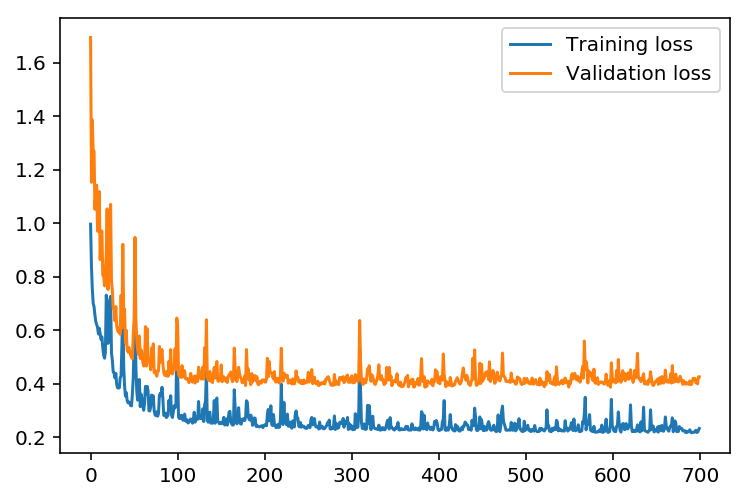

In [34]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

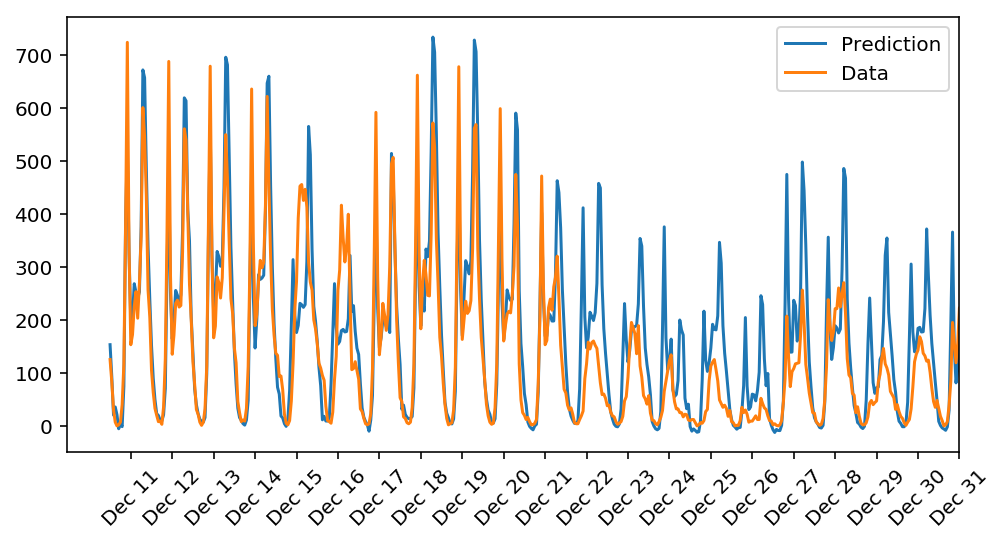

In [35]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below
From the graph it would appear for large Y values the prediction appears to be a good fit, for small values the deviation can be large. 
 My assertion is it fails at small values. 
 My guess is it fails due to the activation funciton we chose.
 
n.b. 
I tried to use some tips learned from the Udacity intro to machine learning by using the accuracy score but had an issue with to format (will try again later). 